# Comparison of GARCH and Data Science Models in Financial Times Series Forecasting: An analysis for the financial market volatility in the banking and automobile industry.

## Contents 

1. Libraries
2. Data preparation
3. EDA
4. Building Models
*GARCH models*
- ARCH
- GARCH model
- GARCH-t model
- EGARCH model

*Data Science models*
- LSTM
- Random Forest
5. Models comparison

## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import yfinance as yf
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from scipy.stats import norm
import scipy.optimize as opt
import datetime
import time
from sklearn.metrics import mean_squared_error as mse
from arch import arch_model
from statsmodels.tsa.stattools import ARMA
from statsmodels.tsa.arima_model import ARIMA
from time import time
import sys
pd.options.display.max_rows = 10
import datetime
from matplotlib.pyplot import figure
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from numpy import asarray
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
from tabulate import tabulate
import statsmodels.tsa.api as tsa
import matplotlib.cm as cm
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")

## Data preparation

### Import Data

We use data from four international stock markets, including two different industries (Banking and Automotive) retrieved from YahooFinance from the period **2000-01-01** to **2020-12-31**.

In [2]:
#Let's read the data for the chosen period (2000-01-01 --> 2020-12-31)
Tickers = ["DBK.DE", "BAC", "BMW.DE", "F"]
df= yf.download(Tickers, start = "2000-01-01", end = "2020-12-31") ['Close']
df.columns = df.columns.str.lower().str.replace(' ', '_')
df

[*********************100%***********************]  4 of 4 completed


bac     bmw.de     dbk.de          f
Date                                                  
1999-12-31  25.093750        NaN        NaN  29.297592
2000-01-03  24.218750  29.490000  65.045204  28.782394
2000-01-04  22.781250  28.299999  61.775078  27.820692
2000-01-05  23.031250  27.740000  60.975021  27.923731
2000-01-06  25.000000  27.650000  64.082031  27.958078
...               ...        ...        ...        ...
2020-12-23  30.049999  73.379997   8.983000   8.990000
2020-12-24  29.959999        NaN        NaN   8.860000
2020-12-28  30.129999  73.489998   9.218000   8.890000
2020-12-29  30.010000  73.160004   8.944000   8.820000
2020-12-30  29.980000  72.230003   8.949000   8.860000

[5438 rows x 4 columns]

### Daily returns

In [3]:
#Let's calculate the "Daily log returns" 
df[['Ret_BAC', 'Ret_BMW', 'Ret_DBK', 'Ret_F']]=np.log(df[['bac','bmw.de', 'dbk.de', 'f']]).diff()
df = df.dropna() #Deleting missing values

#Converting the table as a Data Frame to be more practical 
df = pd.DataFrame(df)

#Keeping only the retuns columns 
df_RET = df[['Ret_BAC', 'Ret_BMW', 'Ret_DBK', 'Ret_F']]
df_RET

Ret_BAC   Ret_BMW   Ret_DBK     Ret_F
Date                                              
2000-01-04 -0.061189 -0.041189 -0.051582 -0.033984
2000-01-05  0.010914 -0.019986 -0.013036  0.003697
2000-01-06  0.082024 -0.003250  0.049700  0.001229
2000-01-07 -0.026601 -0.001810  0.029853  0.071120
2000-01-10 -0.035275  0.039081 -0.026102 -0.018476
...              ...       ...       ...       ...
2020-12-21  0.036642 -0.030380 -0.045192 -0.002237
2020-12-22 -0.017982  0.001805  0.017799 -0.015802
2020-12-23  0.028352  0.017597  0.022174  0.022498
2020-12-29 -0.003991 -0.004500 -0.030175 -0.007905
2020-12-30 -0.001000 -0.012793  0.000559  0.004525

[5008 rows x 4 columns]

### Realized Volatility

In [4]:
#Calculating the "Realized Volatility" using the close-to-close method
df_Vol = df_RET.std()* 252 ** 0.5 #252 are the trading days
df_Vol

Ret_BAC    0.457025
Ret_BMW    0.334252
Ret_DBK    0.411080
Ret_F      0.419874
dtype: float64

### Data per company

In [5]:
# Prepare the Data frame for each company

## DBK
DBK_RET = df[['Ret_DBK']]*100 #*100 because the GARCH fitting process has better convergence if we express the returns as percents

##BAC
BAC_RET = df[['Ret_BAC']] * 100

##BMW
BMW_RET = df[['Ret_BMW']] * 100

##Ford
F_RET = df[['Ret_F']] * 100

## EDA 

### Plot Daily returns / historical price (per company)

#### DBK

<Figure size 432x288 with 0 Axes>

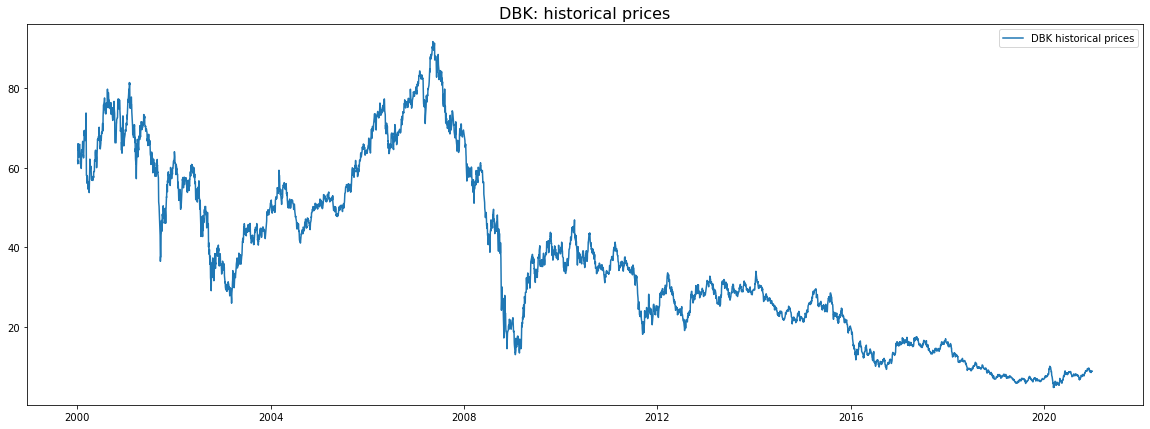

<Figure size 432x288 with 0 Axes>

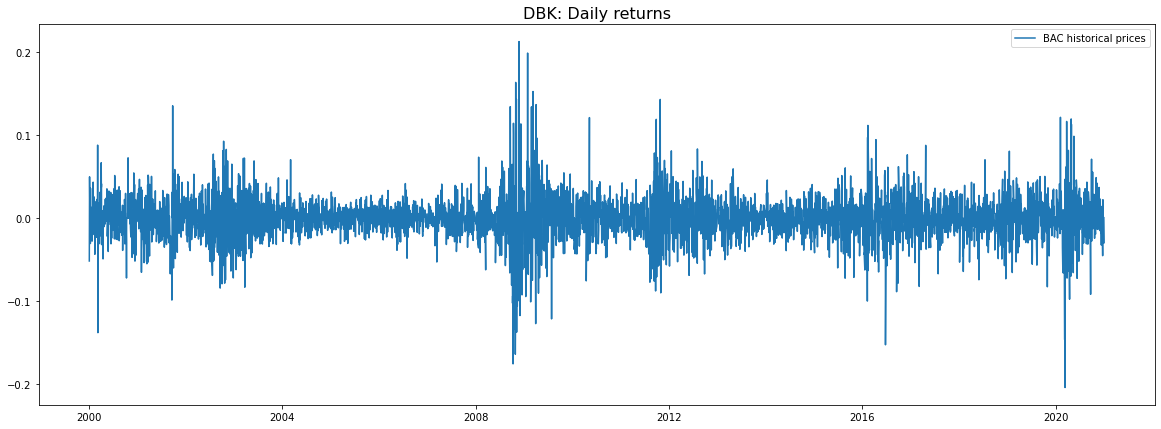

In [6]:
# Plotting DBK Price
fig = plt.figure()
plt.figure(figsize=(20, 7))
plt.plot(df[["dbk.de"]], label = ('DBK historical prices'))
plt.legend(loc='upper right')
plt.title('DBK: historical prices', fontsize=16)
plt.show()

# Plotting DBK Returns
fig = plt.figure()
plt.figure(figsize=(20, 7))
plt.plot(df[["Ret_DBK"]], label = ('BAC historical prices'))
plt.legend(loc='upper right')
plt.title('DBK: Daily returns', fontsize=16)
plt.show()

- We can see that DBK prices have fluctuated significantly. Indeed, the financial crisis of 2003 (**new market**) which arrived in Germany strongly impacted the prices of DBK. It was not until about 2004 that prices began to rise (with some decreases), only to fall drastically again due to the **global financial crisis of 2007-2008**. Then, prices rose slightly but started to fall again due to a third crisis between 2011 and 2012 (**European debt crisis**). Prices continued to fall throughout the period shown on the chart. And we can justify the sharp decline in prices in 2020 by the **COVID-19 health crisis** that heavily impacted the global banking sector.
- We can confirm this analysis by the high volatility of returns on the second graph (daily returns) during the periods 2003-2004, 2007-2010, 2011- 2013 and 2016-2020.

#### BAC 

<Figure size 432x288 with 0 Axes>

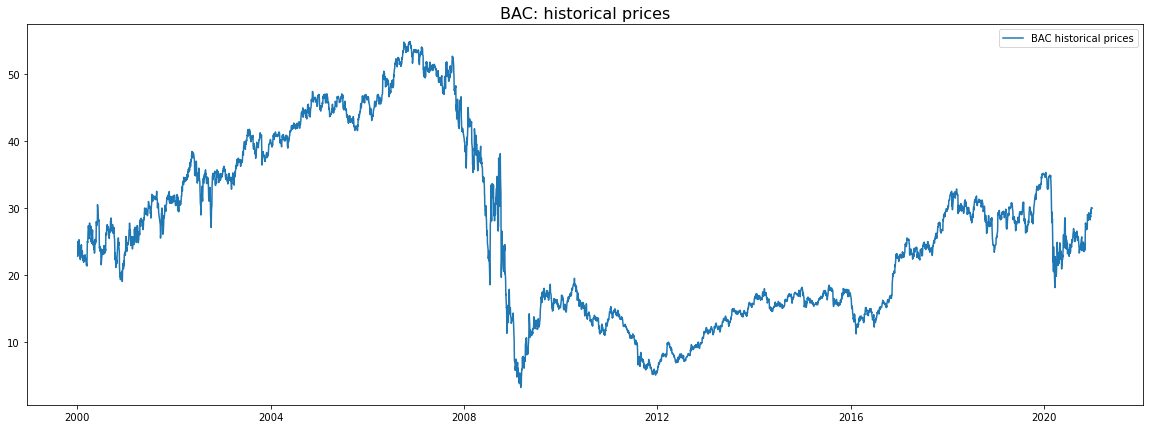

<Figure size 432x288 with 0 Axes>

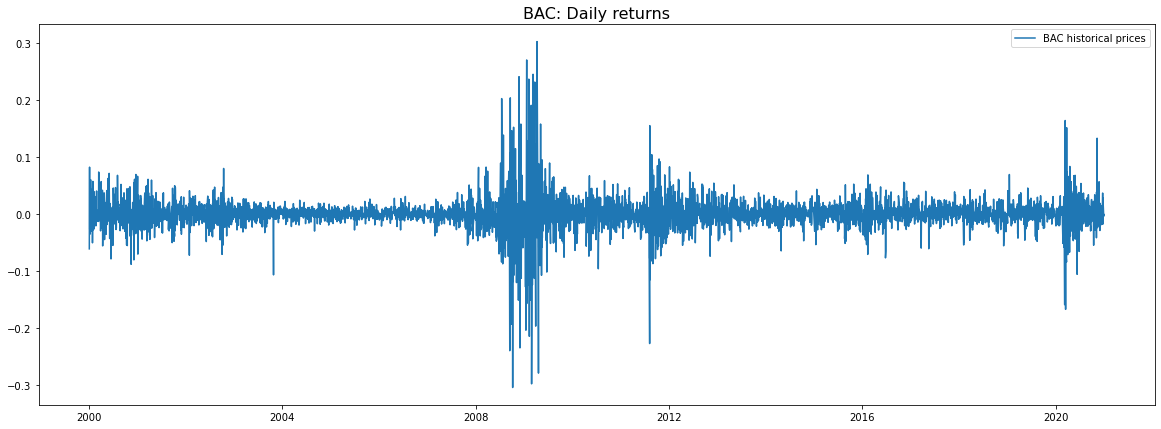

In [7]:
# Plotting BAC Price
fig = plt.figure()
plt.figure(figsize=(20, 7))
plt.plot(df[["bac"]], label = ('BAC historical prices'))
plt.legend(loc='upper right')
plt.title('BAC: historical prices', fontsize=16)
plt.show()

# Plotting BAC Returns
fig = plt.figure()
plt.figure(figsize=(20, 7))
plt.plot(df[["Ret_BAC"]], label = ('BAC historical prices'))
plt.legend(loc='upper right')
plt.title('BAC: Daily returns', fontsize=16)
plt.show()

We can apply the same analysis to the BAC case. However, in the United States, we can judge that the effects of the 2003 financial crisis were minimal. Indeed, we can see that prices continued to rise during this period. The same is true for the 2011-2012 period. The two major events where we notice a strong decrease in prices, as well as a high level of volatility (BAC: Daily returns) are the global crisis of 2007 and the COVID-19 health crisis.

#### BMW 

<Figure size 432x288 with 0 Axes>

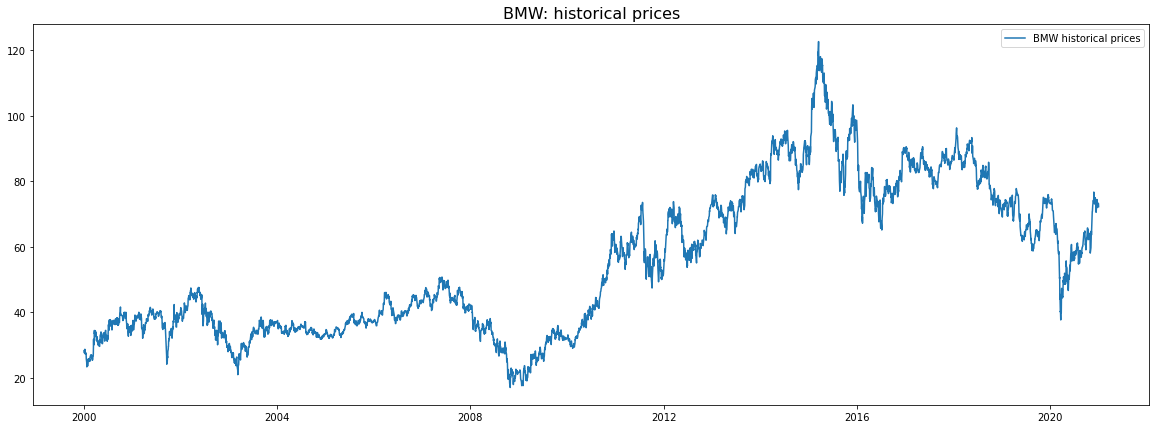

<Figure size 432x288 with 0 Axes>

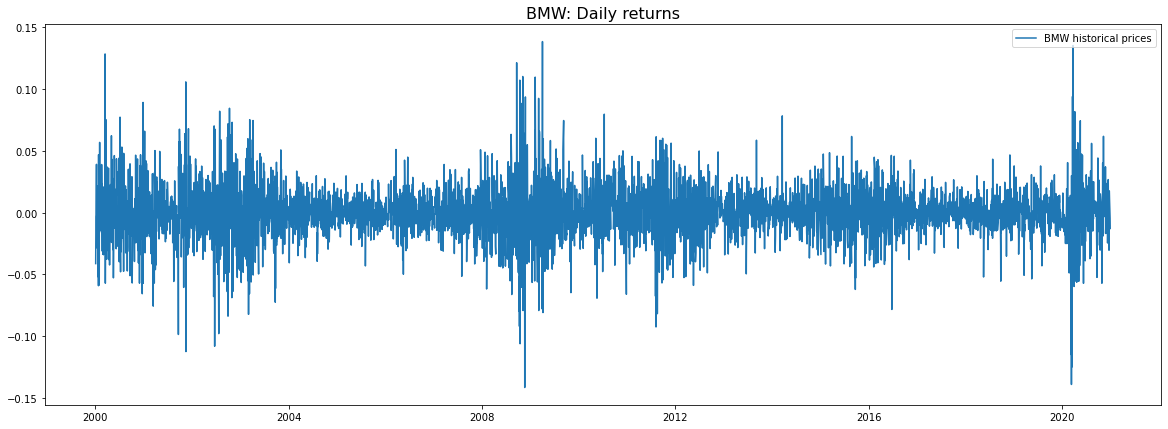

In [8]:
# Plotting BMW Price
fig = plt.figure()
plt.figure(figsize=(20, 7))
plt.plot(df[["bmw.de"]], label = ('BMW historical prices'))
plt.legend(loc='upper right')
plt.title('BMW: historical prices', fontsize=16)
plt.show()

# Plotting BMW Returns
fig = plt.figure()
plt.figure(figsize=(20, 7))
plt.plot(df[["Ret_BMW"]], label = ('BMW historical prices'))
plt.legend(loc='upper right')
plt.title('BMW: Daily returns', fontsize=16)
plt.show()

- In the case of BMW, prices were impacted by the crises of 2003 and 2008 to reach their minimum in 2009-2010. Then, despite the crisis of 2011- 2012, we can say that the prices have increased despite some decreases until reaching a maximum just before 2016, to begin to decline again. And we can clearly see the effect of the COVID-19 crisis, however, the prices started to increase again after 2020.
- We can clearly see the high volatility (BMW: Daily returns) of returns during the same periods mentioned above.

#### FORD

<Figure size 432x288 with 0 Axes>

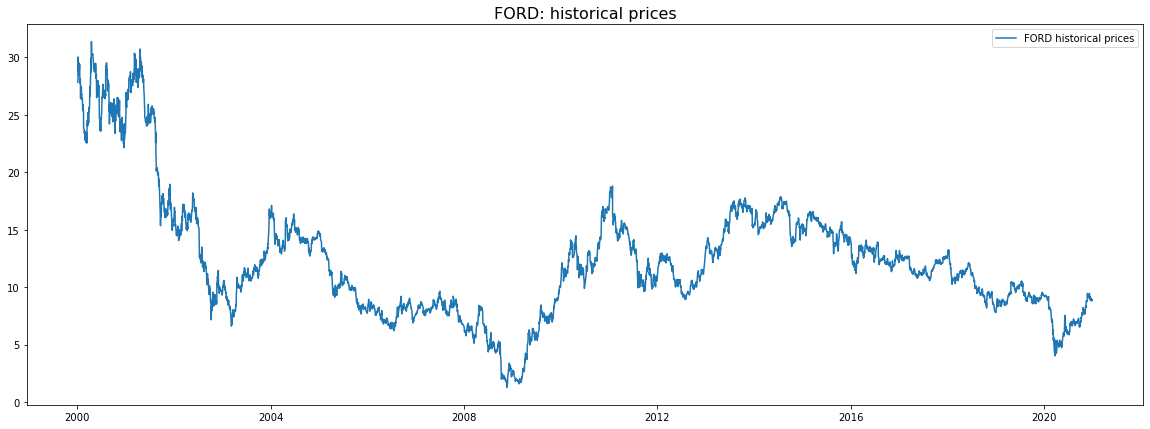

<Figure size 432x288 with 0 Axes>

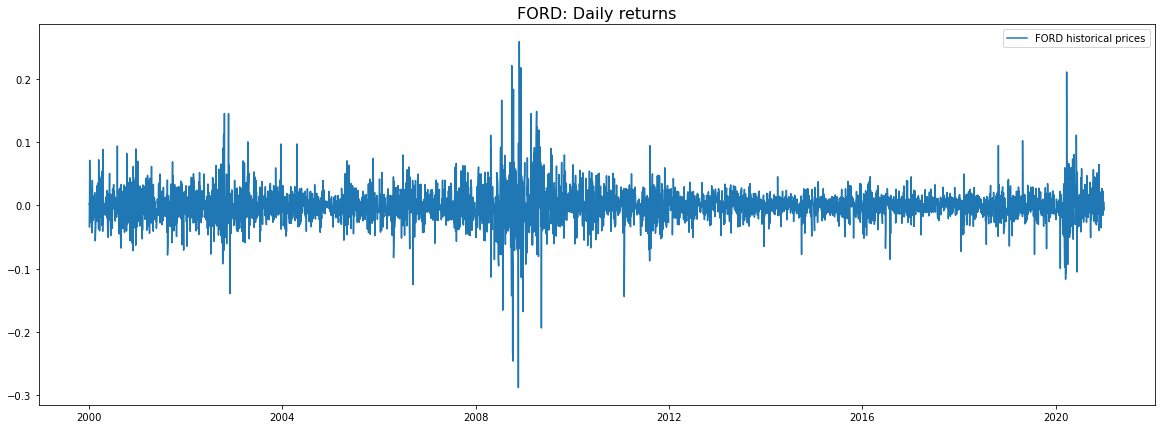

In [9]:
# Plotting FORD Price
fig = plt.figure()
plt.figure(figsize=(20, 7))
plt.plot(df[["f"]], label = ('FORD historical prices'))
plt.legend(loc='upper right')
plt.title('FORD: historical prices', fontsize=16)
plt.show()

# Plotting FORD Returns
fig = plt.figure()
plt.figure(figsize=(20, 7))
plt.plot(df[["Ret_F"]], label = ('FORD historical prices'))
plt.legend(loc='upper right')
plt.title('FORD: Daily returns', fontsize=16)
plt.show()

Ford's prices dropped drastically from 2002-2003 until they reached their minimum in 2009 due to the global crisis in 2007. After this period, the prices started to increase and then decreased in 2011, which means that the company was affected by the 2011-2012 crisis that occurred in Germany. Thereafter, prices continued to decline. this analysis is confirmed by the high volatility of returns during these periods.

### Plotting Daily returns (Per Industry)


#### DBK vs BAC

<Figure size 432x288 with 0 Axes>

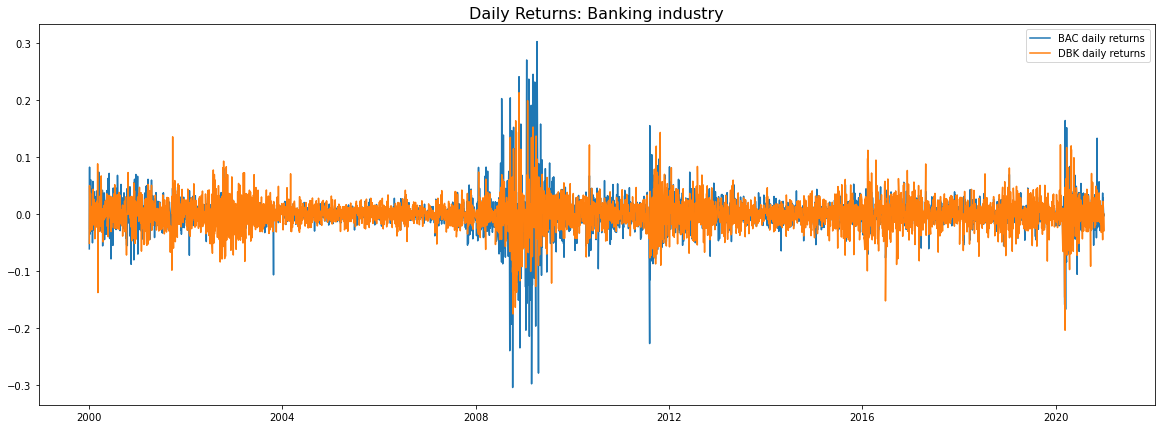

In [10]:
fig = plt.figure()
plt.figure(figsize=(20, 7))
plt.plot(df_RET[["Ret_BAC","Ret_DBK"]], label = ('BAC daily returns', 'DBK daily returns'))
plt.legend(loc='upper right')
plt.title('Daily Returns: Banking industry', fontsize=16)
plt.show()

We can see that DBK was affected by the 2003 crisis, unlike LAC. However, the financial crisis of 2008 had a much greater impact on BAC than on DBK.

#### BMW vs FORD

<Figure size 432x288 with 0 Axes>

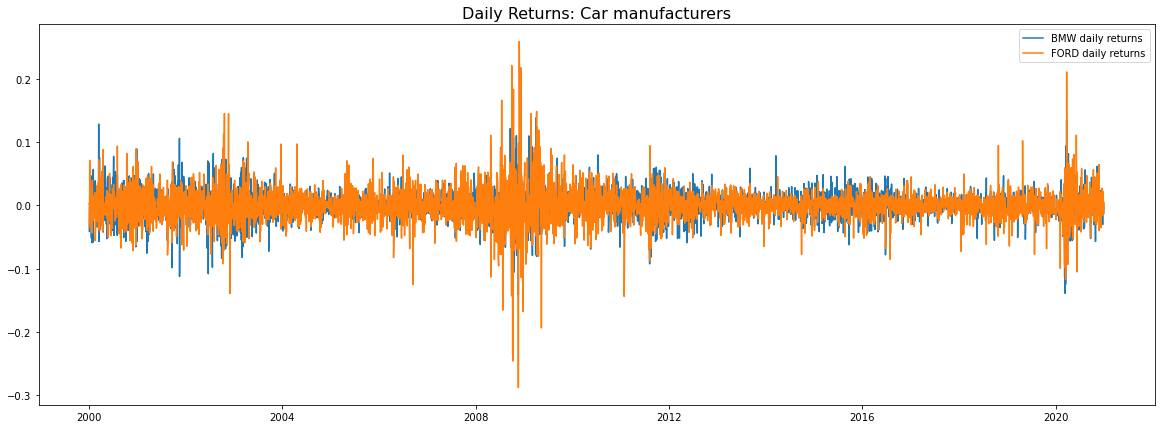

In [11]:
fig = plt.figure()
plt.figure(figsize=(20, 7))
plt.plot(df_RET[["Ret_BMW","Ret_F"]], label = ('BMW daily returns', 'FORD daily returns'))
plt.legend(loc='upper right')
plt.title('Daily Returns: Car manufacturers', fontsize=16)
plt.show()

We can note that the level of volatility of Ford is higher than that of BMW. We can explain this by the fact that Ford was more affected by the crises that took place during the period studied.

## Building Models

### GARCH models

#### ARCH 

##### Deutsche Bank AG

In [12]:
# Specify ARCH model assumptions
ARCH_DBK = arch_model(DBK_RET, p = 1, q = 0, vol = 'ARCH', dist = 'normal')

# Fit the model
ARCH_result_DBK = ARCH_DBK.fit(update_freq=5, disp="off")

# Get model estimated volatility
ARCH_vol_DBK = ARCH_result_DBK.conditional_volatility

# Forecasting
Prediction_DBK = ARCH_result_DBK.forecast(horizon = 1, start = '2020-12-14')
Forecast_ARCH_DBK = Prediction_DBK
Forecast_ARCH_DBK

print(ARCH_result_DBK.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                Ret_DBK   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -11629.2
Distribution:                  Normal   AIC:                           23264.3
Method:            Maximum Likelihood   BIC:                           23283.9
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:07   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0319  3.729e-02     -0.856      0.392 [ -0.105,

In [13]:
# Calculate the RMSE 

a = 90
DBK_90 = DBK_RET.iloc[-a:].index # We are going to use it for our plot (Plot 90 days of real observations)
b = 10 # 10 days of forecasting
DBK_10 = DBK_RET.iloc[-b:].index 

rmse_arch = np.sqrt(mse(DBK_RET[-b:] / 100,
                        np.sqrt(Forecast_ARCH_DBK\
                                .variance.iloc[-len(DBK_10):]
                                / 100)))
print('The RMSE value of ARCH model (DBK): {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model (DBK): 0.2504


##### Bank of America Corp

In [14]:
# Specify GARCH model assumptions
ARCH_BAC = arch_model(BAC_RET, p = 1, q = 0, vol = 'ARCH', dist = 'normal')

# Fit the model
ARCH_result_BAC = ARCH_BAC.fit(update_freq=5, disp="off")

# Get model estimated volatility
ARCH_vol_BAC = ARCH_result_BAC.conditional_volatility

# Forecasting
Prediction_BAC = ARCH_result_BAC.forecast(horizon = 1, start = '2020-12-14')
Forecast_ARCH_BAC = Prediction_BAC
Forecast_ARCH_BAC
print(ARCH_result_BAC.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                Ret_BAC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -11212.0
Distribution:                  Normal   AIC:                           22429.9
Method:            Maximum Likelihood   BIC:                           22449.5
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:08   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.3240e-04  4.322e-02 -1.232e-02      0.

In [15]:
# Calculate the RMSE

c = 90
BAC_90 = BAC_RET.iloc[-a:].index 
d = 10
BAC_10 = BAC_RET.iloc[-b:].index 

rmse_arch = np.sqrt(mse(BAC_RET[-d:] / 100,
                        np.sqrt(Forecast_ARCH_BAC\
                                .variance.iloc[-len(BAC_10):]
                                / 100)))
print('The RMSE value of ARCH model (BAC): {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model (BAC): 0.2273


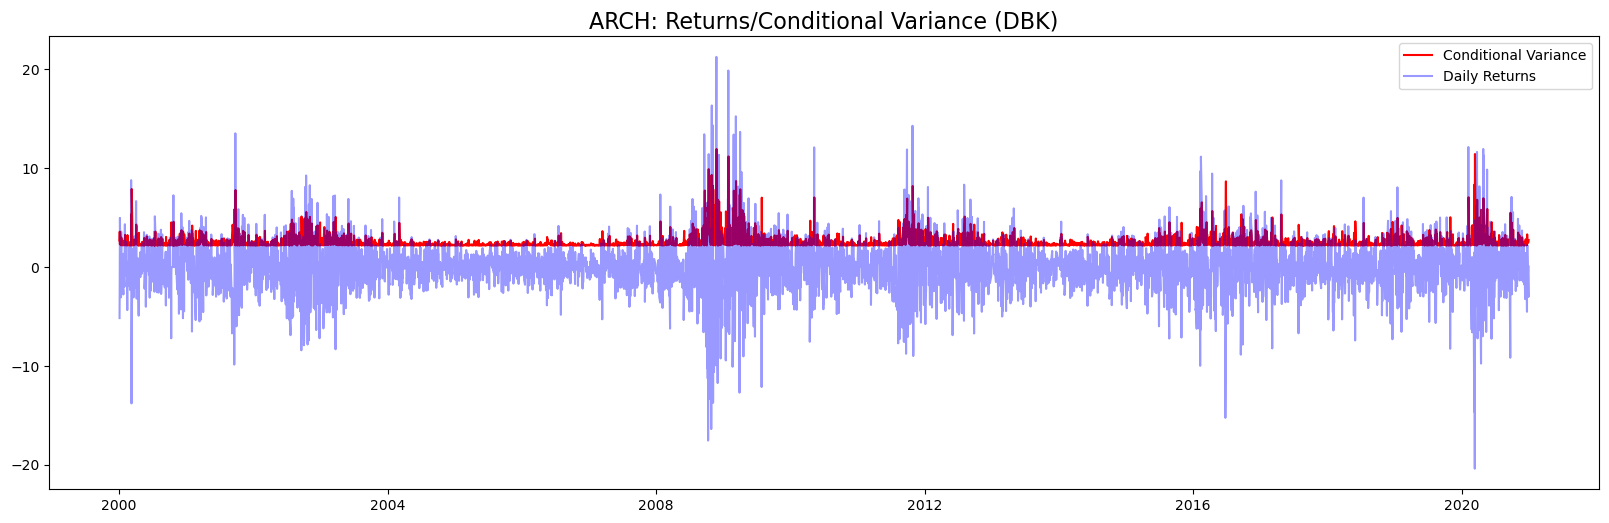

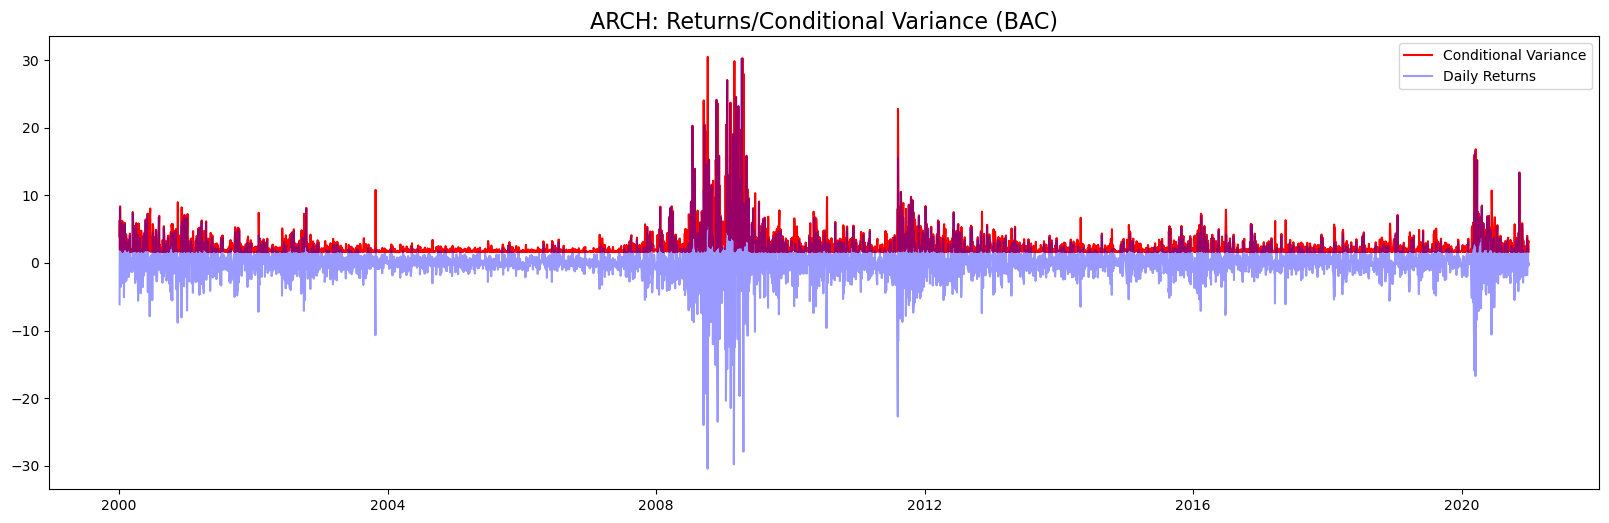

In [16]:
# Ploting Returns/Conditional Variance

## DBK
figure(figsize=(20, 6), dpi=100)
plt.plot(ARCH_vol_DBK, color = 'red', label = 'Conditional Variance')
plt.plot(DBK_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('ARCH: Returns/Conditional Variance (DBK)', fontsize=16)
plt.show()

## BAC
figure(figsize=(20, 6), dpi=100)
plt.plot(ARCH_vol_BAC, color = 'red', label = 'Conditional Variance')
plt.plot(BAC_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('ARCH: Returns/Conditional Variance (BAC)', fontsize=16)
plt.show()

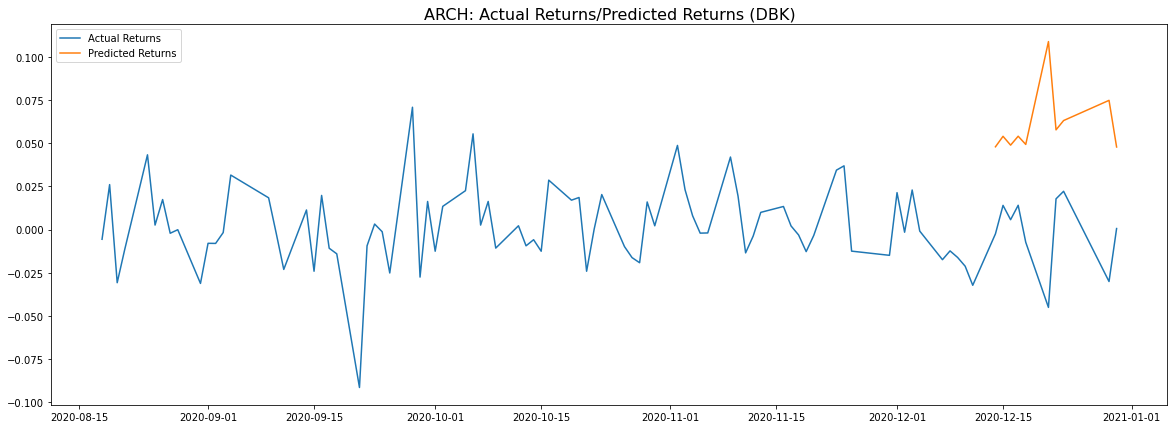

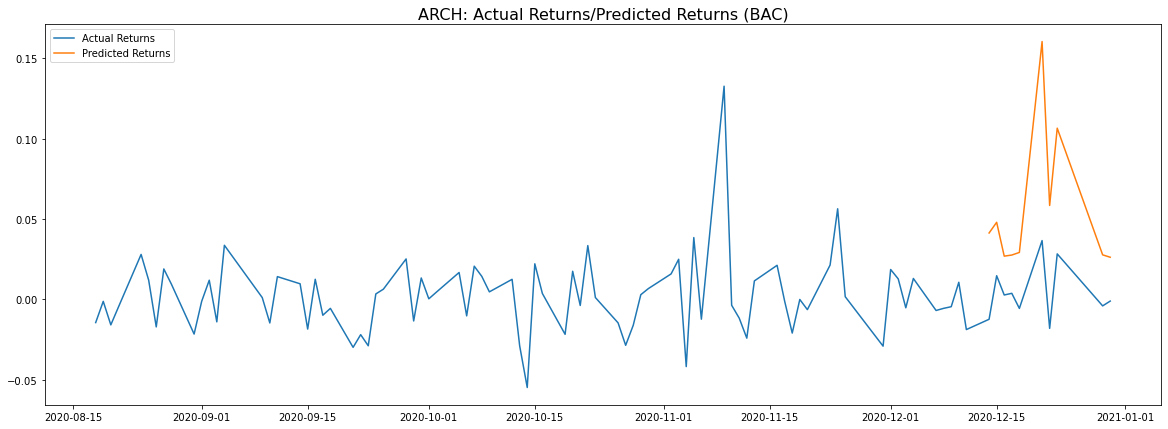

In [17]:
# Ploting Actual Returns/Predicted Returns 

## DBK
plt.figure(figsize=(20, 7))
plt.plot(DBK_RET.iloc[-len(DBK_90):] / 100, label='Actual Returns')
plt.plot(Forecast_ARCH_DBK.variance.iloc[-len(DBK_10):] / 100,
        label='Predicted Returns')
plt.title('ARCH: Actual Returns/Predicted Returns (DBK)', fontsize=16)
plt.legend()
plt.show()

## BAC
plt.figure(figsize=(20, 7))
plt.plot(BAC_RET.iloc[-len(BAC_90):] / 100, label='Actual Returns')
plt.plot(Forecast_ARCH_BAC.variance.iloc[-len(BAC_10):] / 100,
        label='Predicted Returns')
plt.title('ARCH: Actual Returns/Predicted Returns (BAC)', fontsize=16)
plt.legend()
plt.show()

##### BMW

In [18]:
# Specify ARCH model assumptions
ARCH_BMW = arch_model(BMW_RET, p = 1, q = 0, vol = 'ARCH', dist = 'normal')

# Fit the model
ARCH_result_BMW = ARCH_BMW.fit(update_freq=5, disp="off")

# Get model estimated volatility
ARCH_vol_BMW = ARCH_result_BMW.conditional_volatility

# Forecasting
Prediction_BMW = ARCH_result_BMW.forecast(horizon = 1, start = '2020-12-14')
Forecast_ARCH_BMW = Prediction_BMW
Forecast_ARCH_BMW

print(ARCH_result_BMW.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                Ret_BMW   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -10687.0
Distribution:                  Normal   AIC:                           21380.0
Method:            Maximum Likelihood   BIC:                           21399.5
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:09   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.5426e-03  2.916e-02      0.224      0.822 

In [19]:
# Calculate the RMSE

e = 90
BMW_90 = BMW_RET.iloc[-e:].index 
f = 10
BMW_10 = BMW_RET.iloc[-f:].index 

rmse_arch = np.sqrt(mse(BMW_RET[-f:] / 100,
                        np.sqrt(Forecast_ARCH_BMW\
                                .variance.iloc[-len(BMW_10):]
                                / 100)))
print('The RMSE value of ARCH model (BMW): {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model (BMW): 0.2005


##### Ford

In [20]:
# Specify ARCH model assumptions
ARCH_F = arch_model(F_RET, p = 1, q = 0, vol = 'ARCH', dist = 'normal')

# Fit the model
ARCH_result_F = ARCH_F.fit(update_freq=5, disp="off")

# Get model estimated volatility
ARCH_vol_F = ARCH_result_F.conditional_volatility

# Forecasting
Prediction_F = ARCH_result_F.forecast(horizon = 1, start = '2020-12-14')
Forecast_ARCH_F = Prediction_F
Forecast_ARCH_F

print(ARCH_result_F.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Ret_F   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -11464.9
Distribution:                  Normal   AIC:                           22935.8
Method:            Maximum Likelihood   BIC:                           22955.4
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:09   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0140  3.852e-02     -0.362      0.717 

In [21]:
# Calculate the RMSE

g = 90
F_90 = F_RET.iloc[-g:].index 
h = 10
F_10 = F_RET.iloc[-h:].index 

rmse_arch = np.sqrt(mse(F_RET[-h:] / 100,
                        np.sqrt(Forecast_ARCH_F\
                                .variance.iloc[-len(F_10):]
                                / 100)))
print('The RMSE value of ARCH model (Ford): {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model (Ford): 0.2219


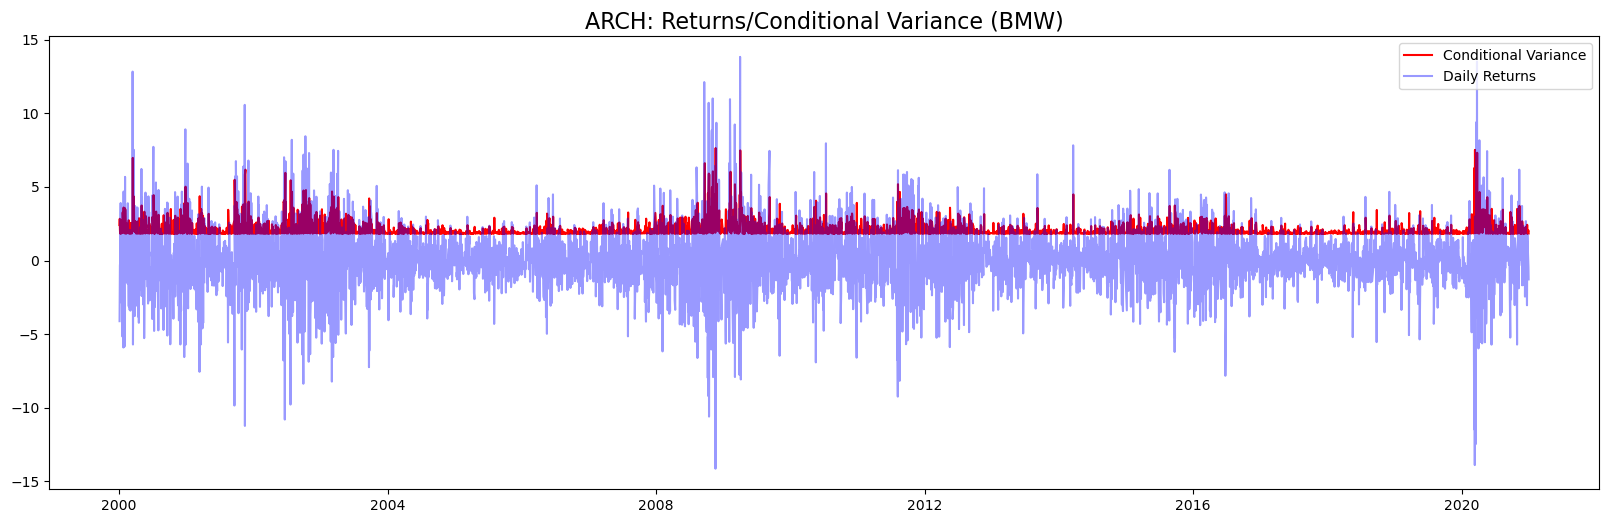

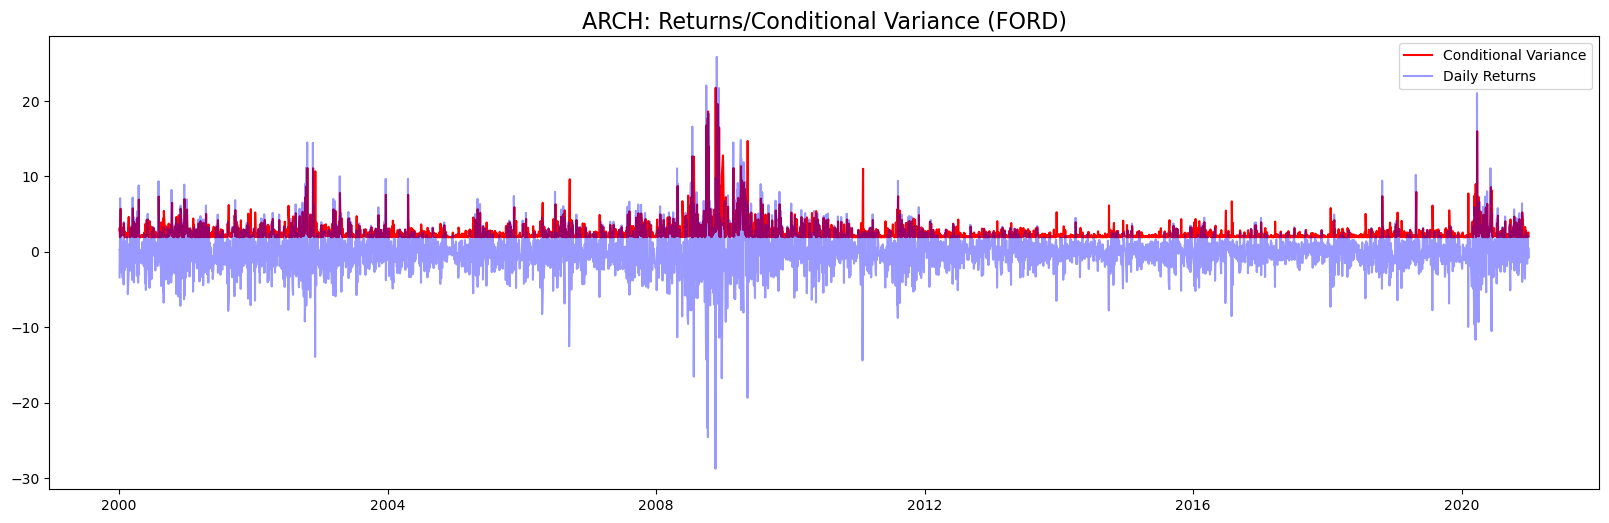

In [22]:
# Ploting Returns/Conditional Variance

## BMW
figure(figsize=(20, 6), dpi=100)
plt.plot(ARCH_vol_BMW, color = 'red', label = 'Conditional Variance')
plt.plot(BMW_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('ARCH: Returns/Conditional Variance (BMW)', fontsize=16)
plt.show()

## Ford
figure(figsize=(20, 6), dpi=100)
plt.plot(ARCH_vol_F, color = 'red', label = 'Conditional Variance')
plt.plot(F_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('ARCH: Returns/Conditional Variance (FORD)', fontsize=16)
plt.show()

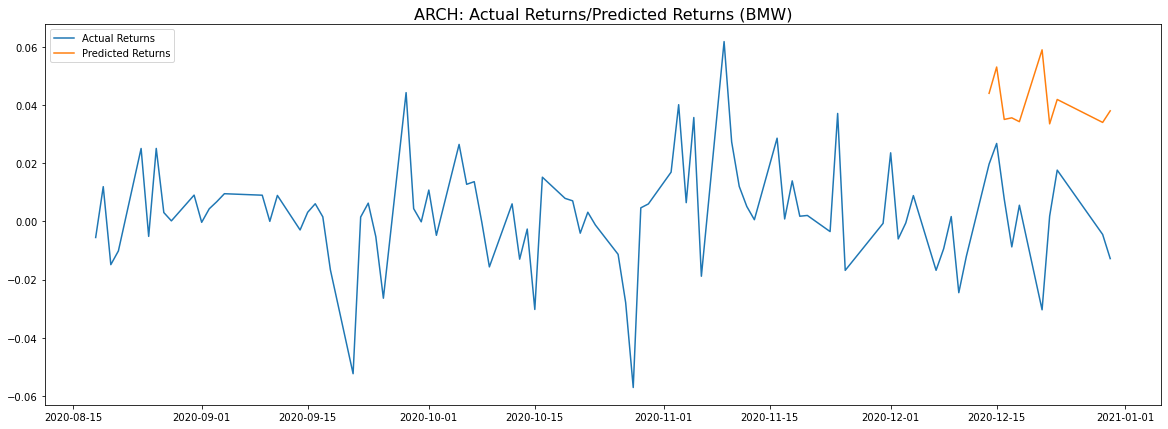

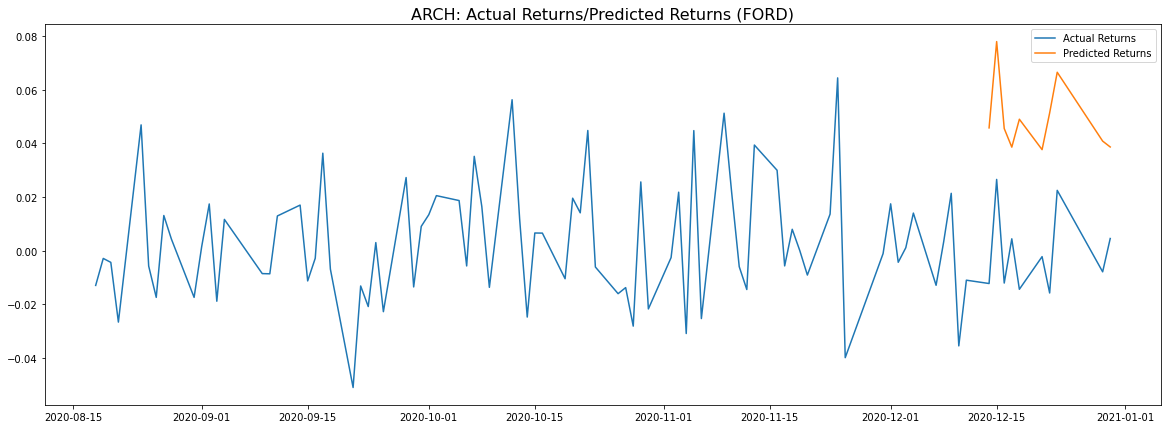

In [23]:
# Ploting Actual Returns/Predicted Returns 

## BMW
plt.figure(figsize=(20, 7))
plt.plot(BMW_RET.iloc[-len(BMW_90):] / 100, label='Actual Returns')
plt.plot(Forecast_ARCH_BMW.variance.iloc[-len(BMW_10):] / 100,
        label='Predicted Returns')
plt.title('ARCH: Actual Returns/Predicted Returns (BMW)', fontsize=16)
plt.legend()
plt.show()

## FORD
plt.figure(figsize=(20, 7))
plt.plot(F_RET.iloc[-len(F_90):] / 100, label='Actual Returns')
plt.plot(Forecast_ARCH_F.variance.iloc[-len(F_10):] / 100,
        label='Predicted Returns')
plt.title('ARCH: Actual Returns/Predicted Returns (FORD)', fontsize=16)
plt.legend()
plt.show()

#### GARCH model

##### Deutsche Bank AG

In [24]:
# Specify GARCH model assumptions
GARCH_DBK = arch_model(DBK_RET, p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'normal')

# Fit the model
GARCH_result_DBK = GARCH_DBK.fit(update_freq=5, disp="off")

# Get model estimated volatility
GARCH_vol_DBK = GARCH_result_DBK.conditional_volatility

# Forecasting
Prediction_GARCH_DBK = GARCH_result_DBK.forecast(horizon = 1, start = '2020-12-14')
Forecast_GARCH_DBK = Prediction_GARCH_DBK
Forecast_GARCH_DBK

print(GARCH_result_DBK.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Ret_DBK   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10944.0
Distribution:                  Normal   AIC:                           21896.0
Method:            Maximum Likelihood   BIC:                           21922.0
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:10   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.9844e-03  2.648e-02     -0.113      0.

In [25]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(DBK_RET[-b:] / 100,
                        np.sqrt(Forecast_GARCH_DBK\
                                .variance.iloc[-len(DBK_10):]
                                / 100)))
print('The RMSE value of GARCH model (DBK): {:.4f}'.format(rmse_arch))

The RMSE value of GARCH model (DBK): 0.2076


##### Bank of America Corp

In [26]:
# Specify GARCH model assumptions
GARCH_BAC = arch_model(BAC_RET, p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'normal')

# Fit the model
GARCH_result_BAC = GARCH_BAC.fit(update_freq=5, disp="off")

# Get model estimated volatility
GARCH_vol_BAC = GARCH_result_BAC.conditional_volatility

# Forecasting
Prediction_GARCH_BAC = GARCH_result_BAC.forecast(horizon = 1, start = '2020-12-14')
Forecast_GARCH_BAC = Prediction_GARCH_BAC
Forecast_GARCH_BAC

print(GARCH_result_BAC.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Ret_BAC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10148.2
Distribution:                  Normal   AIC:                           20304.4
Method:            Maximum Likelihood   BIC:                           20330.5
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:11   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0349  2.215e-02      1.577      0.115 

In [27]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(BAC_RET[-d:] / 100,
                        np.sqrt(Forecast_GARCH_BAC\
                                .variance.iloc[-len(BAC_10):]
                                / 100)))
print('The RMSE value of GARCH model (BAC): {:.4f}'.format(rmse_arch))

The RMSE value of GARCH model (BAC): 0.1982


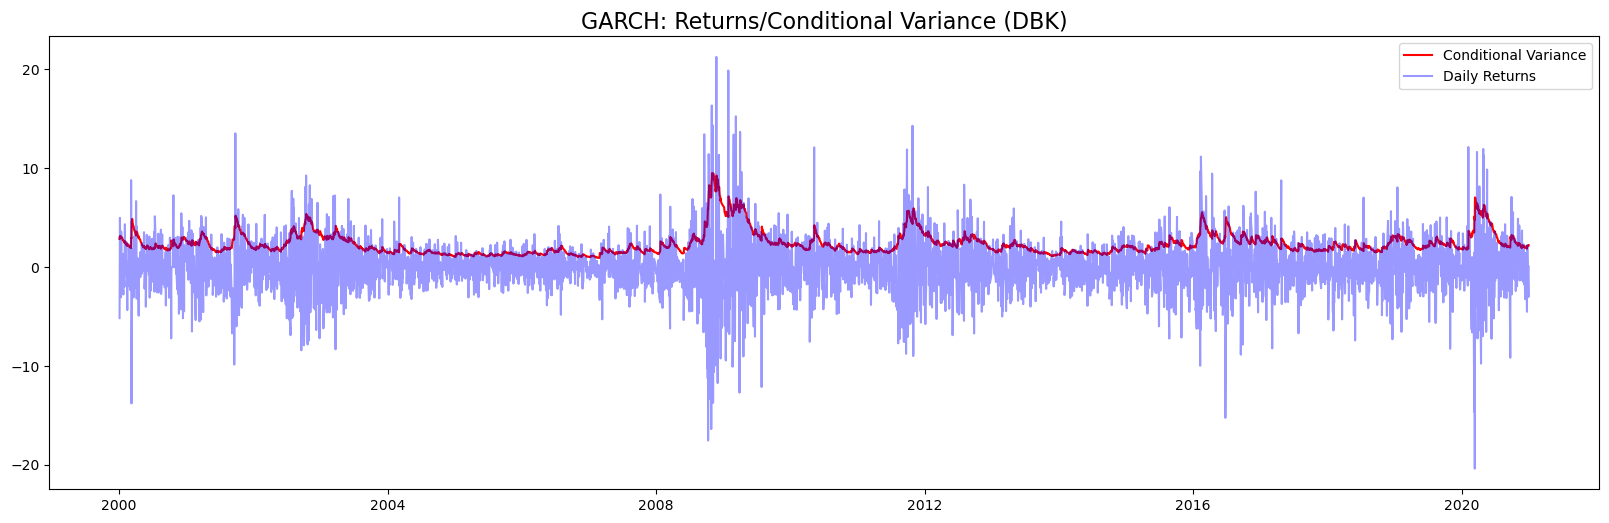

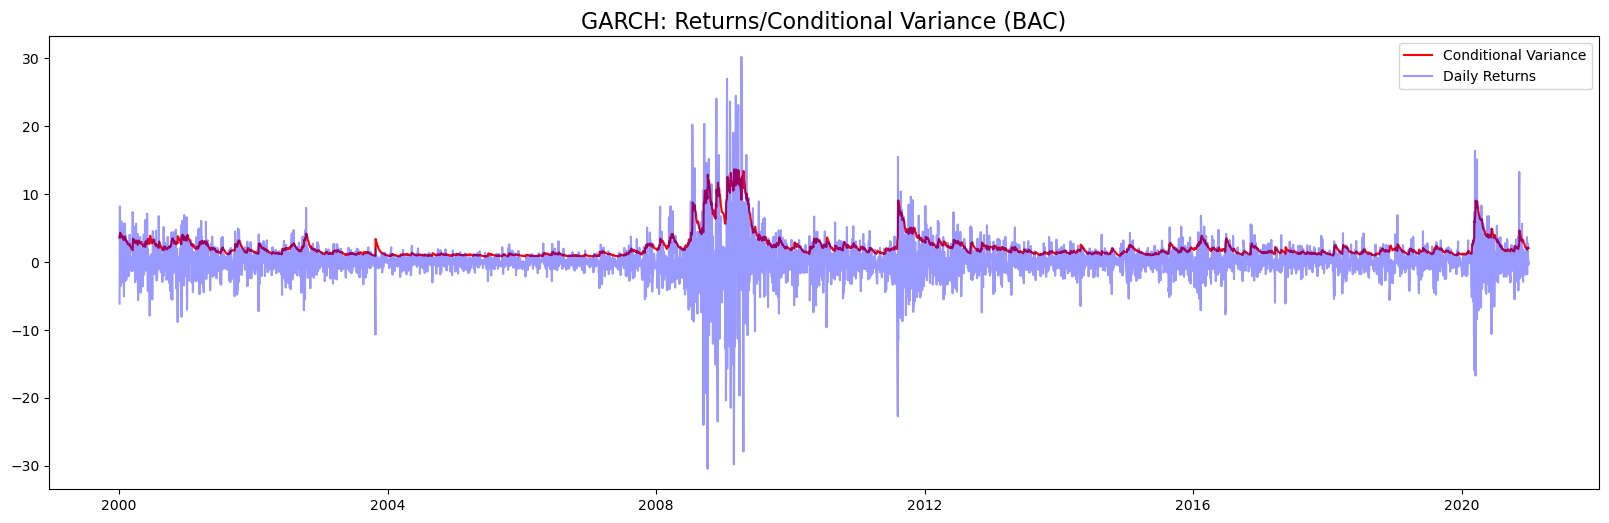

In [28]:
# Ploting Returns/Conditional Variance

## DBK
figure(figsize=(20, 6), dpi=100)
plt.plot(GARCH_vol_DBK, color = 'red', label = 'Conditional Variance')
plt.plot(DBK_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('GARCH: Returns/Conditional Variance (DBK)', fontsize=16)
plt.show()

## BAC
figure(figsize=(20, 6), dpi=100)
plt.plot(GARCH_vol_BAC, color = 'red', label = 'Conditional Variance')
plt.plot(BAC_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('GARCH: Returns/Conditional Variance (BAC)', fontsize=16)
plt.show()

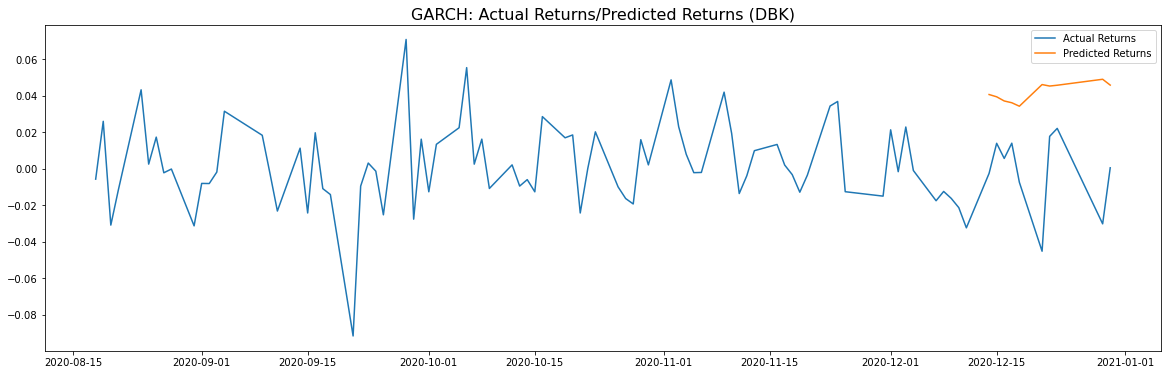

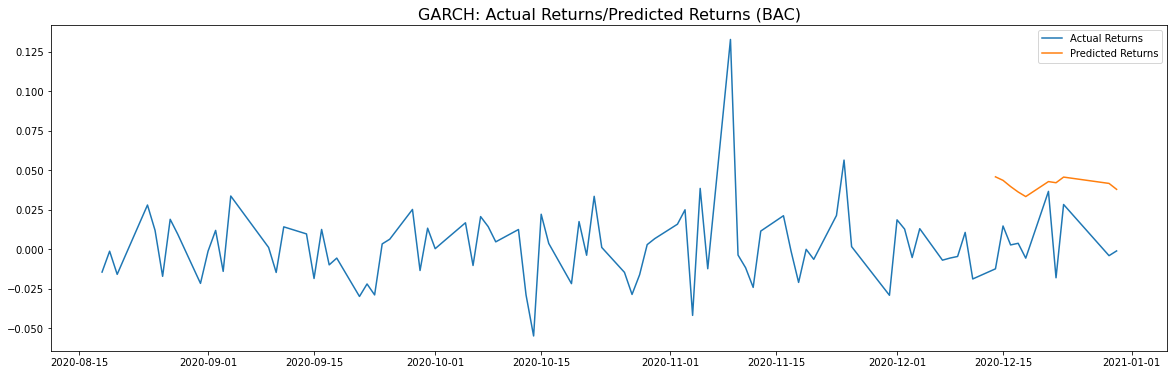

In [29]:
# Ploting Actual Returns/Predicted Returns 

## DBK
plt.figure(figsize=(20, 6))
plt.plot(DBK_RET.iloc[-len(DBK_90):] / 100, label='Actual Returns')
plt.plot(Forecast_GARCH_DBK.variance.iloc[-len(DBK_10):] / 100,
        label='Predicted Returns')
plt.title('GARCH: Actual Returns/Predicted Returns (DBK)', fontsize=16)
plt.legend()
plt.show()

## BAC
plt.figure(figsize=(20, 6))
plt.plot(BAC_RET.iloc[-len(BAC_90):] / 100, label='Actual Returns')
plt.plot(Forecast_GARCH_BAC.variance.iloc[-len(BAC_10):] / 100,
        label='Predicted Returns')
plt.title('GARCH: Actual Returns/Predicted Returns (BAC)', fontsize=16)
plt.legend()
plt.show()

##### BMW

In [30]:
# Specify GARCH model assumptions
GARCH_BMW = arch_model(BMW_RET, p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'normal')

# Fit the model
GARCH_result_BMW = GARCH_BMW.fit(update_freq=5, disp="off")

# Get model estimated volatility
GARCH_vol_BMW = GARCH_result_BMW.conditional_volatility

# Forecasting
Prediction_GARCH_BMW = GARCH_result_BMW.forecast(horizon = 1, start = '2020-12-14')
Forecast_GARCH_BMW = Prediction_GARCH_BMW
Forecast_GARCH_BMW

print(GARCH_result_BMW.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Ret_BMW   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10114.2
Distribution:                  Normal   AIC:                           20236.4
Method:            Maximum Likelihood   BIC:                           20262.4
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:12   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0345  2.325e-02      1.485      0.138 

In [31]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(BMW_RET[-f:] / 100,
                        np.sqrt(Forecast_GARCH_BMW\
                                .variance.iloc[-len(BMW_10):]
                                / 100)))
print('The RMSE value of GARCH model (BMW): {:.4f}'.format(rmse_arch))

The RMSE value of GARCH model (BMW): 0.1828


##### Ford

In [32]:
# Specify GARCH model assumptions
GARCH_F = arch_model(F_RET, p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'normal')

# Fit the model
GARCH_result_F = GARCH_F.fit(update_freq=5, disp="off")

# Get model estimated volatility
GARCH_vol_F = GARCH_result_F.conditional_volatility

# Forecasting
Prediction_GARCH_F = GARCH_result_F.forecast(horizon = 1, start = '2020-12-14')
Forecast_GARCH_F = Prediction_GARCH_F
Forecast_GARCH_F

print(GARCH_result_F.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Ret_F   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10945.9
Distribution:                  Normal   AIC:                           21899.8
Method:            Maximum Likelihood   BIC:                           21925.9
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:12   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0453  2.828e-02     -1.602      0.109 [ -0.101,

In [33]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(F_RET[-h:] / 100,
                        np.sqrt(Forecast_GARCH_F\
                                .variance.iloc[-len(F_10):]
                                / 100)))
print('The RMSE value of GARCH model (Ford): {:.4f}'.format(rmse_arch))

The RMSE value of GARCH model (Ford): 0.2174


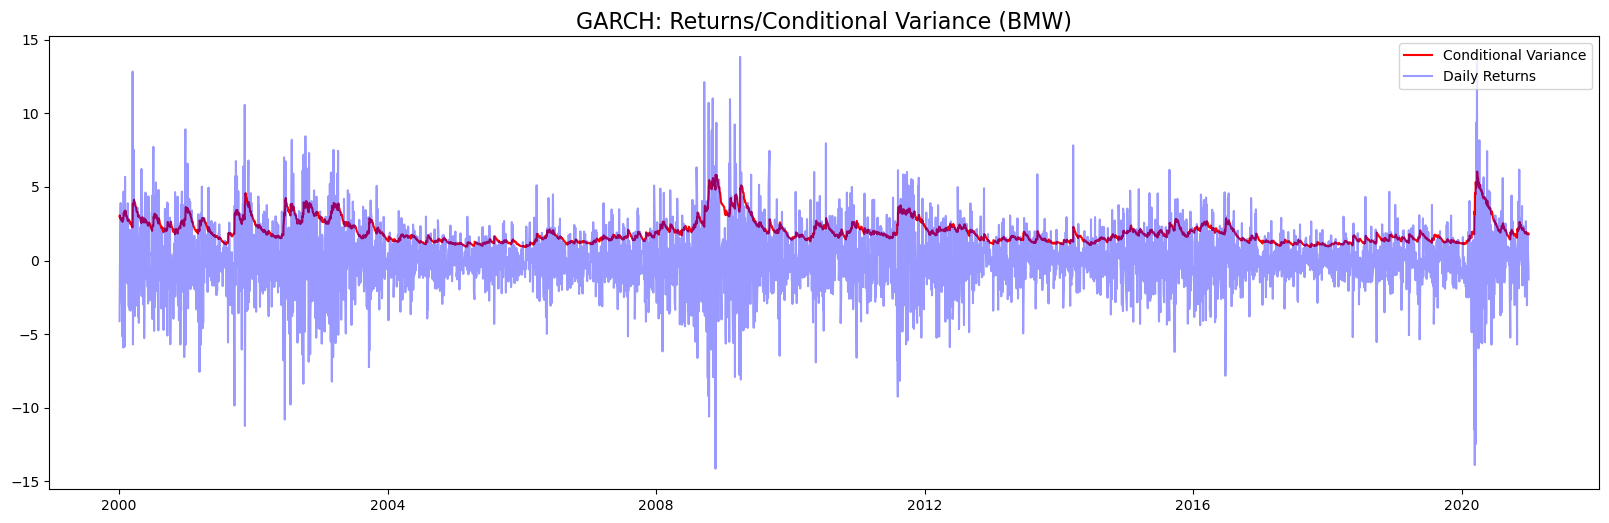

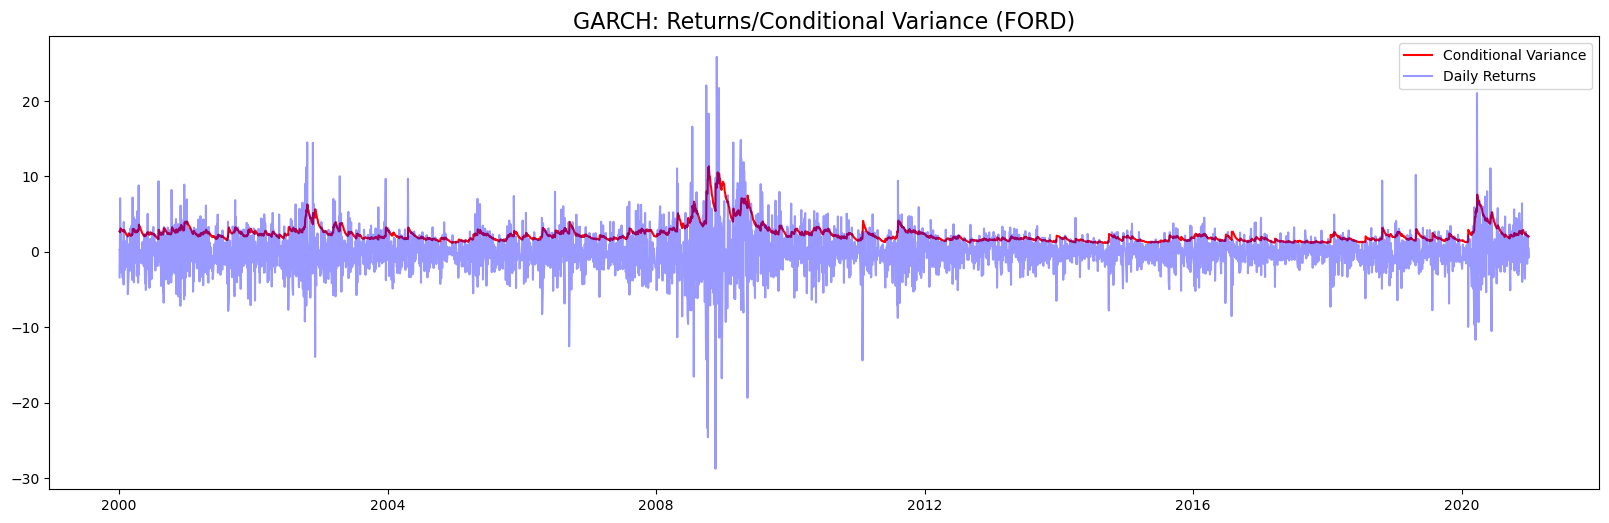

In [34]:
# Ploting Returns/Conditional Variance

## BMW
figure(figsize=(20, 6), dpi=100)
plt.plot(GARCH_vol_BMW, color = 'red', label = 'Conditional Variance')
plt.plot(BMW_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('GARCH: Returns/Conditional Variance (BMW)', fontsize=16)
plt.show()

## Ford
figure(figsize=(20, 6), dpi=100)
plt.plot(GARCH_vol_F, color = 'red', label = 'Conditional Variance')
plt.plot(F_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('GARCH: Returns/Conditional Variance (FORD)', fontsize=16)
plt.show()

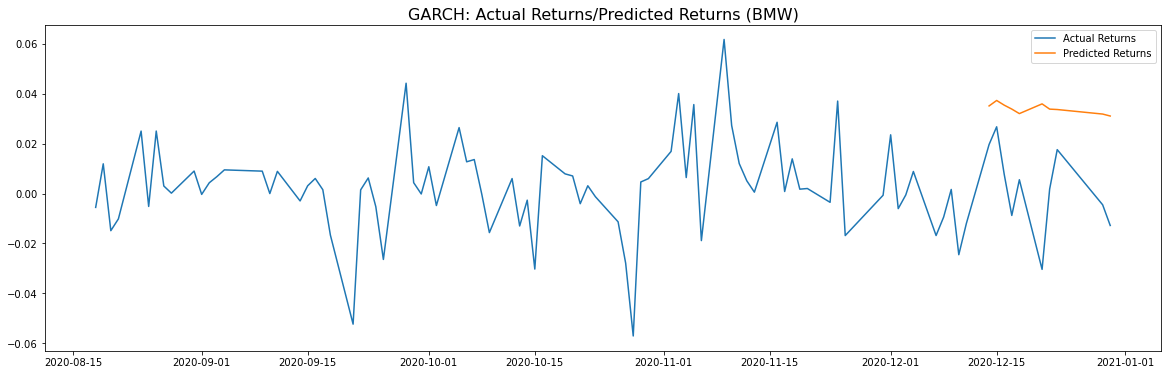

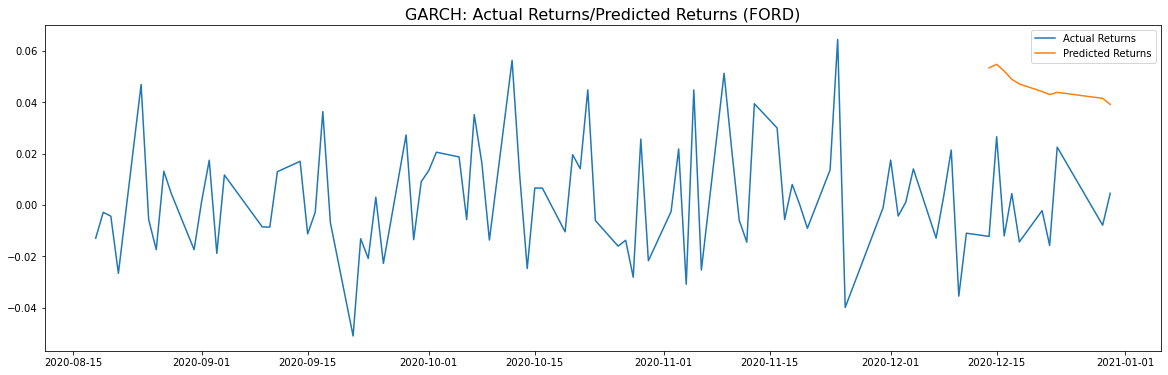

In [35]:
# Ploting Actual Returns/Predicted Returns 

## BMW
plt.figure(figsize=(20, 6))
plt.plot(BMW_RET.iloc[-len(BMW_90):] / 100, label='Actual Returns')
plt.plot(Forecast_GARCH_BMW.variance.iloc[-len(BMW_10):] / 100,
        label='Predicted Returns')
plt.title('GARCH: Actual Returns/Predicted Returns (BMW)', fontsize=16)
plt.legend()
plt.show()

## Ford
plt.figure(figsize=(20, 6))
plt.plot(F_RET.iloc[-len(F_90):] / 100, label='Actual Returns')
plt.plot(Forecast_GARCH_F.variance.iloc[-len(F_10):] / 100,
        label='Predicted Returns')
plt.title('GARCH: Actual Returns/Predicted Returns (FORD)', fontsize=16)
plt.legend()
plt.show()

#### GARCH-t model

##### Deutsche Bank AG

In [36]:
# Specify GARCH model assumptions
GARCHt_DBK = arch_model(DBK_RET, p = 1,o=0, q = 1, vol = 'GARCH', dist = "StudentsT")

# Fit the model
GARCHt_result_DBK = GARCHt_DBK.fit(update_freq=5, disp="off")

# Get model estimated volatility
GARCHt_vol_DBK = GARCHt_result_DBK.conditional_volatility

# Forecasting
Prediction_GARCHt_DBK = GARCHt_result_DBK.forecast(horizon = 1, start = '2020-12-14')
Forecast_GARCHt_DBK = Prediction_GARCHt_DBK
Forecast_GARCHt_DBK

print(GARCHt_result_DBK.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      Ret_DBK   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -10842.2
Distribution:      Standardized Student's t   AIC:                           21694.3
Method:                  Maximum Likelihood   BIC:                           21726.9
                                              No. Observations:                 5008
Date:                      Thu, Jun 02 2022   Df Residuals:                     5007
Time:                              23:44:14   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

In [37]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(DBK_RET[-b:] / 100,
                        np.sqrt(Forecast_GARCHt_DBK\
                                .variance.iloc[-len(DBK_10):]
                                / 100)))
print('The RMSE value of GARCH-t model (DBK): {:.4f}'.format(rmse_arch))

The RMSE value of GARCH-t model (DBK): 0.2074


##### Bank of America Corp

In [38]:
# Specify GARCH model assumptions
GARCHt_BAC = arch_model(BAC_RET, p = 1,o=0, q = 1, vol = 'GARCH', dist = "StudentsT")

# Fit the model
GARCHt_result_BAC = GARCHt_BAC.fit(update_freq=5, disp="off")

# Get model estimated volatility
GARCHt_vol_BAC = GARCHt_result_BAC.conditional_volatility

# Forecasting
Prediction_GARCHt_BAC = GARCHt_result_BAC.forecast(horizon = 1, start = '2020-12-14')
Forecast_GARCHt_BAC = Prediction_GARCHt_BAC
Forecast_GARCHt_BAC

print(GARCHt_result_BAC.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      Ret_BAC   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -9923.29
Distribution:      Standardized Student's t   AIC:                           19856.6
Method:                  Maximum Likelihood   BIC:                           19889.2
                                              No. Observations:                 5008
Date:                      Thu, Jun 02 2022   Df Residuals:                     5007
Time:                              23:44:14   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [39]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(BAC_RET[-d:] / 100,
                        np.sqrt(Forecast_GARCHt_BAC\
                                .variance.iloc[-len(BAC_10):]
                                / 100)))
print('The RMSE value of GARCH-t model (BAC): {:.4f}'.format(rmse_arch))

The RMSE value of GARCH-t model (BAC): 0.2018


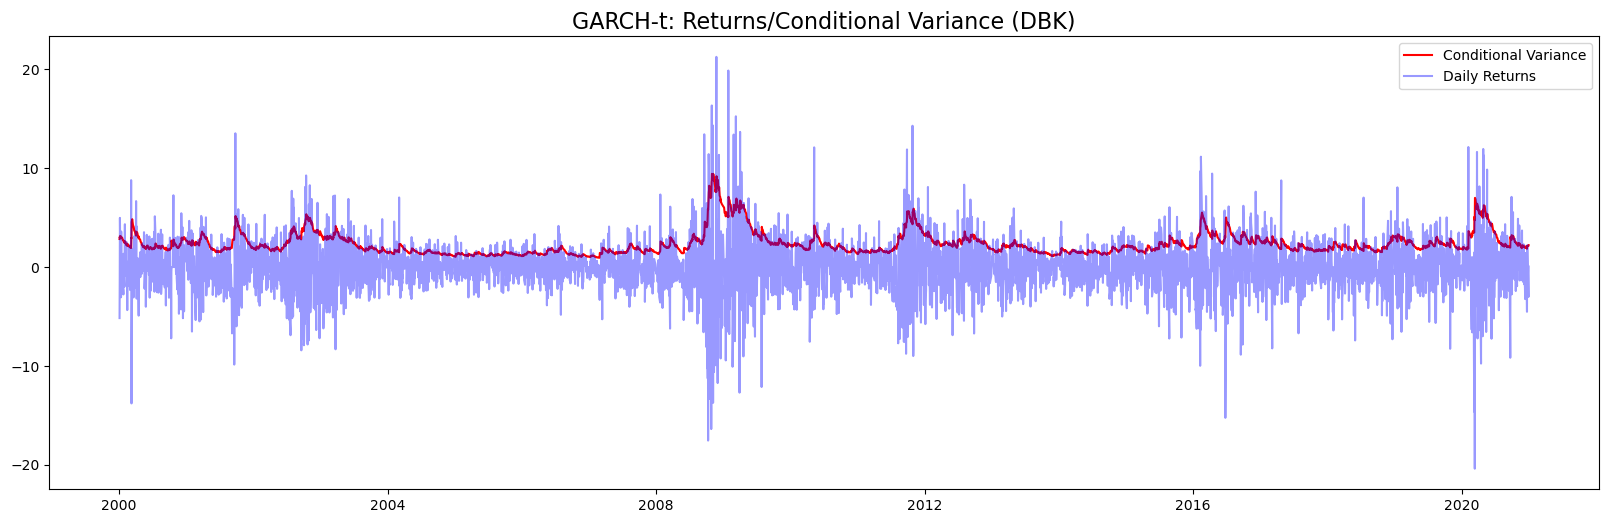

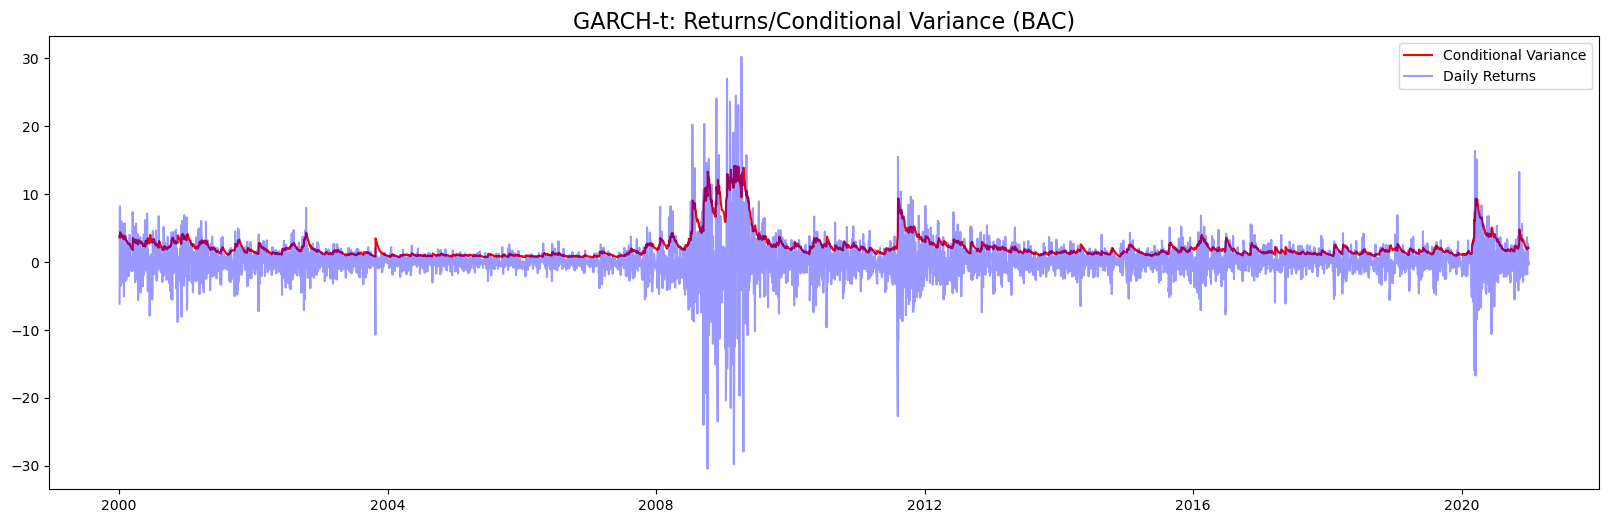

In [40]:
# Ploting Returns/Conditional Variance

## DBK
figure(figsize=(20, 6), dpi=100)
plt.plot(GARCHt_vol_DBK, color = 'red', label = 'Conditional Variance')
plt.plot(DBK_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('GARCH-t: Returns/Conditional Variance (DBK)', fontsize=16)
plt.show()

## BAC
figure(figsize=(20, 6), dpi=100)
plt.plot(GARCHt_vol_BAC, color = 'red', label = 'Conditional Variance')
plt.plot(BAC_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('GARCH-t: Returns/Conditional Variance (BAC)', fontsize=16)
plt.show()

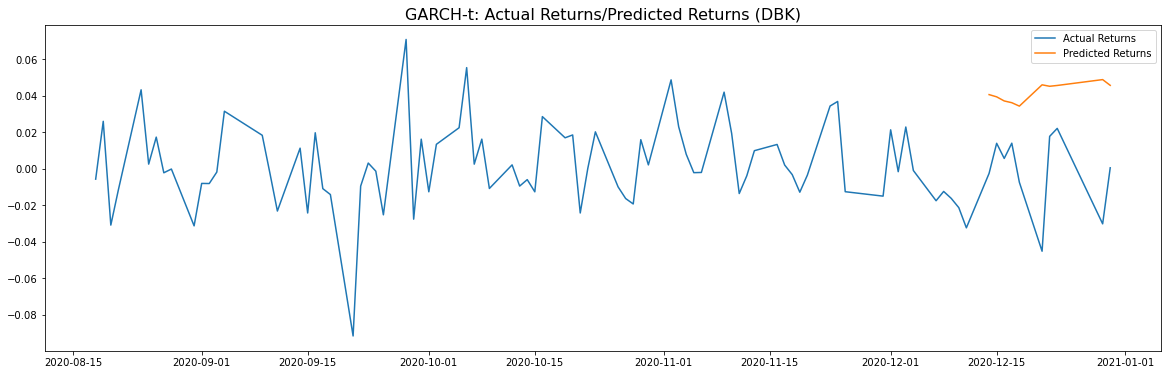

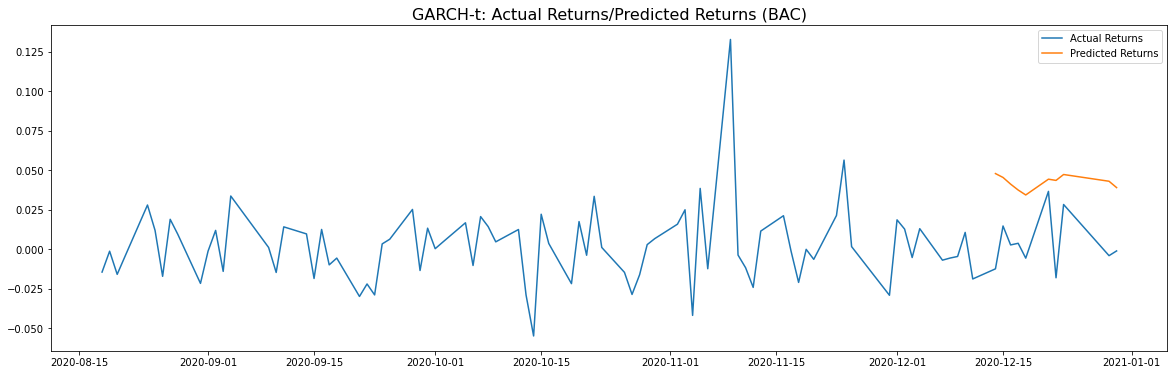

In [41]:
# Ploting Actual Returns/Predicted Returns 

## DBK
plt.figure(figsize=(20, 6))
plt.plot(DBK_RET.iloc[-len(DBK_90):] / 100, label='Actual Returns')
plt.plot(Forecast_GARCHt_DBK.variance.iloc[-len(DBK_10):] / 100,
        label='Predicted Returns')
plt.title('GARCH-t: Actual Returns/Predicted Returns (DBK)', fontsize=16)
plt.legend()
plt.show()

## BAC
plt.figure(figsize=(20, 6))
plt.plot(BAC_RET.iloc[-len(BAC_90):] / 100, label='Actual Returns')
plt.plot(Forecast_GARCHt_BAC.variance.iloc[-len(BAC_10):] / 100,
        label='Predicted Returns')
plt.title('GARCH-t: Actual Returns/Predicted Returns (BAC)', fontsize=16)
plt.legend()
plt.show()

##### BMW

In [42]:
# Specify GARCH model assumptions
GARCHt_BMW = arch_model(BMW_RET, p = 1,o=0, q = 1, vol = 'GARCH', dist = "StudentsT")

# Fit the model
GARCHt_result_BMW = GARCHt_BMW.fit(update_freq=5, disp="off")

# Get model estimated volatility
GARCHt_vol_BMW = GARCHt_result_BMW.conditional_volatility

# Forecasting
Prediction_GARCHt_BMW = GARCHt_result_BMW.forecast(horizon = 1, start = '2020-12-14')
Forecast_GARCHt_BMW = Prediction_GARCHt_BMW
Forecast_GARCHt_BMW

print(GARCHt_result_BMW.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      Ret_BMW   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -9979.97
Distribution:      Standardized Student's t   AIC:                           19969.9
Method:                  Maximum Likelihood   BIC:                           20002.5
                                              No. Observations:                 5008
Date:                      Thu, Jun 02 2022   Df Residuals:                     5007
Time:                              23:44:15   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [43]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(BMW_RET[-f:] / 100,
                        np.sqrt(Forecast_GARCHt_BMW\
                                .variance.iloc[-len(BMW_10):]
                                / 100)))
print('The RMSE value of GARCH-t model (BMW): {:.4f}'.format(rmse_arch))

The RMSE value of GARCH-t model (BMW): 0.1860


##### Ford

In [44]:
# Specify GARCH model assumptions
GARCHt_F = arch_model(F_RET, p = 1,o=0, q = 1, vol = 'GARCH', dist = "StudentsT")

# Fit the model
GARCHt_result_F = GARCHt_F.fit(update_freq=5, disp="off")

# Get model estimated volatility
GARCHt_vol_F = GARCHt_result_F.conditional_volatility

# Forecasting
Prediction_GARCHt_F = GARCHt_result_F.forecast(horizon = 1, start = '2020-12-14')
Forecast_GARCHt_F = Prediction_GARCHt_F
Forecast_GARCHt_F

print(GARCHt_result_F.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Ret_F   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -10707.5
Distribution:      Standardized Student's t   AIC:                           21424.9
Method:                  Maximum Likelihood   BIC:                           21457.5
                                              No. Observations:                 5008
Date:                      Thu, Jun 02 2022   Df Residuals:                     5007
Time:                              23:44:16   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [45]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(F_RET[-h:] / 100,
                        np.sqrt(Forecast_GARCHt_F\
                                .variance.iloc[-len(F_10):]
                                / 100)))
print('The RMSE value of GARCH-t model (Ford): {:.4f}'.format(rmse_arch))

The RMSE value of GARCH-t model (Ford): 0.2236


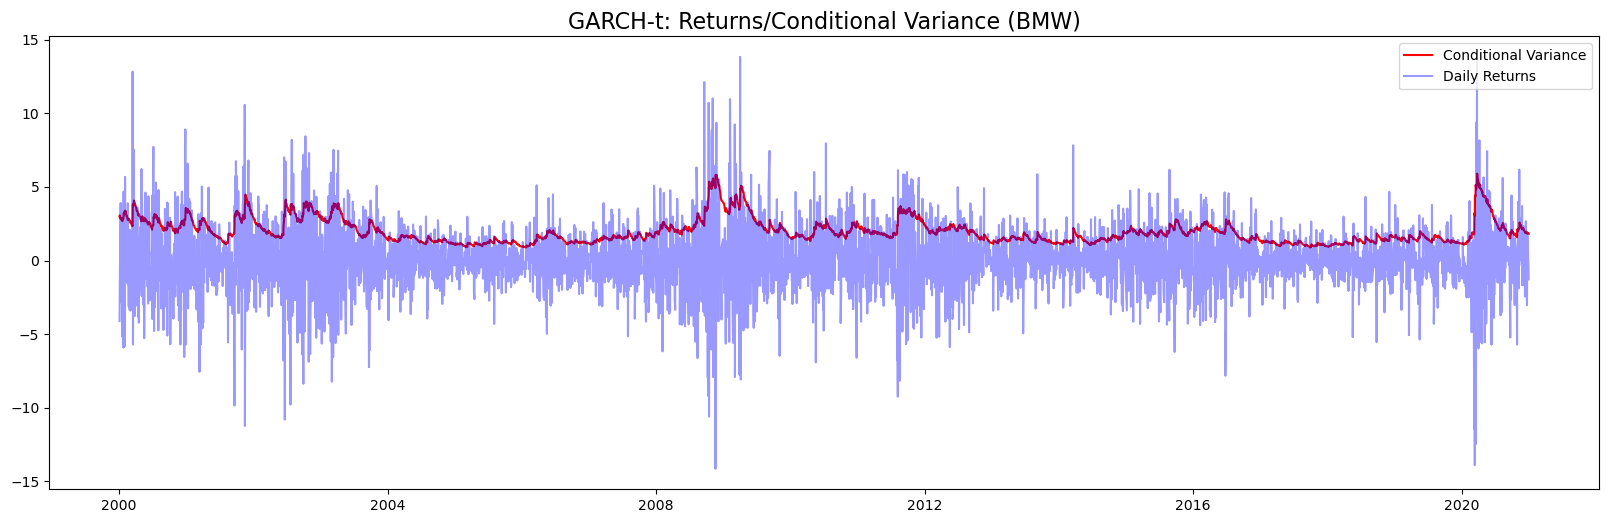

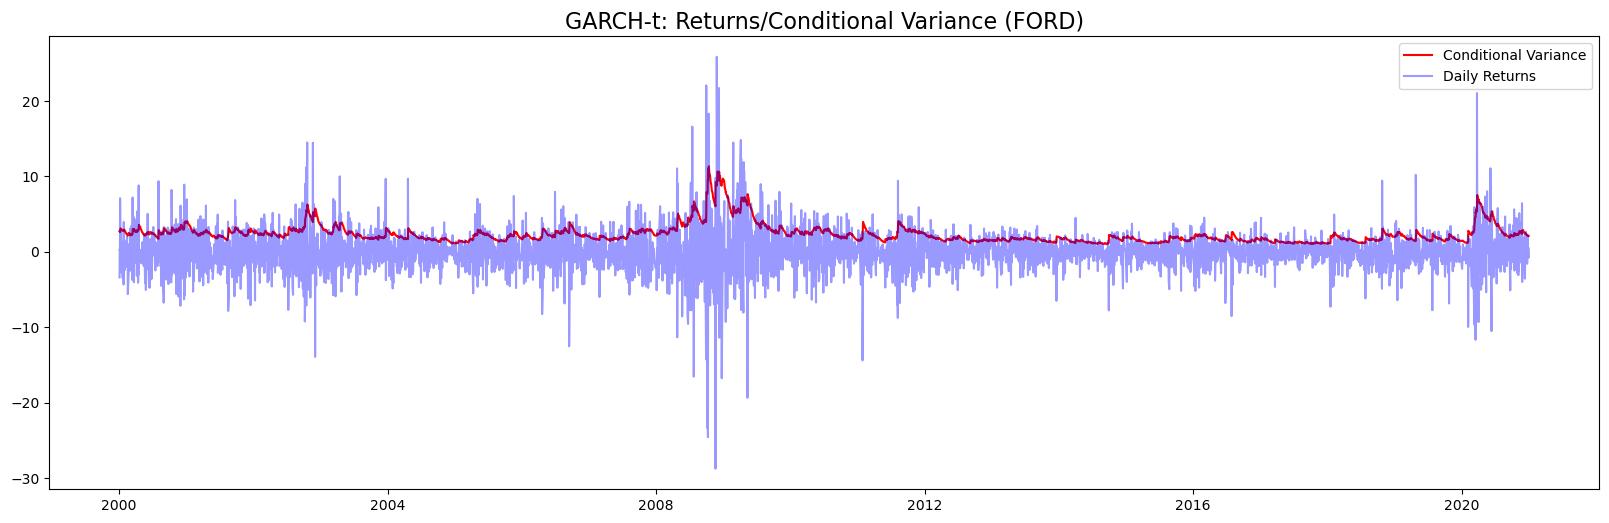

In [46]:
# Ploting Returns/Conditional Variance

## BMW
figure(figsize=(20, 6), dpi=100)
plt.plot(GARCHt_vol_BMW, color = 'red', label = 'Conditional Variance')
plt.plot(BMW_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('GARCH-t: Returns/Conditional Variance (BMW)', fontsize=16)
plt.show()

## FORD
figure(figsize=(20, 6), dpi=100)
plt.plot(GARCHt_vol_F, color = 'red', label = 'Conditional Variance')
plt.plot(F_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('GARCH-t: Returns/Conditional Variance (FORD)', fontsize=16)
plt.show()

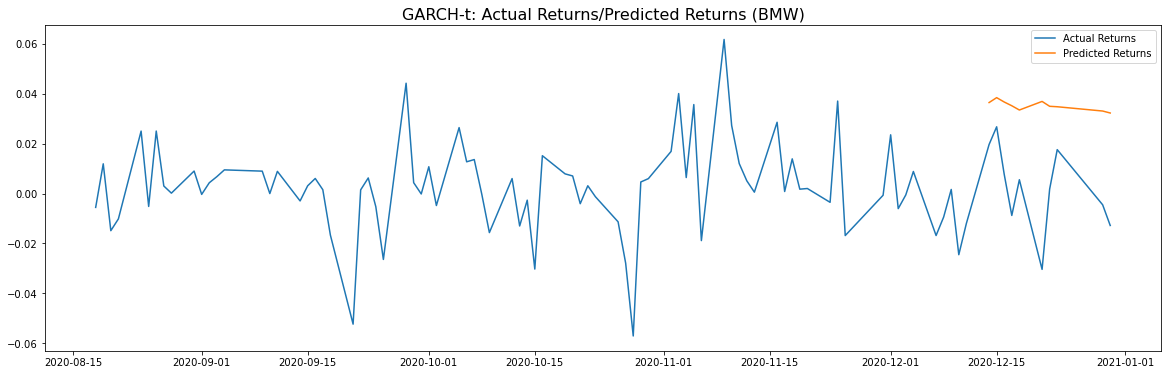

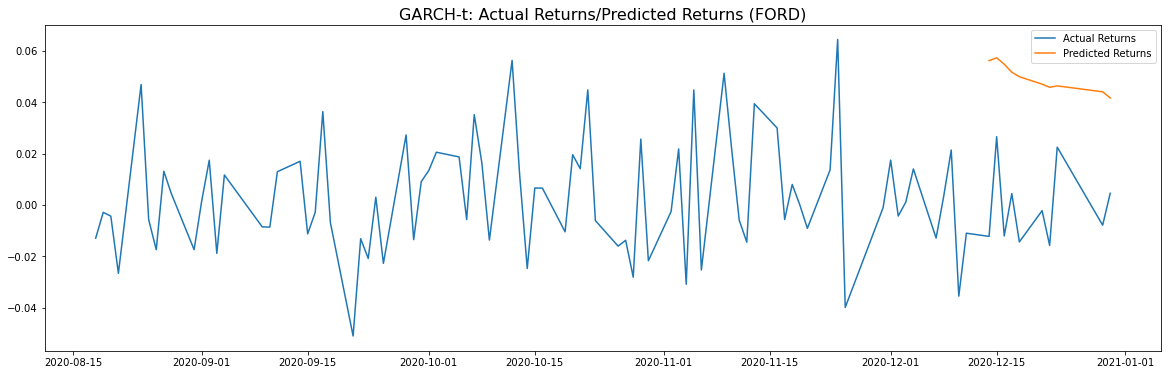

In [47]:
# Ploting Actual Returns/Predicted Returns 

## BMW
plt.figure(figsize=(20, 6))
plt.plot(BMW_RET.iloc[-len(BMW_90):] / 100, label='Actual Returns')
plt.plot(Forecast_GARCHt_BMW.variance.iloc[-len(BMW_10):] / 100,
        label='Predicted Returns')
plt.title('GARCH-t: Actual Returns/Predicted Returns (BMW)', fontsize=16)
plt.legend()
plt.show()

## FORD
plt.figure(figsize=(20, 6))
plt.plot(F_RET.iloc[-len(F_90):] / 100, label='Actual Returns')
plt.plot(Forecast_GARCHt_F.variance.iloc[-len(F_10):] / 100,
        label='Predicted Returns')
plt.title('GARCH-t: Actual Returns/Predicted Returns (FORD)', fontsize=16)
plt.legend()
plt.show()

#### EGARCH model

##### Deutsche Bank AG

In [48]:
# Specify GARCH model assumptions
EGARCH_DBK = arch_model(DBK_RET, p = 1, q = 1, vol = 'EGARCH', dist = 'normal')

# Fit the model
EGARCH_result_DBK = EGARCH_DBK.fit(update_freq=5, disp="off")

# Get model estimated volatility
EGARCH_vol_DBK = EGARCH_result_DBK.conditional_volatility

# Forecasting
Prediction_EGARCH_DBK = EGARCH_result_DBK.forecast(horizon = 1, start = '2020-12-14')
Forecast_EGARCH_DBK = Prediction_EGARCH_DBK
Forecast_EGARCH_DBK

print(EGARCH_result_DBK.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Ret_DBK   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -10941.9
Distribution:                  Normal   AIC:                           21891.7
Method:            Maximum Likelihood   BIC:                           21917.8
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:17   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.5026e-04  2.620e-02  1.718e-02      0.986 

In [49]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(DBK_RET[-b:] / 100,
                        np.sqrt(Forecast_EGARCH_DBK\
                                .variance.iloc[-len(DBK_10):]
                                / 100)))
print('The RMSE value of EGARCH model (DBK): {:.4f}'.format(rmse_arch))

The RMSE value of EGARCH model (DBK): 0.2161


##### Bank of America Corp

In [50]:
# Specify GARCH model assumptions
EGARCH_BAC = arch_model(BAC_RET, p = 1, q = 1, vol = 'EGARCH', dist = 'normal')

# Fit the model
EGARCH_result_BAC = EGARCH_BAC.fit(update_freq=5, disp="off")

# Get model estimated volatility
EGARCH_vol_BAC = EGARCH_result_BAC.conditional_volatility

# Forecasting
Prediction_EGARCH_BAC = EGARCH_result_BAC.forecast(horizon = 1, start = '2020-12-14')
Forecast_EGARCH_BAC = Prediction_EGARCH_BAC
Forecast_EGARCH_BAC

print(EGARCH_result_BAC.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Ret_BAC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -10161.4
Distribution:                  Normal   AIC:                           20330.7
Method:            Maximum Likelihood   BIC:                           20356.8
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:17   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0442  1.355e-03     32.660 5.707e-234 [4.

In [51]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(BAC_RET[-d:] / 100,
                        np.sqrt(Forecast_EGARCH_BAC\
                                .variance.iloc[-len(BAC_10):]
                                / 100)))
print('The RMSE value of EGARCH model (BAC): {:.4f}'.format(rmse_arch))

The RMSE value of EGARCH model (BAC): 0.1997


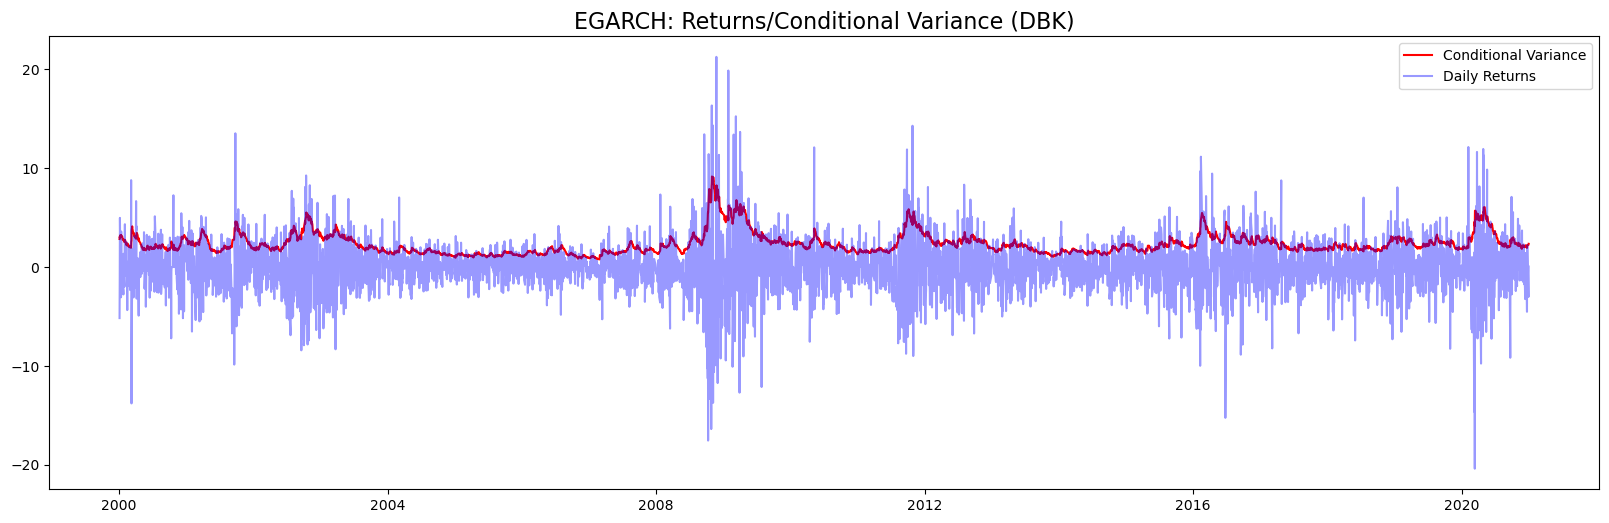

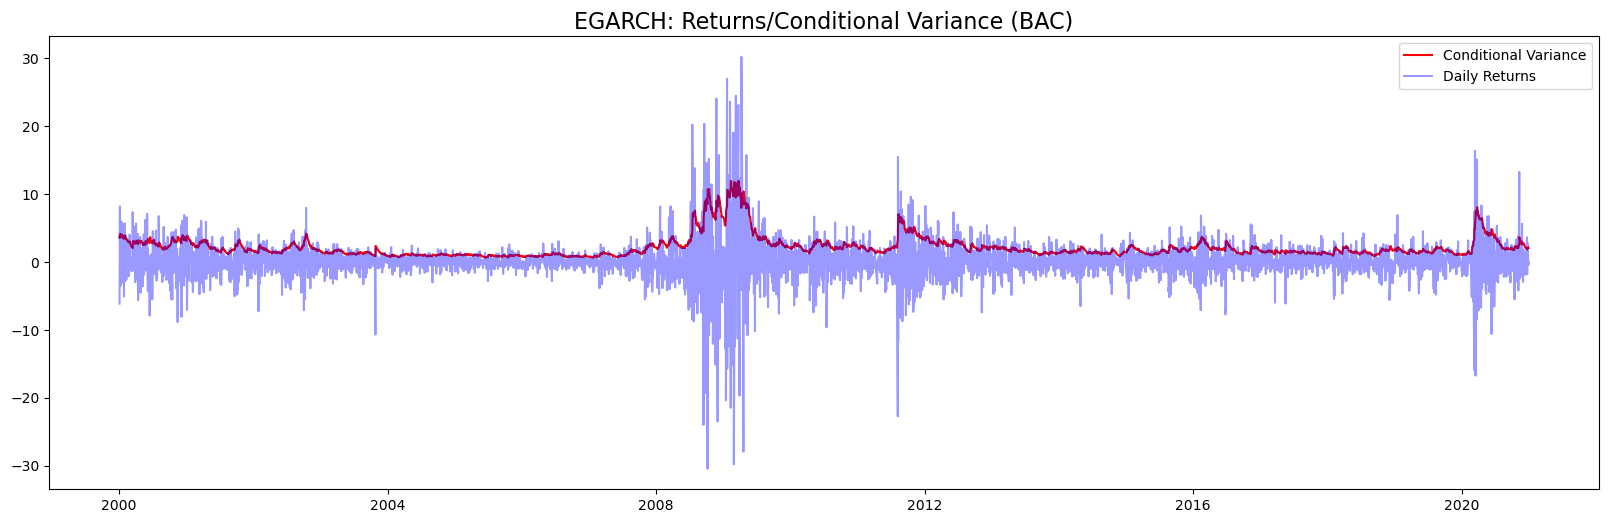

In [52]:
# Ploting Returns/Conditional Variance

## DBK
figure(figsize=(20, 6), dpi=100)
plt.plot(EGARCH_vol_DBK, color = 'red', label = 'Conditional Variance')
plt.plot(DBK_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('EGARCH: Returns/Conditional Variance (DBK)', fontsize=16)
plt.show()

## BAC
figure(figsize=(20, 6), dpi=100)
plt.plot(EGARCH_vol_BAC, color = 'red', label = 'Conditional Variance')
plt.plot(BAC_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('EGARCH: Returns/Conditional Variance (BAC)', fontsize=16)
plt.show()

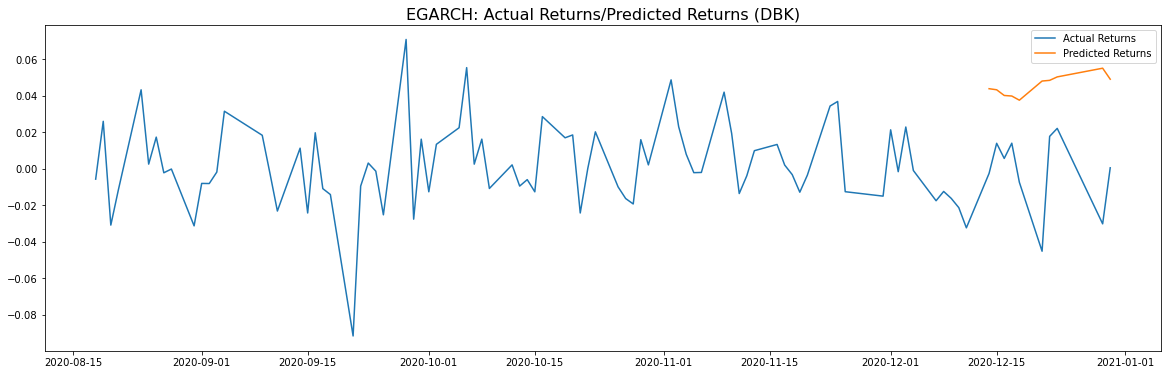

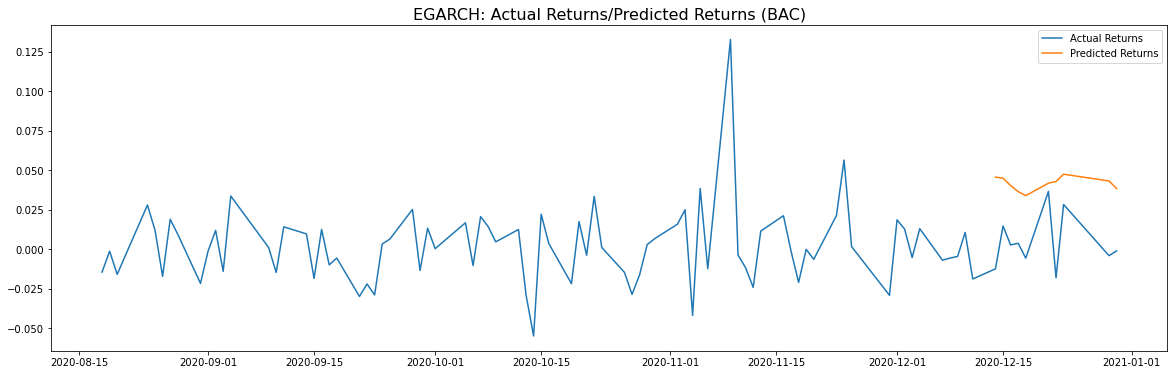

In [53]:
# Ploting Actual Returns/Predicted Returns 

## DBK
plt.figure(figsize=(20, 6))
plt.plot(DBK_RET.iloc[-len(DBK_90):] / 100, label='Actual Returns')
plt.plot(Forecast_EGARCH_DBK.variance.iloc[-len(DBK_10):] / 100,
        label='Predicted Returns')
plt.title('EGARCH: Actual Returns/Predicted Returns (DBK)', fontsize=16)
plt.legend()
plt.show()

## BAC
plt.figure(figsize=(20, 6))
plt.plot(BAC_RET.iloc[-len(BAC_90):] / 100, label='Actual Returns')
plt.plot(Forecast_EGARCH_BAC.variance.iloc[-len(BAC_10):] / 100,
        label='Predicted Returns')
plt.title('EGARCH: Actual Returns/Predicted Returns (BAC)', fontsize=16)
plt.legend()
plt.show()

##### BMW

In [54]:
# Specify GARCH model assumptions
EGARCH_BMW = arch_model(BMW_RET, p = 1, q = 1, vol = 'EGARCH', dist = 'normal')

# Fit the model
EGARCH_result_BMW = EGARCH_BMW.fit(update_freq=5, disp="off")

# Get model estimated volatility
EGARCH_vol_BMW = EGARCH_result_BMW.conditional_volatility

# Forecasting
Prediction_EGARCH_BMW = EGARCH_result_BMW.forecast(horizon = 1, start = '2020-12-14')
Forecast_EGARCH_BMW = Prediction_EGARCH_BMW
Forecast_EGARCH_BMW

print(EGARCH_result_BMW.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Ret_BMW   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -10114.9
Distribution:                  Normal   AIC:                           20237.7
Method:            Maximum Likelihood   BIC:                           20263.8
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:19   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0333  2.317e-02      1.437      0.151 

In [55]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(BMW_RET[-f:] / 100,
                        np.sqrt(Forecast_EGARCH_BMW\
                                .variance.iloc[-len(BMW_10):]
                                / 100)))
print('The RMSE value of EGARCH model (BMW): {:.4f}'.format(rmse_arch))

The RMSE value of EGARCH model (BMW): 0.1836


##### Ford

In [56]:
# Specify GARCH model assumptions
EGARCH_F = arch_model(F_RET, p = 1, q = 1, vol = 'EGARCH', dist = 'normal')

# Fit the model
EGARCH_result_F = EGARCH_F.fit(update_freq=5, disp="off")

# Get model estimated volatility
EGARCH_vol_F = EGARCH_result_F.conditional_volatility

# Forecasting
Prediction_EGARCH_F = EGARCH_result_F.forecast(horizon = 1, start = '2020-12-14')
Forecast_EGARCH_F = Prediction_EGARCH_F
Forecast_EGARCH_F

print(EGARCH_result_F.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Ret_F   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -10931.5
Distribution:                  Normal   AIC:                           21871.0
Method:            Maximum Likelihood   BIC:                           21897.1
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:19   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0398  2.834e-02     -1.405      0.160 

In [57]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(F_RET[-h:] / 100,
                        np.sqrt(Forecast_EGARCH_F\
                                .variance.iloc[-len(F_10):]
                                / 100)))
print('The RMSE value of EGARCH model (FORD): {:.4f}'.format(rmse_arch))

The RMSE value of EGARCH model (FORD): 0.2243


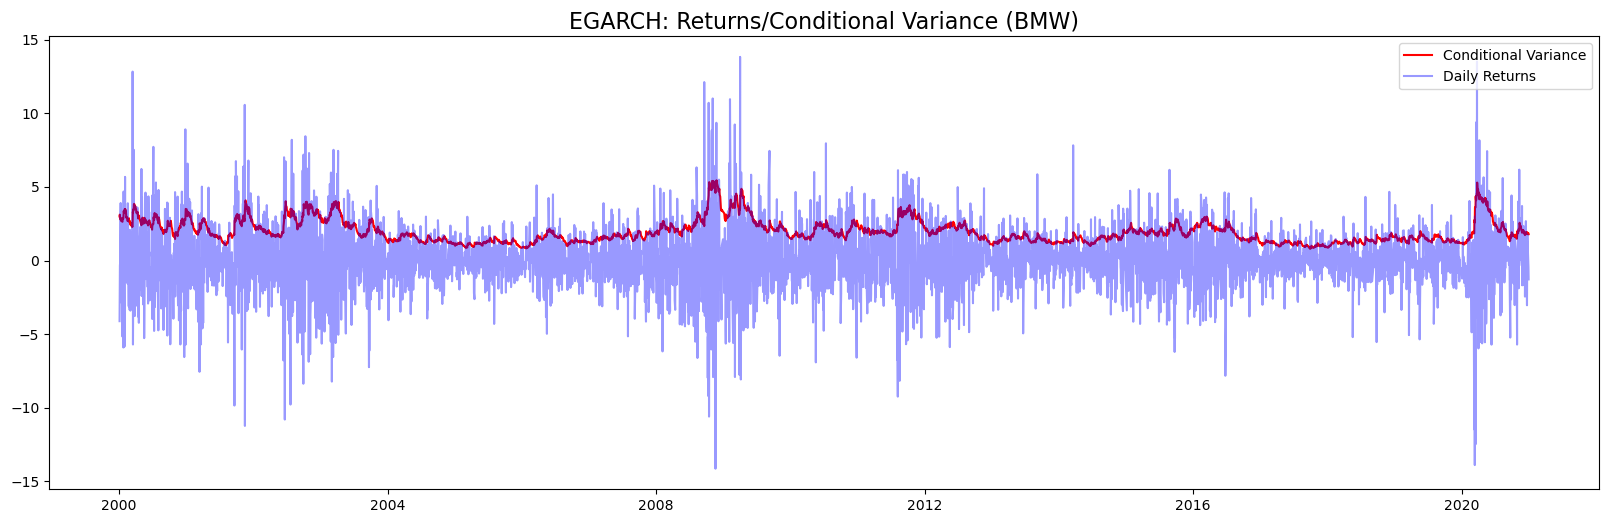

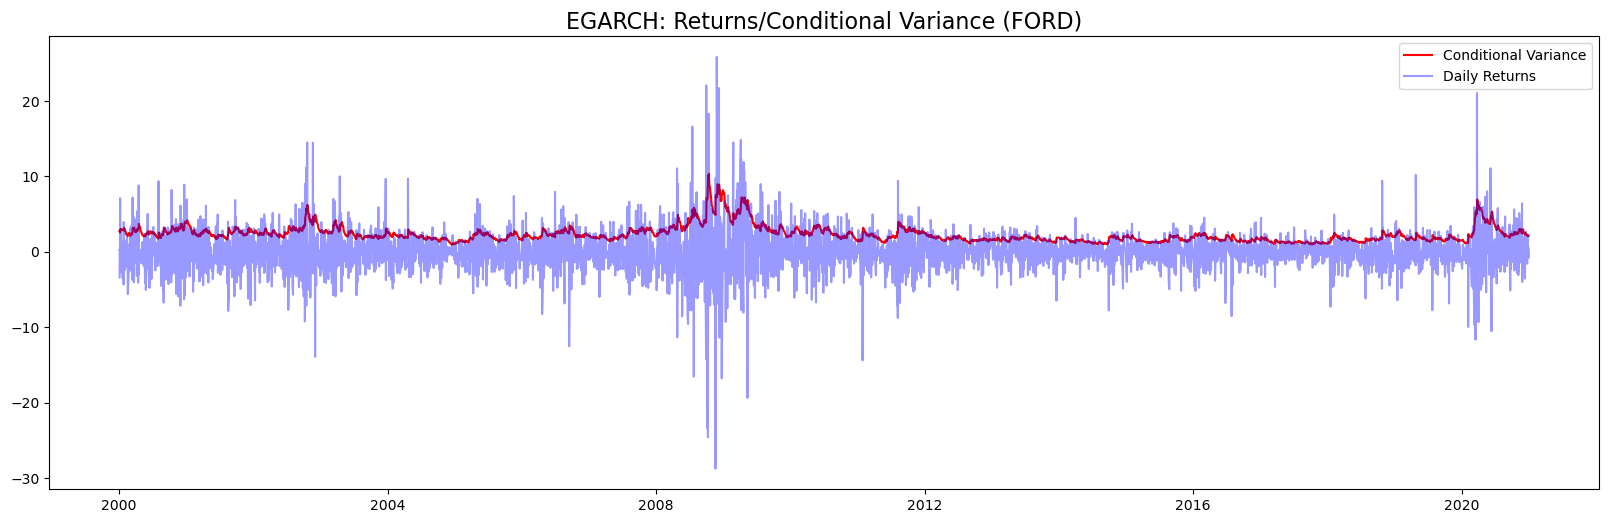

In [58]:
# Ploting Returns/Conditional Variance

## BMW
figure(figsize=(20, 6), dpi=100)
plt.plot(EGARCH_vol_BMW, color = 'red', label = 'Conditional Variance')
plt.plot(BMW_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('EGARCH: Returns/Conditional Variance (BMW)', fontsize=16)
plt.show()

## FORD
figure(figsize=(20, 6), dpi=100)
plt.plot(EGARCH_vol_F, color = 'red', label = 'Conditional Variance')
plt.plot(F_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('EGARCH: Returns/Conditional Variance (FORD)', fontsize=16)
plt.show()

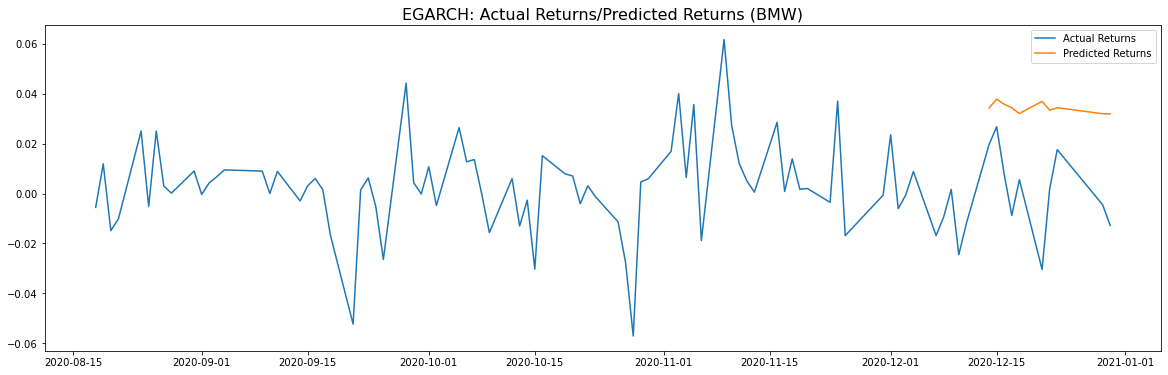

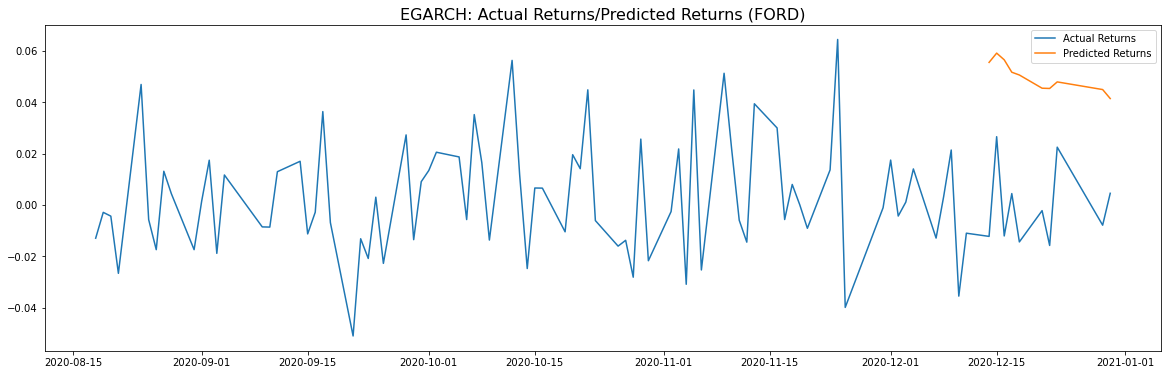

In [59]:
# Ploting Actual Returns/Predicted Returns 

## BMW
plt.figure(figsize=(20, 6))
plt.plot(BMW_RET.iloc[-len(BMW_90):] / 100, label='Actual Returns')
plt.plot(Forecast_EGARCH_BMW.variance.iloc[-len(BMW_10):] / 100,
        label='Predicted Returns')
plt.title('EGARCH: Actual Returns/Predicted Returns (BMW)', fontsize=16)
plt.legend()
plt.show()

## FORD
plt.figure(figsize=(20, 6))
plt.plot(F_RET.iloc[-len(F_90):] / 100, label='Actual Returns')
plt.plot(Forecast_EGARCH_F.variance.iloc[-len(F_10):] / 100,
        label='Predicted Returns')
plt.title('EGARCH: Actual Returns/Predicted Returns (FORD)', fontsize=16)
plt.legend()
plt.show()

#### GJR-GARCH model

##### Deutsche Bank AG

In [60]:
# Specify GARCH model assumptions
GJR_GARCH_DBK = arch_model(DBK_RET, p=1, o=1, q=1, dist = 'normal')

# Fit the model
GJR_GARCH_result_DBK = GJR_GARCH_DBK.fit(update_freq=5, disp="off")

# Get model estimated volatility
GJR_GARCH_vol_DBK = GJR_GARCH_result_DBK.conditional_volatility

# Forecasting
Prediction_GJR_GARCH_DBK = GJR_GARCH_result_DBK.forecast(horizon = 1, start = '2020-12-14')
Forecast_GJR_GARCH_DBK = Prediction_GJR_GARCH_DBK
Forecast_GJR_GARCH_DBK

print(GJR_GARCH_result_DBK.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                Ret_DBK   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -10921.4
Distribution:                  Normal   AIC:                           21852.8
Method:            Maximum Likelihood   BIC:                           21885.4
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:20   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0359  2.608e-02     -1.375      0.169 

In [61]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(DBK_RET[-b:] / 100,
                        np.sqrt(Forecast_GJR_GARCH_DBK\
                                .variance.iloc[-len(DBK_10):]
                                / 100)))
print('The RMSE value of GJR-GARCH model (DBK): {:.4f}'.format(rmse_arch))

The RMSE value of GJR-GARCH model (DBK): 0.2072


##### Bank of America Corp

In [62]:
# Specify GARCH model assumptions
GJR_GARCH_BAC = arch_model(BAC_RET, p=1, o=1, q=1, dist = 'normal')

# Fit the model
GJR_GARCH_result_BAC = GJR_GARCH_BAC.fit(update_freq=5, disp="off")

# Get model estimated volatility
GJR_GARCH_vol_BAC = GJR_GARCH_result_BAC.conditional_volatility

# Forecasting
Prediction_GJR_GARCH_BAC = GJR_GARCH_result_BAC.forecast(horizon = 1, start = '2020-12-14')
Forecast_GJR_GARCH_BAC = Prediction_GJR_GARCH_BAC
Forecast_GJR_GARCH_BAC

print(GJR_GARCH_result_BAC.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                Ret_BAC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -10116.7
Distribution:                  Normal   AIC:                           20243.3
Method:            Maximum Likelihood   BIC:                           20275.9
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:20   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.6621e-03  2.240e-02      0.208      0.835 

In [63]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(BAC_RET[-d:] / 100,
                        np.sqrt(Forecast_GJR_GARCH_BAC\
                                .variance.iloc[-len(BAC_10):]
                                / 100)))
print('The RMSE value of GJR-GARCH model (BAC): {:.4f}'.format(rmse_arch))

The RMSE value of GJR-GARCH model (BAC): 0.1787


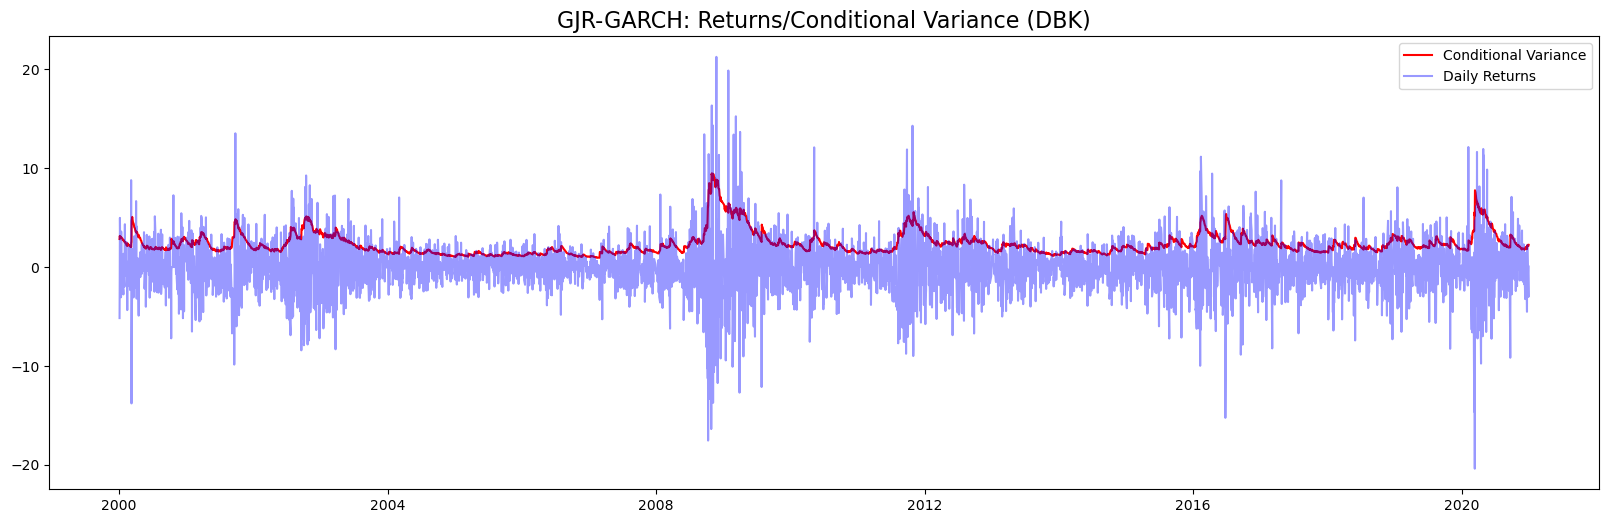

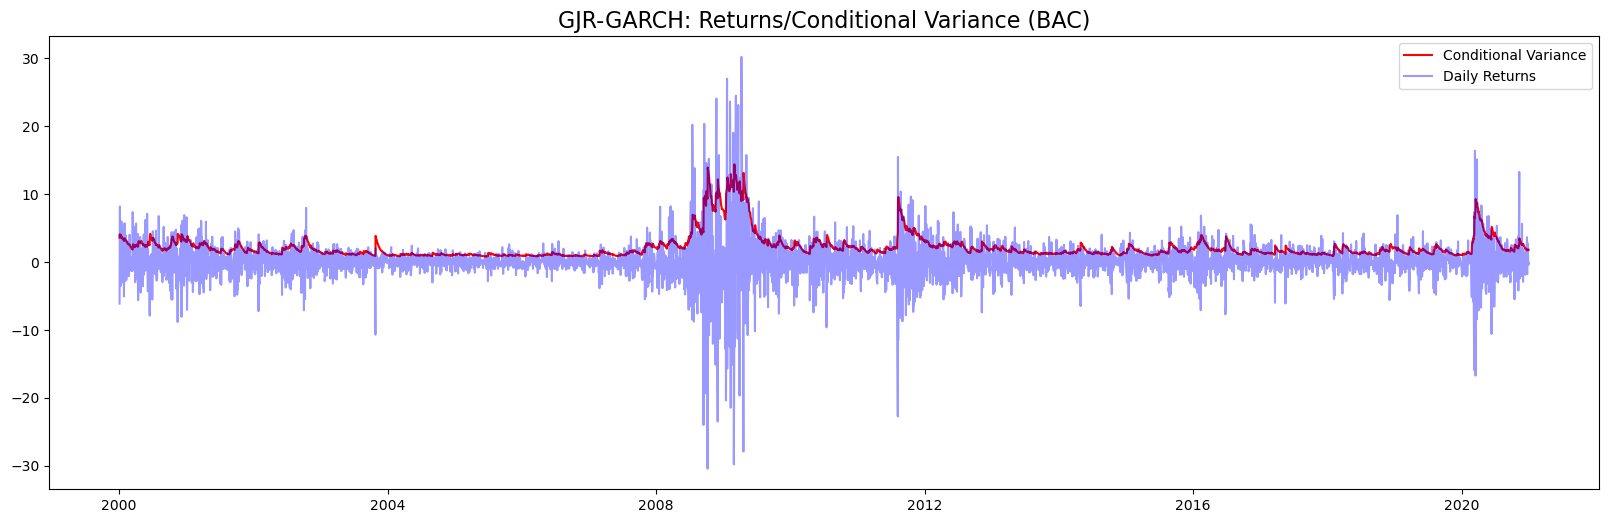

In [64]:
# Ploting Returns/Conditional Variance

## DBK
figure(figsize=(20, 6), dpi=100)
plt.plot(GJR_GARCH_vol_DBK, color = 'red', label = 'Conditional Variance')
plt.plot(DBK_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('GJR-GARCH: Returns/Conditional Variance (DBK)', fontsize=16)
plt.show()

## BAC
figure(figsize=(20, 6), dpi=100)
plt.plot(GJR_GARCH_vol_BAC, color = 'red', label = 'Conditional Variance')
plt.plot(BAC_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('GJR-GARCH: Returns/Conditional Variance (BAC)', fontsize=16)
plt.show()

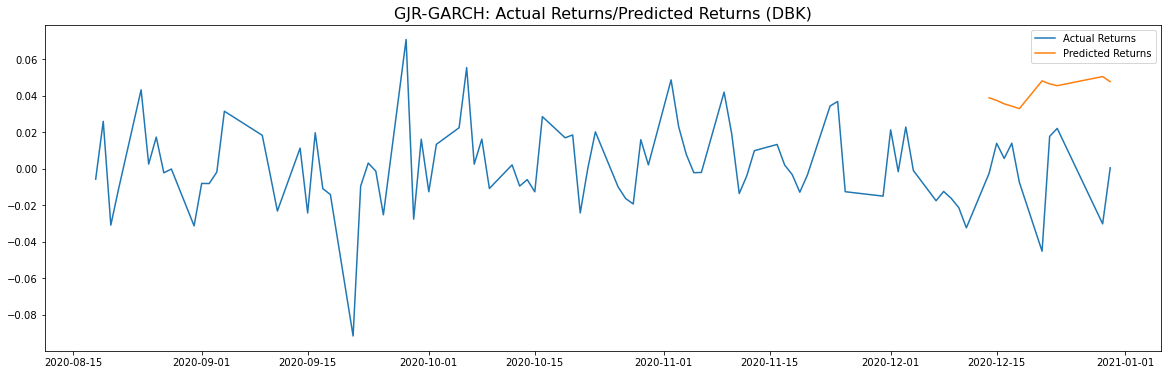

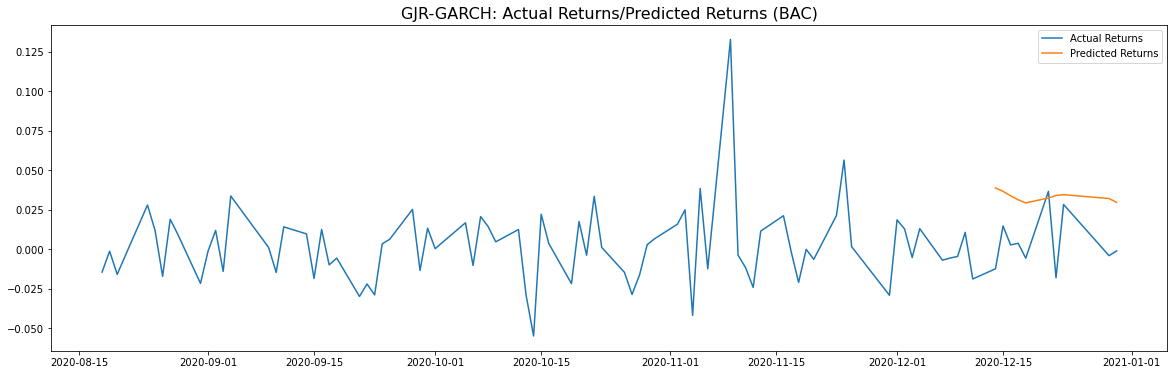

In [65]:
# Ploting Actual Returns/Predicted Returns 

## DBK
plt.figure(figsize=(20, 6))
plt.plot(DBK_RET.iloc[-len(DBK_90):] / 100, label='Actual Returns')
plt.plot(Forecast_GJR_GARCH_DBK.variance.iloc[-len(DBK_10):] / 100,
        label='Predicted Returns')
plt.title('GJR-GARCH: Actual Returns/Predicted Returns (DBK)', fontsize=16)
plt.legend()
plt.show()

## BAC
plt.figure(figsize=(20, 6))
plt.plot(BAC_RET.iloc[-len(BAC_90):] / 100, label='Actual Returns')
plt.plot(Forecast_GJR_GARCH_BAC.variance.iloc[-len(BAC_10):] / 100,
        label='Predicted Returns')
plt.title('GJR-GARCH: Actual Returns/Predicted Returns (BAC)', fontsize=16)
plt.legend()
plt.show()

##### BMW

In [66]:
# Specify GARCH model assumptions
GJR_GARCH_BMW = arch_model(BMW_RET, p=1, o=1, q=1, dist = 'normal')

# Fit the model
GJR_GARCH_result_BMW = GJR_GARCH_BMW.fit(update_freq=5, disp="off")

# Get model estimated volatility
GJR_GARCH_vol_BMW = GJR_GARCH_result_BMW.conditional_volatility

# Forecasting
Prediction_GJR_GARCH_BMW = GJR_GARCH_result_BMW.forecast(horizon = 1, start = '2020-12-14')
Forecast_GJR_GARCH_BMW = Prediction_GJR_GARCH_BMW
Forecast_GJR_GARCH_BMW

print(GJR_GARCH_result_BMW.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                Ret_BMW   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -10085.6
Distribution:                  Normal   AIC:                           20181.2
Method:            Maximum Likelihood   BIC:                           20213.8
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:22   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.6091e-03  2.275e-02      0.159      0.874 

In [67]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(BMW_RET[-f:] / 100,
                        np.sqrt(Forecast_GJR_GARCH_BMW\
                                .variance.iloc[-len(BMW_10):]
                                / 100)))
print('The RMSE value of GJR-GARCH model (BMW): {:.4f}'.format(rmse_arch))

The RMSE value of GJR-GARCH model (BMW): 0.1722


##### Ford 

In [68]:
# Specify GARCH model assumptions
GJR_GARCH_F = arch_model(F_RET, p=1, o=1, q=1, dist = 'normal')

# Fit the model
GJR_GARCH_result_F = GJR_GARCH_F.fit(update_freq=5, disp="off")

# Get model estimated volatility
GJR_GARCH_vol_F = GJR_GARCH_result_F.conditional_volatility

# Forecasting
Prediction_GJR_GARCH_F = GJR_GARCH_result_F.forecast(horizon = 1, start = '2020-12-14')
Forecast_GJR_GARCH_F = Prediction_GJR_GARCH_F
Forecast_GJR_GARCH_F

print(GJR_GARCH_result_F.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  Ret_F   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -10943.6
Distribution:                  Normal   AIC:                           21897.3
Method:            Maximum Likelihood   BIC:                           21929.8
                                        No. Observations:                 5008
Date:                Thu, Jun 02 2022   Df Residuals:                     5007
Time:                        23:44:22   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.0540  2.744e-02     -1.967  4.920e-02 [ -0.1

In [69]:
# Calculate the RMSE
rmse_arch = np.sqrt(mse(F_RET[-h:] / 100,
                        np.sqrt(Forecast_GJR_GARCH_F\
                                .variance.iloc[-len(F_10):]
                                / 100)))
print('The RMSE value of GJR-GARCH model (FORD): {:.4f}'.format(rmse_arch))

The RMSE value of GJR-GARCH model (FORD): 0.2156


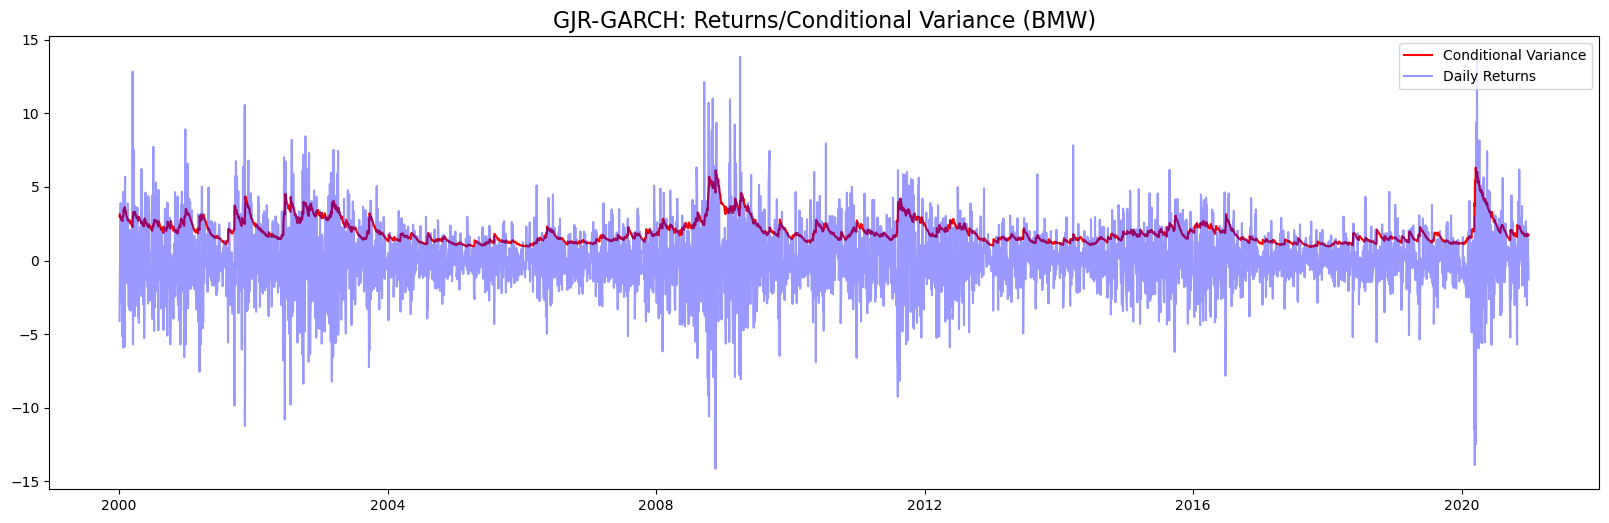

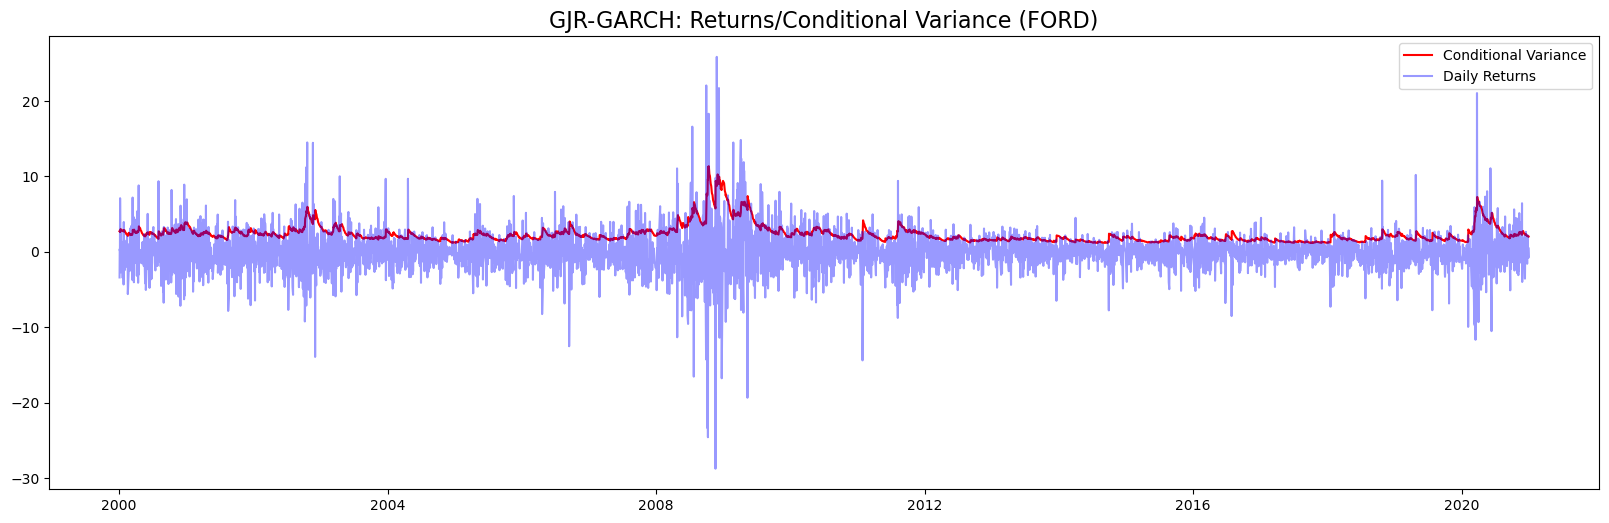

In [70]:
# Ploting Returns/Conditional Variance

## BMW
figure(figsize=(20, 6), dpi=100)
plt.plot(GJR_GARCH_vol_BMW, color = 'red', label = 'Conditional Variance')
plt.plot(BMW_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('GJR-GARCH: Returns/Conditional Variance (BMW)', fontsize=16)
plt.show()

## FORD
figure(figsize=(20, 6), dpi=100)
plt.plot(GJR_GARCH_vol_F, color = 'red', label = 'Conditional Variance')
plt.plot(F_RET, color = 'blue', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.title('GJR-GARCH: Returns/Conditional Variance (FORD)', fontsize=16)
plt.show()

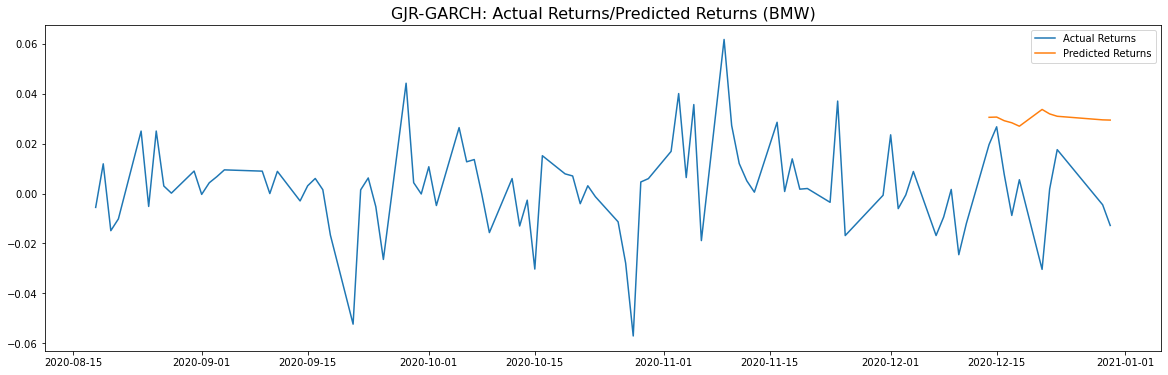

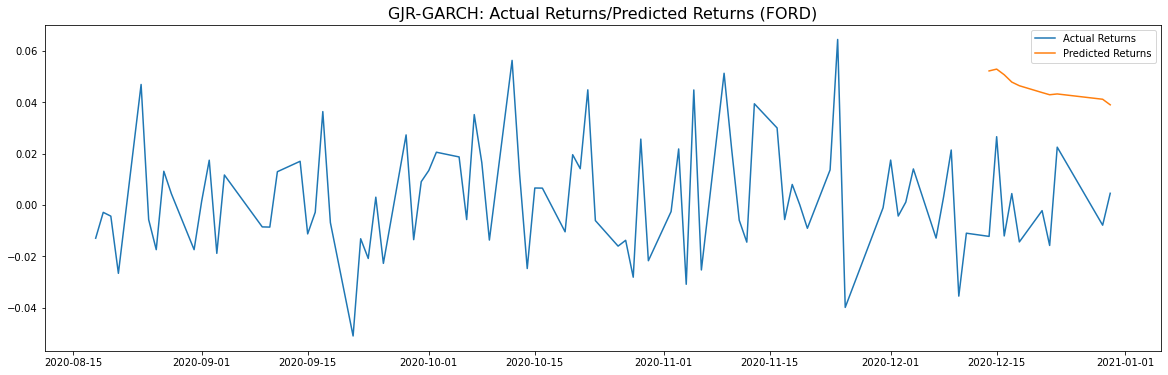

In [71]:
# Ploting Actual Returns/Predicted Returns 

## BMW
plt.figure(figsize=(20, 6))
plt.plot(BMW_RET.iloc[-len(BMW_90):] / 100, label='Actual Returns')
plt.plot(Forecast_GJR_GARCH_BMW.variance.iloc[-len(BMW_10):] / 100,
        label='Predicted Returns')
plt.title('GJR-GARCH: Actual Returns/Predicted Returns (BMW)', fontsize=16)
plt.legend()
plt.show()

## FORD
plt.figure(figsize=(20, 6))
plt.plot(F_RET.iloc[-len(F_90):] / 100, label='Actual Returns')
plt.plot(Forecast_GJR_GARCH_F.variance.iloc[-len(F_10):] / 100,
        label='Predicted Returns')
plt.title('GJR-GARCH: Actual Returns/Predicted Returns (FORD)', fontsize=16)
plt.legend()
plt.show()

### Data Science models

#### LSTM 

##### Deutsche Bank AG

In [73]:
# transform a time series dataset into a supervised learning dataset (Input : Output)

## Adjust time format 
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2001-01-04')

## Create a function 
def DBK_to_windowed_DBK(DBK_RET, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)
    
    target_date = first_date
    
    dates_DBK = []
    X, Y = [], []
    
    last_time = False
    while True:
        DBK_subset = DBK_RET.loc[:target_date].tail(n+1)
        
        if len(DBK_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        values = DBK_subset['Ret_DBK'].to_numpy()
        x, y = values[:-1], values[-1]
        
        dates_DBK.append(target_date)
        X.append(x)
        Y.append(y)
        
        next_week = DBK_RET.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        if last_time:
            break
        
        target_date = next_date
        
        if target_date == last_date:
            last_time = True
    ret_DBK = pd.DataFrame({})
    ret_DBK['Target Date'] = dates_DBK
    
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_DBK[f'Target-{n-i}'] = X[:, i]
        
    ret_DBK['Target'] = Y
    
    return ret_DBK

## Start day second time around: '2020-01-03'
windowed_DBK = DBK_to_windowed_DBK(DBK_RET, 
                                '2020-01-03', 
                                '2020-12-30', 
                                n=3)
windowed_DBK.head(n=10)

Target Date  Target-3  Target-2  Target-1    Target
0  2020-01-03 -0.761316 -2.275915  0.159150 -1.329061
1  2020-01-06 -2.275915  0.159150 -1.329061 -0.900596
2  2020-01-07  0.159150 -1.329061 -0.900596  3.406856
3  2020-01-08 -1.329061 -0.900596  3.406856  3.320630
4  2020-01-09 -0.900596  3.406856  3.320630  0.402574
5  2020-01-10  3.406856  3.320630  0.402574 -0.272532
6  2020-01-13  3.320630  0.402574 -0.272532 -1.505760
7  2020-01-14  0.402574 -0.272532 -1.505760  2.256665
8  2020-01-15 -0.272532 -1.505760  2.256665 -2.388675
9  2020-01-16 -1.505760  2.256665 -2.388675  0.776371

In [74]:
#Convert our new dataset into numpy arrays (to feed it directly into a tensorflow model)
def windowed_DBK_to_date_X_y(windowed_dataframe):
    DBK_as_np = windowed_dataframe.to_numpy()
    
    dates_DBK = DBK_as_np[:, 0] 
    
    middle_matrix = DBK_as_np[:, 1:-1]
    X_DBK = middle_matrix.reshape((len(dates_DBK), middle_matrix.shape[1], 1))
    
    Y_DBK = DBK_as_np[:, -1]
    
    return dates_DBK, X_DBK.astype(np.float32), Y_DBK.astype(np.float32)

dates_DBK, X_DBK, y_DBK = windowed_DBK_to_date_X_y(windowed_DBK)

dates_DBK.shape, X_DBK.shape, y_DBK.shape

((237,), (237, 3, 1), (237,))

In [75]:
# Split the data into training, validation and testing partitions 
q_85_DBK = int(len(dates_DBK) * .85)
q_95_DBK = int(len(dates_DBK) * .95)

dates_train_DBK, X_train_DBK, y_train_DBK = dates_DBK[:q_85_DBK], X_DBK[:q_85_DBK], y_DBK[:q_85_DBK]
dates_val_DBK, X_val_DBK, y_val_DBK = dates_DBK[q_85_DBK:q_95_DBK], X_DBK[q_85_DBK:q_95_DBK], y_DBK[q_85_DBK:q_95_DBK]
dates_test_DBK, X_test_DBK, y_test_DBK = dates_DBK[q_95_DBK:], X_DBK[q_95_DBK:], y_DBK[q_95_DBK:]

In [76]:
# Create & train the LSTM model 
model_DBK = Sequential([layers.Input((3, 1)),
                    layers.LSTM(264),
                    layers.Dense(132, activation='relu'),
                    layers.Dense(132, activation='relu'),
                    layers.Dense(1)])

model_DBK.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# Fitting the LSTM model 
model_DBK.fit(X_train_DBK, y_train_DBK, validation_data=(X_val_DBK, y_val_DBK), epochs=1000)

# Forecasting
train_predictions_DBK = model_DBK.predict(X_train_DBK).flatten()
val_predictions_DBK = model_DBK.predict(X_val_DBK).flatten()
test_predictions_DBK = model_DBK.predict(X_test_DBK).flatten()

2022-06-02 23:44:24.609793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1000
7/7 [==============================] - 4s 122ms/step - loss: 14.7010 - mean_absolute_error: 2.6141 - val_loss: 3.1132 - val_mean_absolute_error: 1.3688
Epoch 2/1000
7/7 [==============================] - 0s 26ms/step - loss: 14.5905 - mean_absolute_error: 2.6062 - val_loss: 3.0840 - val_mean_absolute_error: 1.3528
Epoch 3/1000
7/7 [==============================] - 0s 23ms/step - loss: 14.4811 - mean_absolute_error: 2.5987 - val_loss: 3.0932 - val_mean_absolute_error: 1.3597
Epoch 4/1000
7/7 [==============================] - 0s 25ms/step - loss: 14.3076 - mean_absolute_error: 2.5833 - val_loss: 3.0384 - val_mean_absolute_error: 1.3374
Epoch 5/1000
7/7 [==============================] - 0s 22ms/step - loss: 14.1136 - mean_absolute_error: 2.5686 - val_loss: 2.9454 - val_mean_absolute_error: 1.3032
Epoch 6/1000
7/7 [==============================] - 0s 21ms/step - loss: 13.9088 - mean_absolute_error: 2.5453 - val_loss: 2.8834 - val_mean_absolute_error: 1.2991
Epoch 7/1000
7/

In [77]:
# Calculate the RMSE
rmse_lstm = sqrt(mean_squared_error(y_test_DBK, test_predictions_DBK))
print('The RMSE value of LSTM model (DBK): {:.4f}'.format(rmse_lstm))

The RMSE value of LSTM model (DBK): 2.6075


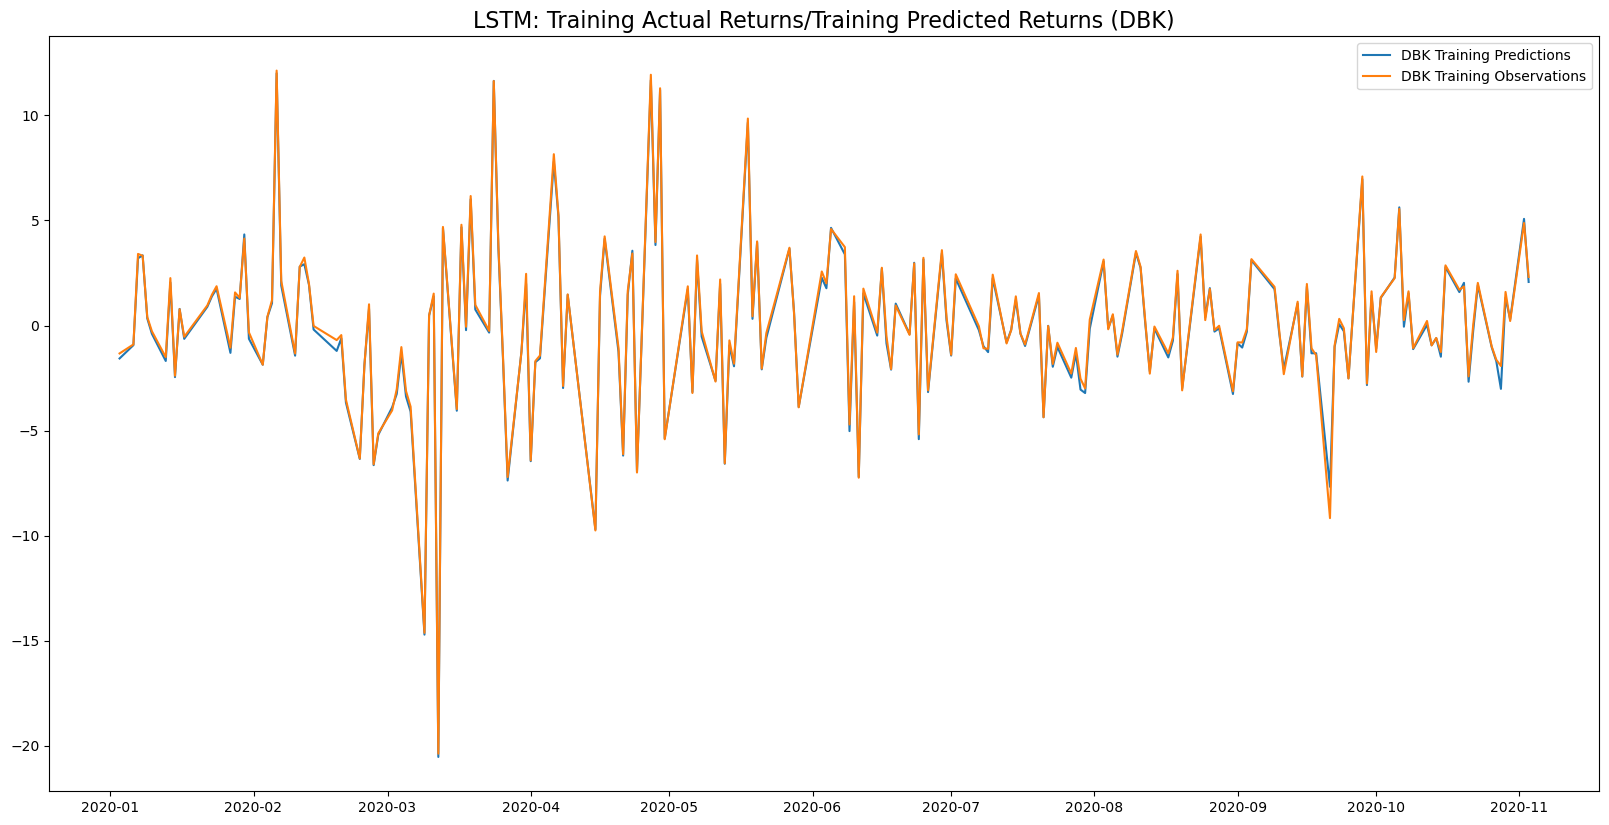

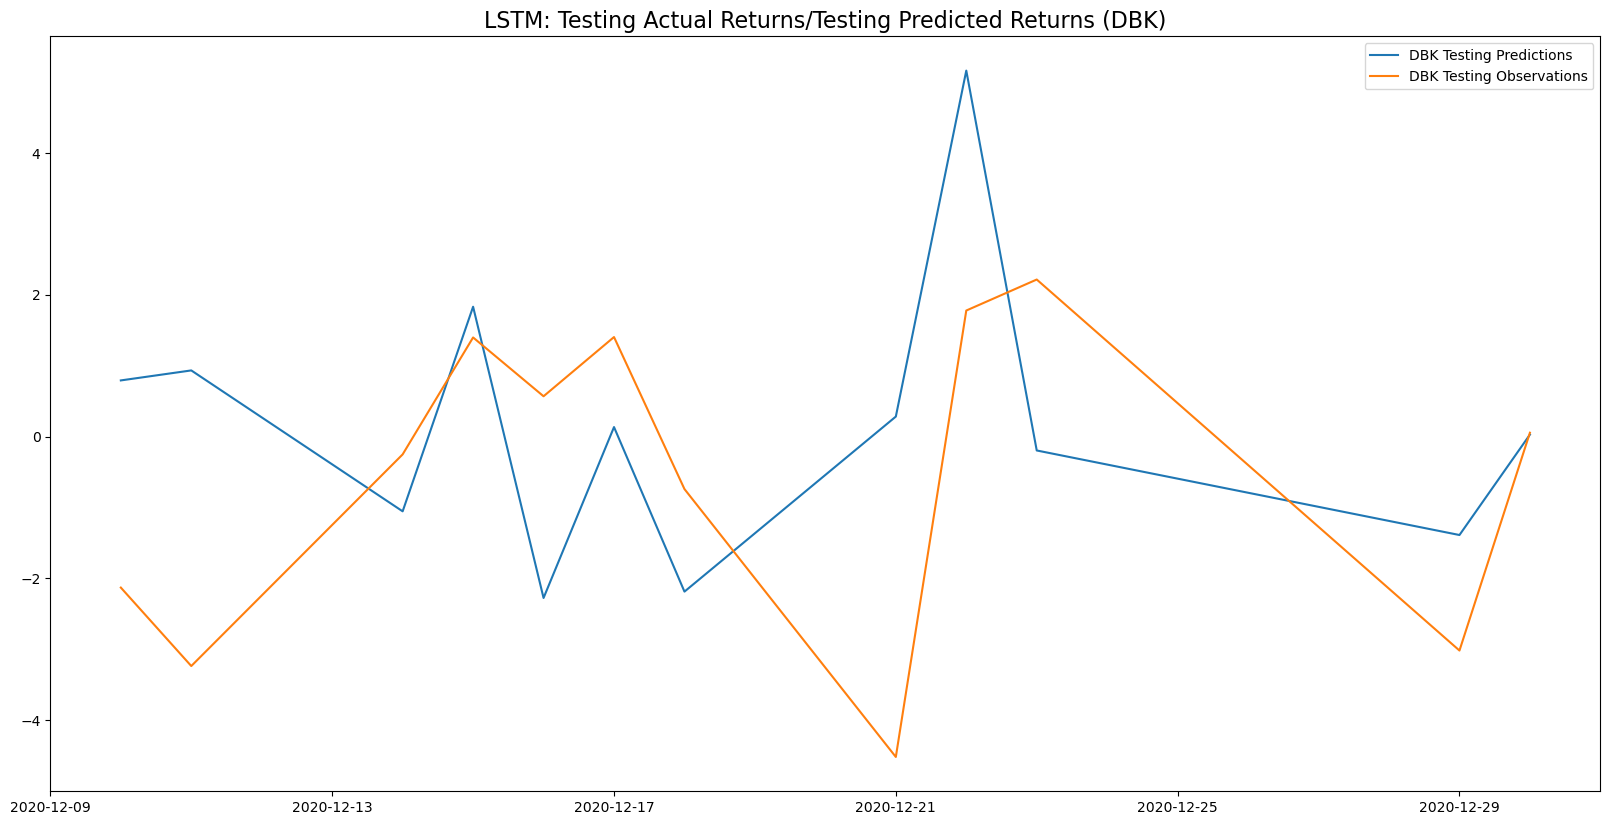

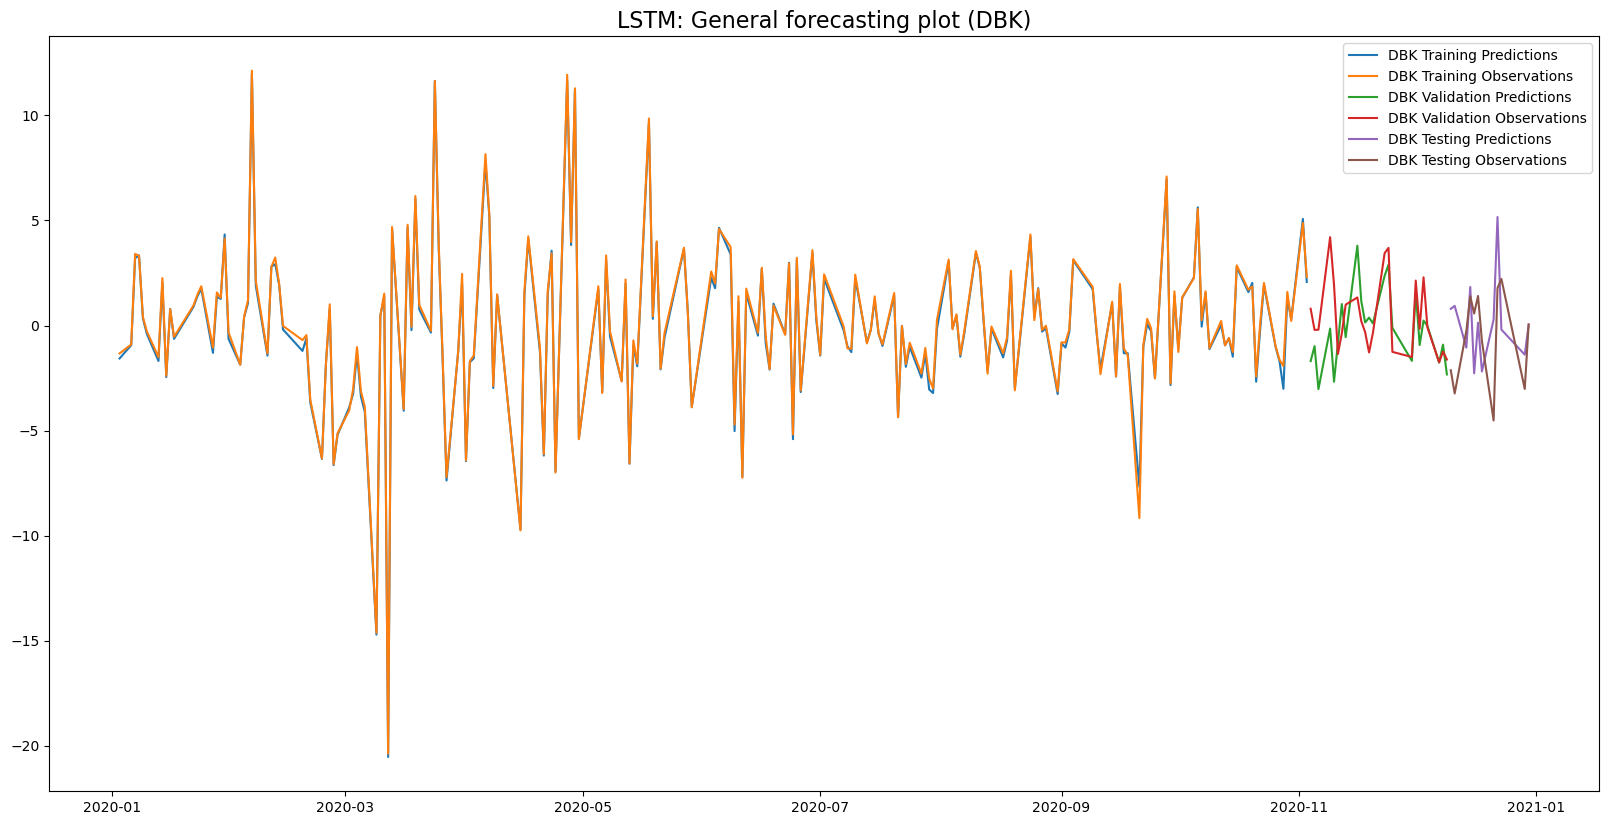

In [78]:
# Plot Training Observations VS Training Predictions 
figure(figsize=(20, 10), dpi=100)
plt.plot(dates_train_DBK, train_predictions_DBK)
plt.plot(dates_train_DBK, y_train_DBK)
plt.title('LSTM: Training Actual Returns/Training Predicted Returns (DBK)', fontsize=16)
plt.legend(['DBK Training Predictions', 'DBK Training Observations'])

# Plot Testing Observations VS Testing Predictions 
figure(figsize=(20, 10), dpi=100)
plt.plot(dates_test_DBK, test_predictions_DBK)
plt.plot(dates_test_DBK, y_test_DBK)
plt.title('LSTM: Testing Actual Returns/Testing Predicted Returns (DBK)', fontsize=16)
plt.legend(['DBK Testing Predictions', 'DBK Testing Observations'])

# General Plot (Training, Validation & testing)
figure(figsize=(20, 10), dpi=100)
plt.plot(dates_train_DBK, train_predictions_DBK)
plt.plot(dates_train_DBK, y_train_DBK)
plt.plot(dates_val_DBK, val_predictions_DBK)
plt.plot(dates_val_DBK, y_val_DBK)
plt.plot(dates_test_DBK, test_predictions_DBK)
plt.plot(dates_test_DBK, y_test_DBK)
plt.title('LSTM: General forecasting plot (DBK)', fontsize=16)
plt.legend(['DBK Training Predictions', 
            'DBK Training Observations',
            'DBK Validation Predictions', 
            'DBK Validation Observations',
            'DBK Testing Predictions', 
            'DBK Testing Observations'])

##### Bank of America Corp

In [79]:
# transform a time series dataset into a supervised learning dataset (Input : Output)
def BAC_to_windowed_BAC(BAC_RET, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)
    
    target_date = first_date
    
    dates_BAC = []
    X, Y = [], []
    
    last_time = False
    while True:
        BAC_subset = BAC_RET.loc[:target_date].tail(n+1)
        
        if len(BAC_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        values = BAC_subset['Ret_BAC'].to_numpy()
        x, y = values[:-1], values[-1]
        
        dates_BAC.append(target_date)
        X.append(x)
        Y.append(y)
        
        next_week = BAC_RET.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        if last_time:
            break
        
        target_date = next_date
        
        if target_date == last_date:
            last_time = True
    ret_BAC = pd.DataFrame({})
    ret_BAC['Target Date'] = dates_BAC
    
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_BAC[f'Target-{n-i}'] = X[:, i]
        
    ret_BAC['Target'] = Y
    
    return ret_BAC

# Start day second time around: '2020-01-03'
windowed_BAC = BAC_to_windowed_BAC(BAC_RET, 
                                '2020-01-03', 
                                '2020-12-30', 
                                n=3)

# Convert our new dataset into numpy arrays (to feed it directly into a tensorflow model)
def windowed_BAC_to_date_X_y(windowed_dataframe):
    BAC_as_np = windowed_dataframe.to_numpy()
    
    dates_BAC = BAC_as_np[:, 0] 
    
    middle_matrix_BAC = BAC_as_np[:, 1:-1]
    X_BAC = middle_matrix_BAC.reshape((len(dates_BAC), middle_matrix_BAC.shape[1], 1))
    
    Y_BAC = BAC_as_np[:, -1]
    
    return dates_BAC, X_BAC.astype(np.float32), Y_BAC.astype(np.float32)

dates_BAC, X_BAC, y_BAC = windowed_BAC_to_date_X_y(windowed_BAC)

# Split the data into training, validation and testing partitions 
q_85_BAC = int(len(dates_BAC) * .85)
q_95_BAC = int(len(dates_BAC) * .95)

dates_train_BAC, X_train_BAC, y_train_BAC = dates_BAC[:q_85_BAC], X_BAC[:q_85_BAC], y_BAC[:q_85_BAC]
dates_val_BAC, X_val_BAC, y_val_BAC = dates_BAC[q_85_BAC:q_95_BAC], X_BAC[q_85_BAC:q_95_BAC], y_BAC[q_85_BAC:q_95_BAC]
dates_test_BAC, X_test_BAC, y_test_BAC = dates_BAC[q_95_BAC:], X_BAC[q_95_BAC:], y_BAC[q_95_BAC:]

# Create & train the LSTM model 
model_BAC = Sequential([layers.Input((3, 1)),
                    layers.LSTM(264),
                    layers.Dense(132, activation='relu'),
                    layers.Dense(132, activation='relu'),
                    layers.Dense(1)])

model_BAC.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# Fitting the LSTM model 
model_BAC.fit(X_train_BAC, y_train_BAC, validation_data=(X_val_BAC, y_val_BAC), epochs=1000)

# Forecasting
train_predictions_BAC = model_BAC.predict(X_train_BAC).flatten()
val_predictions_BAC = model_BAC.predict(X_val_BAC).flatten()
test_predictions_BAC = model_BAC.predict(X_test_BAC).flatten()

Epoch 1/1000
7/7 [==============================] - 3s 112ms/step - loss: 14.8813 - mean_absolute_error: 2.6239 - val_loss: 11.5781 - val_mean_absolute_error: 2.0382
Epoch 2/1000
7/7 [==============================] - 0s 27ms/step - loss: 14.6534 - mean_absolute_error: 2.6105 - val_loss: 11.5078 - val_mean_absolute_error: 2.0286
Epoch 3/1000
7/7 [==============================] - 0s 22ms/step - loss: 14.4296 - mean_absolute_error: 2.5985 - val_loss: 11.5756 - val_mean_absolute_error: 2.0346
Epoch 4/1000
7/7 [==============================] - 0s 28ms/step - loss: 14.2191 - mean_absolute_error: 2.5901 - val_loss: 11.6671 - val_mean_absolute_error: 2.0499
Epoch 5/1000
7/7 [==============================] - 0s 26ms/step - loss: 13.9118 - mean_absolute_error: 2.5715 - val_loss: 11.7387 - val_mean_absolute_error: 2.0607
Epoch 6/1000
7/7 [==============================] - 0s 25ms/step - loss: 13.8642 - mean_absolute_error: 2.5603 - val_loss: 11.8101 - val_mean_absolute_error: 2.0657
Epoch 7/1

In [80]:
# Calculate the RMSE
rmse_lstm = sqrt(mean_squared_error(y_test_BAC, test_predictions_BAC))
print('The RMSE value of LSTM model (BAC): {:.4f}'.format(rmse_lstm))

The RMSE value of LSTM model (BAC): 1.8953


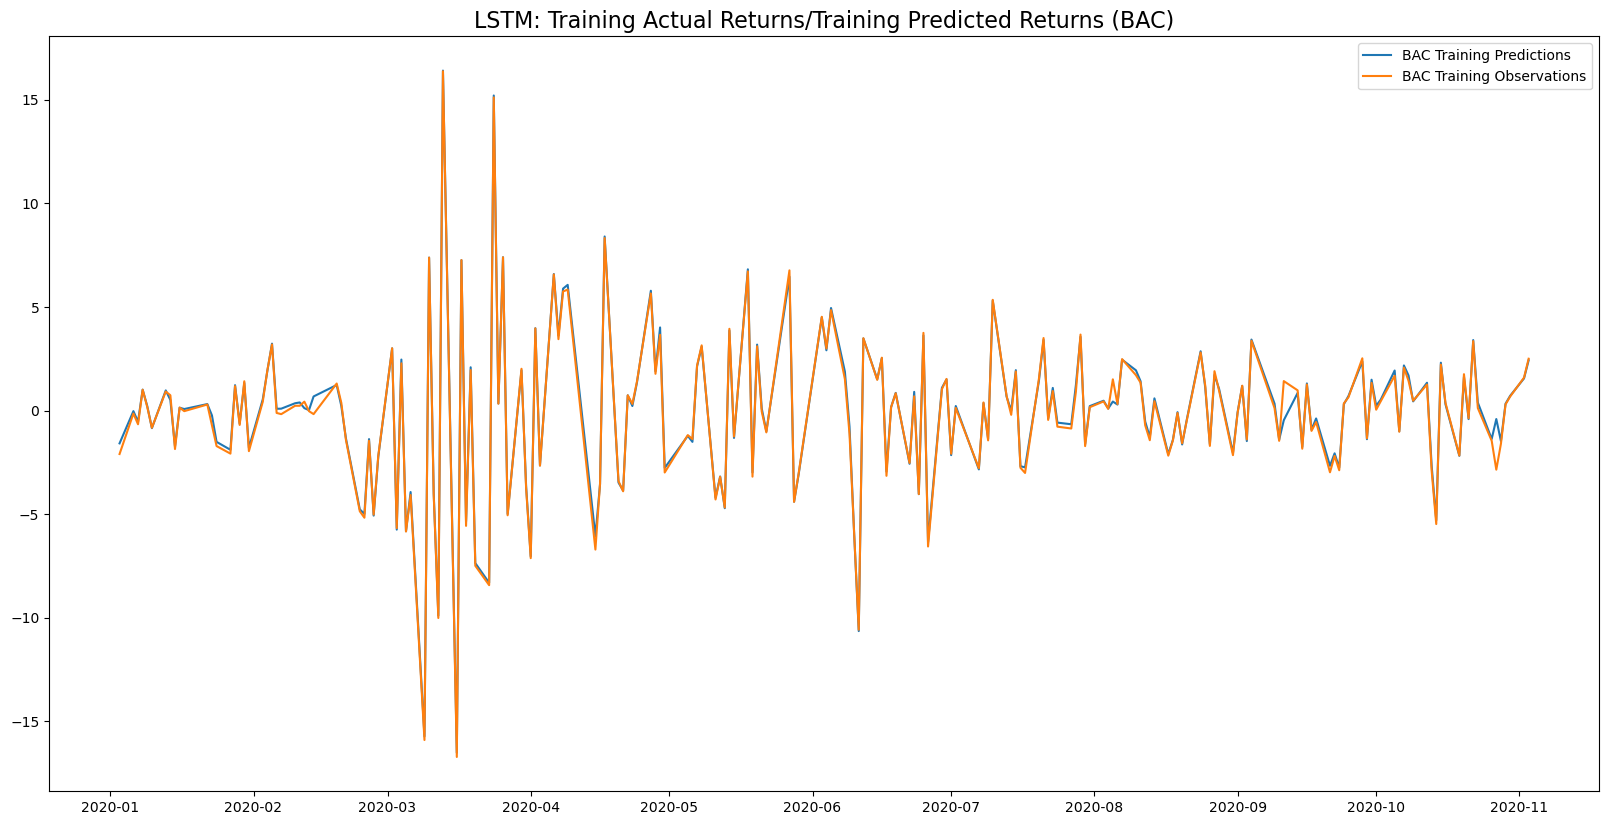

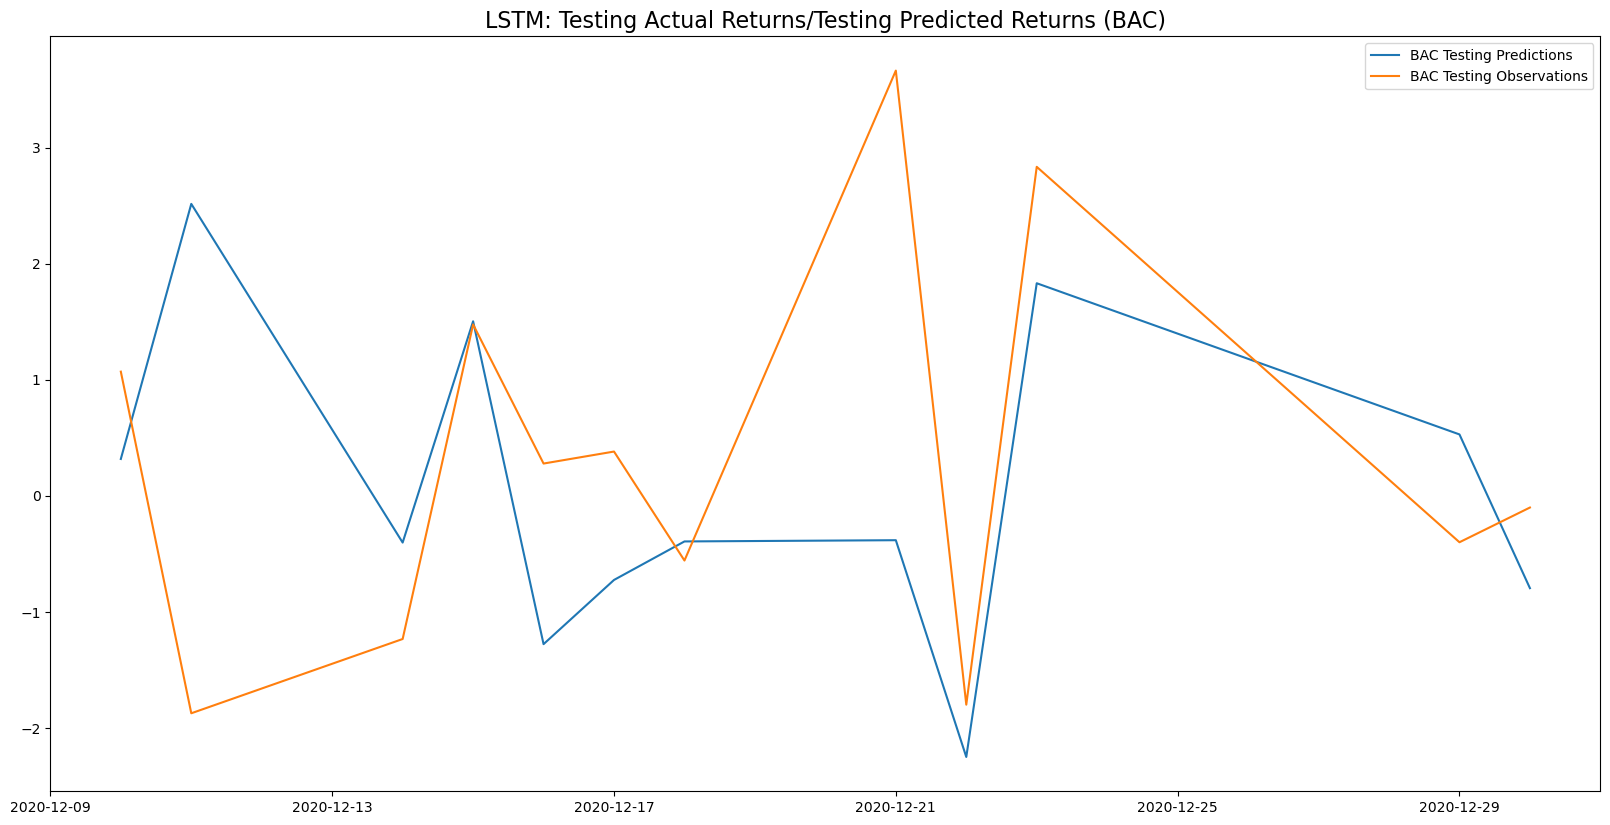

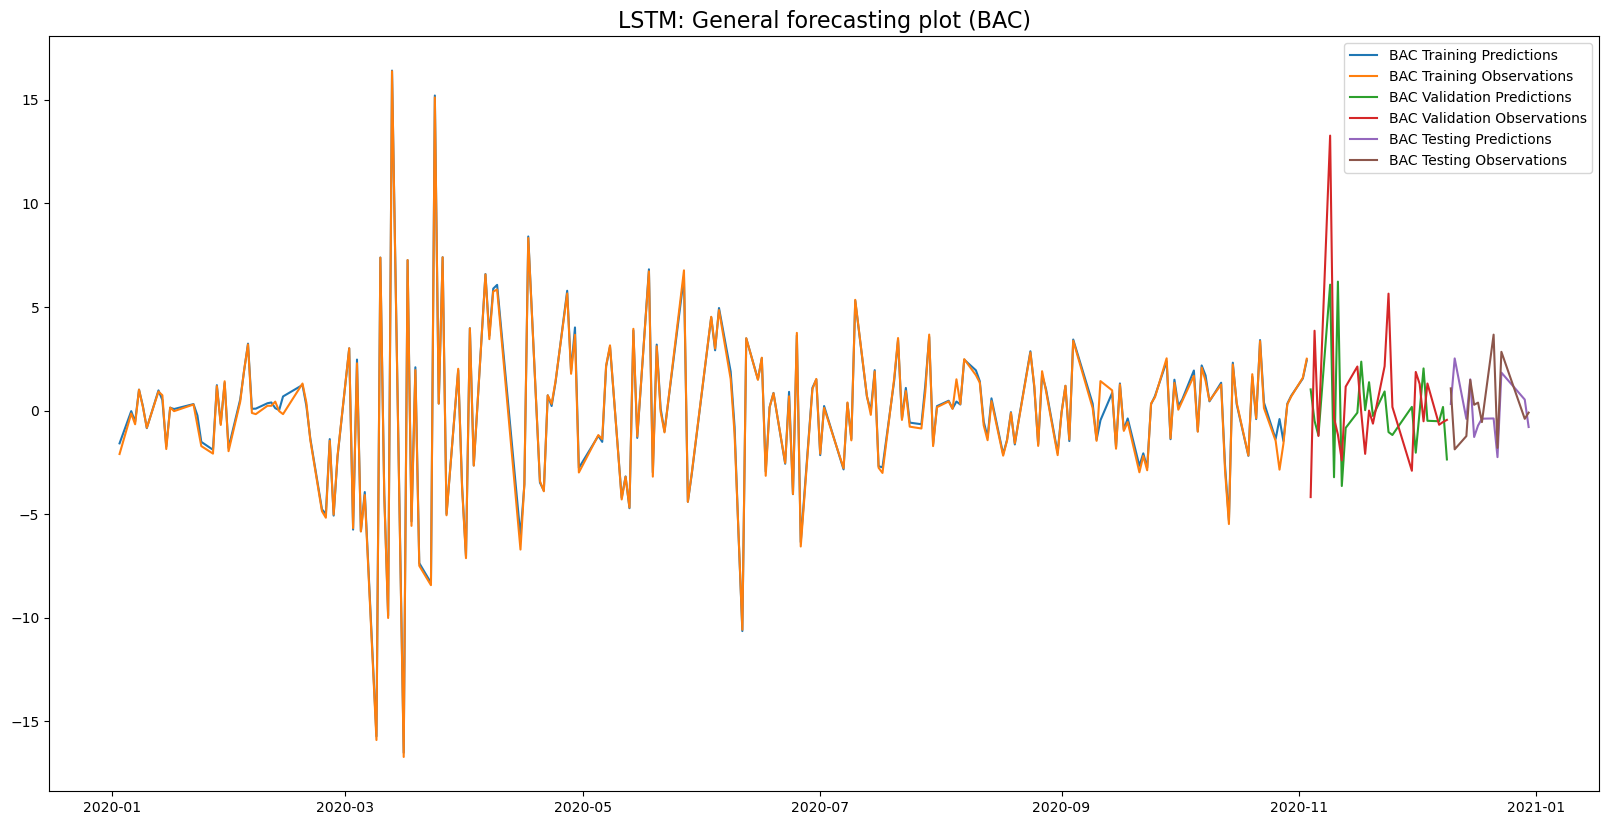

In [81]:
# Plot Training Observations VS Training Predictions 
figure(figsize=(20, 10), dpi=100)
plt.plot(dates_train_BAC, train_predictions_BAC)
plt.plot(dates_train_BAC, y_train_BAC)
plt.title('LSTM: Training Actual Returns/Training Predicted Returns (BAC)', fontsize=16)
plt.legend(['BAC Training Predictions', 'BAC Training Observations'])

# Plot Testing Observations VS Testing Predictions 
figure(figsize=(20, 10), dpi=100)
plt.plot(dates_test_BAC, test_predictions_BAC)
plt.plot(dates_test_BAC, y_test_BAC)
plt.title('LSTM: Testing Actual Returns/Testing Predicted Returns (BAC)', fontsize=16)
plt.legend(['BAC Testing Predictions', 'BAC Testing Observations'])

# General Plot (Training, Validation & testing)
figure(figsize=(20, 10), dpi=100)
plt.plot(dates_train_BAC, train_predictions_BAC)
plt.plot(dates_train_BAC, y_train_BAC)
plt.plot(dates_val_BAC, val_predictions_BAC)
plt.plot(dates_val_BAC, y_val_BAC)
plt.plot(dates_test_BAC, test_predictions_BAC)
plt.plot(dates_test_BAC, y_test_BAC)
plt.title('LSTM: General forecasting plot (BAC)', fontsize=16)
plt.legend(['BAC Training Predictions', 
            'BAC Training Observations',
            'BAC Validation Predictions', 
            'BAC Validation Observations',
            'BAC Testing Predictions', 
            'BAC Testing Observations'])

##### BMW

In [82]:
# transform a time series dataset into a supervised learning dataset (Input : Output)
def BMW_to_windowed_BMW(BMW_RET, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)
    
    target_date = first_date
    
    dates_BMW = []
    X, Y = [], []
    
    last_time = False
    while True:
        BMW_subset = BMW_RET.loc[:target_date].tail(n+1)
        
        if len(BMW_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        values = BMW_subset['Ret_BMW'].to_numpy()
        x, y = values[:-1], values[-1]
        
        dates_BMW.append(target_date)
        X.append(x)
        Y.append(y)
        
        next_week = BMW_RET.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        if last_time:
            break
        
        target_date = next_date
        
        if target_date == last_date:
            last_time = True
    ret_BMW = pd.DataFrame({})
    ret_BMW['Target Date'] = dates_BMW
    
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_BMW[f'Target-{n-i}'] = X[:, i]
        
    ret_BMW['Target'] = Y
    
    return ret_BMW

# Start day second time around: '2020-01-03'
windowed_BMW = BMW_to_windowed_BMW(BMW_RET, 
                                '2020-01-03', 
                                '2020-12-30', 
                                n=3)

# Convert our new dataset into numpy arrays (to feed it directly into a tensorflow model)
def windowed_BMW_to_date_X_y(windowed_dataframe):
    BMW_as_np = windowed_dataframe.to_numpy()
    
    dates_BMW = BMW_as_np[:, 0] 
    
    middle_matrix_BMW = BMW_as_np[:, 1:-1]
    X_BMW = middle_matrix_BMW.reshape((len(dates_BMW), middle_matrix_BMW.shape[1], 1))
    
    Y_BMW = BMW_as_np[:, -1]
    
    return dates_BMW, X_BMW.astype(np.float32), Y_BMW.astype(np.float32)

dates_BMW, X_BMW, y_BMW = windowed_BMW_to_date_X_y(windowed_BMW)

# Split the data into training, validation and testing partitions 
q_85_BMW = int(len(dates_BMW) * .85)
q_95_BMW = int(len(dates_BMW) * .95)

dates_train_BMW, X_train_BMW, y_train_BMW = dates_BMW[:q_85_BMW], X_BMW[:q_85_BMW], y_BMW[:q_85_BMW]
dates_val_BMW, X_val_BMW, y_val_BMW = dates_BMW[q_85_BMW:q_95_BMW], X_BMW[q_85_BMW:q_95_BMW], y_BMW[q_85_BMW:q_95_BMW]
dates_test_BMW, X_test_BMW, y_test_BMW = dates_BMW[q_95_BMW:], X_BMW[q_95_BMW:], y_BMW[q_95_BMW:]

# Create & train the LSTM model 
model_BMW = Sequential([layers.Input((3, 1)),
                    layers.LSTM(264),
                    layers.Dense(132, activation='relu'),
                    layers.Dense(132, activation='relu'),
                    layers.Dense(1)])

model_BMW.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# Fitting the LSTM model 
model_BMW.fit(X_train_BMW, y_train_BMW, validation_data=(X_val_BMW, y_val_BMW), epochs=1000)

# Forecasting
train_predictions_BMW = model_BMW.predict(X_train_BMW).flatten()
val_predictions_BMW = model_BMW.predict(X_val_BMW).flatten()
test_predictions_BMW = model_BMW.predict(X_test_BMW).flatten()

Epoch 1/1000
7/7 [==============================] - 3s 110ms/step - loss: 9.2244 - mean_absolute_error: 2.0078 - val_loss: 4.1963 - val_mean_absolute_error: 1.4144
Epoch 2/1000
7/7 [==============================] - 0s 30ms/step - loss: 9.1848 - mean_absolute_error: 2.0069 - val_loss: 4.4034 - val_mean_absolute_error: 1.4704
Epoch 3/1000
7/7 [==============================] - 0s 25ms/step - loss: 9.1018 - mean_absolute_error: 1.9936 - val_loss: 4.4094 - val_mean_absolute_error: 1.4801
Epoch 4/1000
7/7 [==============================] - 0s 25ms/step - loss: 9.0437 - mean_absolute_error: 1.9896 - val_loss: 4.3704 - val_mean_absolute_error: 1.4788
Epoch 5/1000
7/7 [==============================] - 0s 22ms/step - loss: 8.9346 - mean_absolute_error: 1.9820 - val_loss: 4.3977 - val_mean_absolute_error: 1.4899
Epoch 6/1000
7/7 [==============================] - 0s 23ms/step - loss: 8.8733 - mean_absolute_error: 1.9855 - val_loss: 4.5701 - val_mean_absolute_error: 1.5347
Epoch 7/1000
7/7 [===

In [83]:
# Calculate the RMSE
rmse_lstm = sqrt(mean_squared_error(y_test_BMW, test_predictions_BMW))
print('The RMSE value of LSTM model (BMW): {:.4f}'.format(rmse_lstm))

The RMSE value of LSTM model (BMW): 2.5942


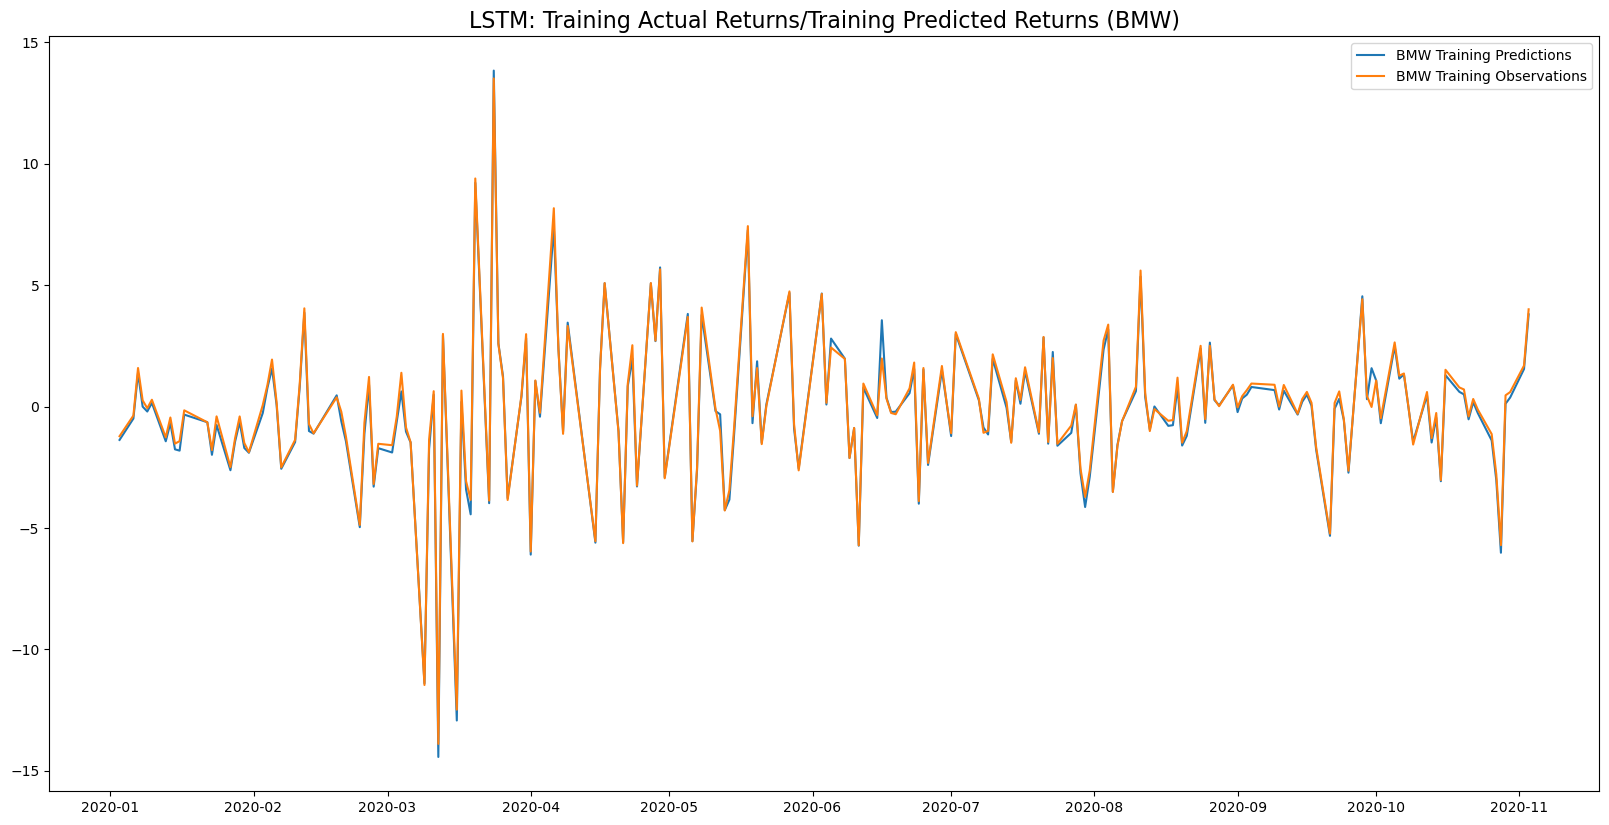

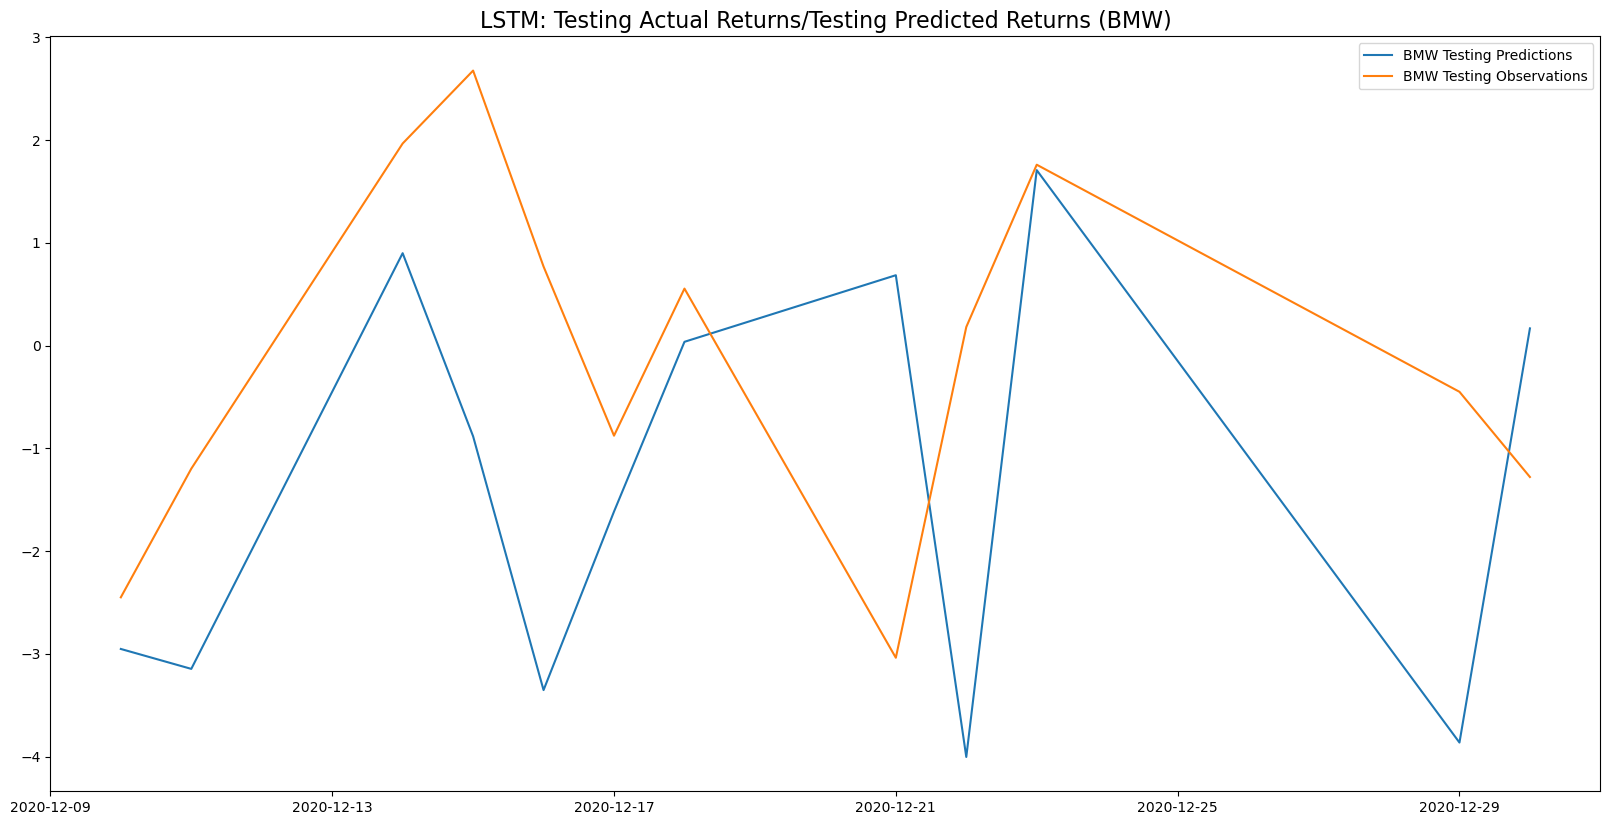

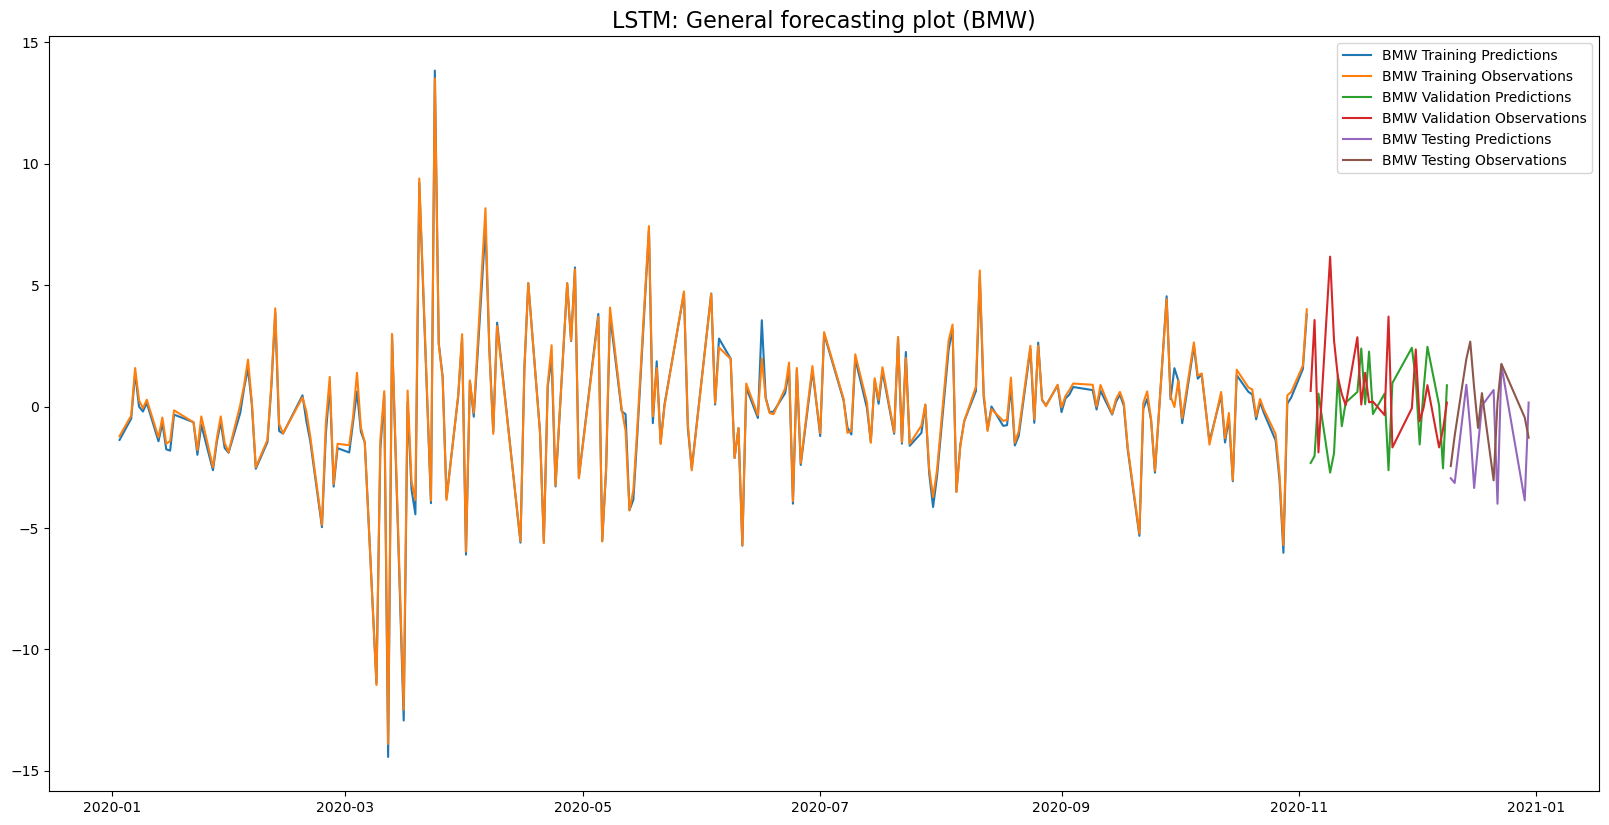

In [84]:
# Plot Training Observations VS Training Predictions 
figure(figsize=(20, 10), dpi=100)
plt.plot(dates_train_BMW, train_predictions_BMW)
plt.plot(dates_train_BMW, y_train_BMW)
plt.title('LSTM: Training Actual Returns/Training Predicted Returns (BMW)', fontsize=16)
plt.legend(['BMW Training Predictions', 'BMW Training Observations'])

# Plot Testing Observations VS Testing Predictions 
figure(figsize=(20, 10), dpi=100)
plt.plot(dates_test_BMW, test_predictions_BMW)
plt.plot(dates_test_BMW, y_test_BMW)
plt.title('LSTM: Testing Actual Returns/Testing Predicted Returns (BMW)', fontsize=16)
plt.legend(['BMW Testing Predictions', 'BMW Testing Observations'])

# General Plot (Training, Validation & testing)
figure(figsize=(20, 10), dpi=100)
plt.plot(dates_train_BMW, train_predictions_BMW)
plt.plot(dates_train_BMW, y_train_BMW)
plt.plot(dates_val_BMW, val_predictions_BMW)
plt.plot(dates_val_BMW, y_val_BMW)
plt.plot(dates_test_BMW, test_predictions_BMW)
plt.plot(dates_test_BMW, y_test_BMW)
plt.title('LSTM: General forecasting plot (BMW)', fontsize=16)
plt.legend(['BMW Training Predictions', 
            'BMW Training Observations',
            'BMW Validation Predictions', 
            'BMW Validation Observations',
            'BMW Testing Predictions', 
            'BMW Testing Observations'])

##### Ford 

In [85]:
# transform a time series dataset into a supervised learning dataset (Input : Output)
def F_to_windowed_F(F_RET, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)
    
    target_date = first_date
    
    dates_F = []
    X, Y = [], []
    
    last_time = False
    while True:
        F_subset = F_RET.loc[:target_date].tail(n+1)
        
        if len(F_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        values = F_subset['Ret_F'].to_numpy()
        x, y = values[:-1], values[-1]
        
        dates_F.append(target_date)
        X.append(x)
        Y.append(y)
        
        next_week = F_RET.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        if last_time:
            break
        
        target_date = next_date
        
        if target_date == last_date:
            last_time = True
    ret_F = pd.DataFrame({})
    ret_F['Target Date'] = dates_F
    
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_F[f'Target-{n-i}'] = X[:, i]
        
    ret_F['Target'] = Y
    
    return ret_F

# Start day second time around: '2020-01-03'
windowed_F = F_to_windowed_F(F_RET, 
                                '2020-01-03', 
                                '2020-12-30', 
                                n=3)

# Convert our new dataset into numpy arrays (to feed it directly into a tensorflow model)
def windowed_F_to_date_X_y(windowed_dataframe):
    F_as_np = windowed_dataframe.to_numpy()
    
    dates_F = F_as_np[:, 0] 
    
    middle_matrix_F = F_as_np[:, 1:-1]
    X_F = middle_matrix_F.reshape((len(dates_F), middle_matrix_F.shape[1], 1))
    
    Y_F = F_as_np[:, -1]
    
    return dates_F, X_F.astype(np.float32), Y_F.astype(np.float32)

dates_F, X_F, y_F = windowed_F_to_date_X_y(windowed_F)

# Split the data into training, validation and testing partitions 
q_85_F = int(len(dates_F) * .85)
q_95_F = int(len(dates_F) * .95)

dates_train_F, X_train_F, y_train_F = dates_F[:q_85_F], X_F[:q_85_F], y_F[:q_85_F]
dates_val_F, X_val_F, y_val_F = dates_F[q_85_F:q_95_F], X_F[q_85_F:q_95_F], y_F[q_85_F:q_95_F]
dates_test_F, X_test_F, y_test_F = dates_F[q_95_F:], X_F[q_95_F:], y_F[q_95_F:]

# Create & train the LSTM model 
model_F = Sequential([layers.Input((3, 1)),
                    layers.LSTM(264),
                    layers.Dense(132, activation='relu'),
                    layers.Dense(132, activation='relu'),
                    layers.Dense(1)])

model_F.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# Fitting the LSTM model 
model_F.fit(X_train_F, y_train_F, validation_data=(X_val_F, y_val_F), epochs=1000)

# Forecasting
train_predictions_F = model_F.predict(X_train_F).flatten()
val_predictions_F = model_F.predict(X_val_F).flatten()
test_predictions_F = model_F.predict(X_test_F).flatten()

Epoch 1/1000
7/7 [==============================] - 3s 124ms/step - loss: 14.1291 - mean_absolute_error: 2.5834 - val_loss: 7.0807 - val_mean_absolute_error: 2.0285
Epoch 2/1000
7/7 [==============================] - 0s 26ms/step - loss: 13.9391 - mean_absolute_error: 2.5655 - val_loss: 7.0867 - val_mean_absolute_error: 2.0259
Epoch 3/1000
7/7 [==============================] - 0s 24ms/step - loss: 13.8637 - mean_absolute_error: 2.5562 - val_loss: 7.1496 - val_mean_absolute_error: 2.0390
Epoch 4/1000
7/7 [==============================] - 0s 20ms/step - loss: 13.7357 - mean_absolute_error: 2.5421 - val_loss: 7.3126 - val_mean_absolute_error: 2.0601
Epoch 5/1000
7/7 [==============================] - 0s 27ms/step - loss: 13.5073 - mean_absolute_error: 2.5340 - val_loss: 7.3706 - val_mean_absolute_error: 2.0729
Epoch 6/1000
7/7 [==============================] - 0s 24ms/step - loss: 13.2535 - mean_absolute_error: 2.5173 - val_loss: 7.5392 - val_mean_absolute_error: 2.1168
Epoch 7/1000
7/

In [86]:
# Calculate the RMSE
rmse_lstm = sqrt(mean_squared_error(y_test_F, test_predictions_F))
print('The RMSE value of LSTM model (FORD): {:.4f}'.format(rmse_lstm))

The RMSE value of LSTM model (FORD): 3.2206


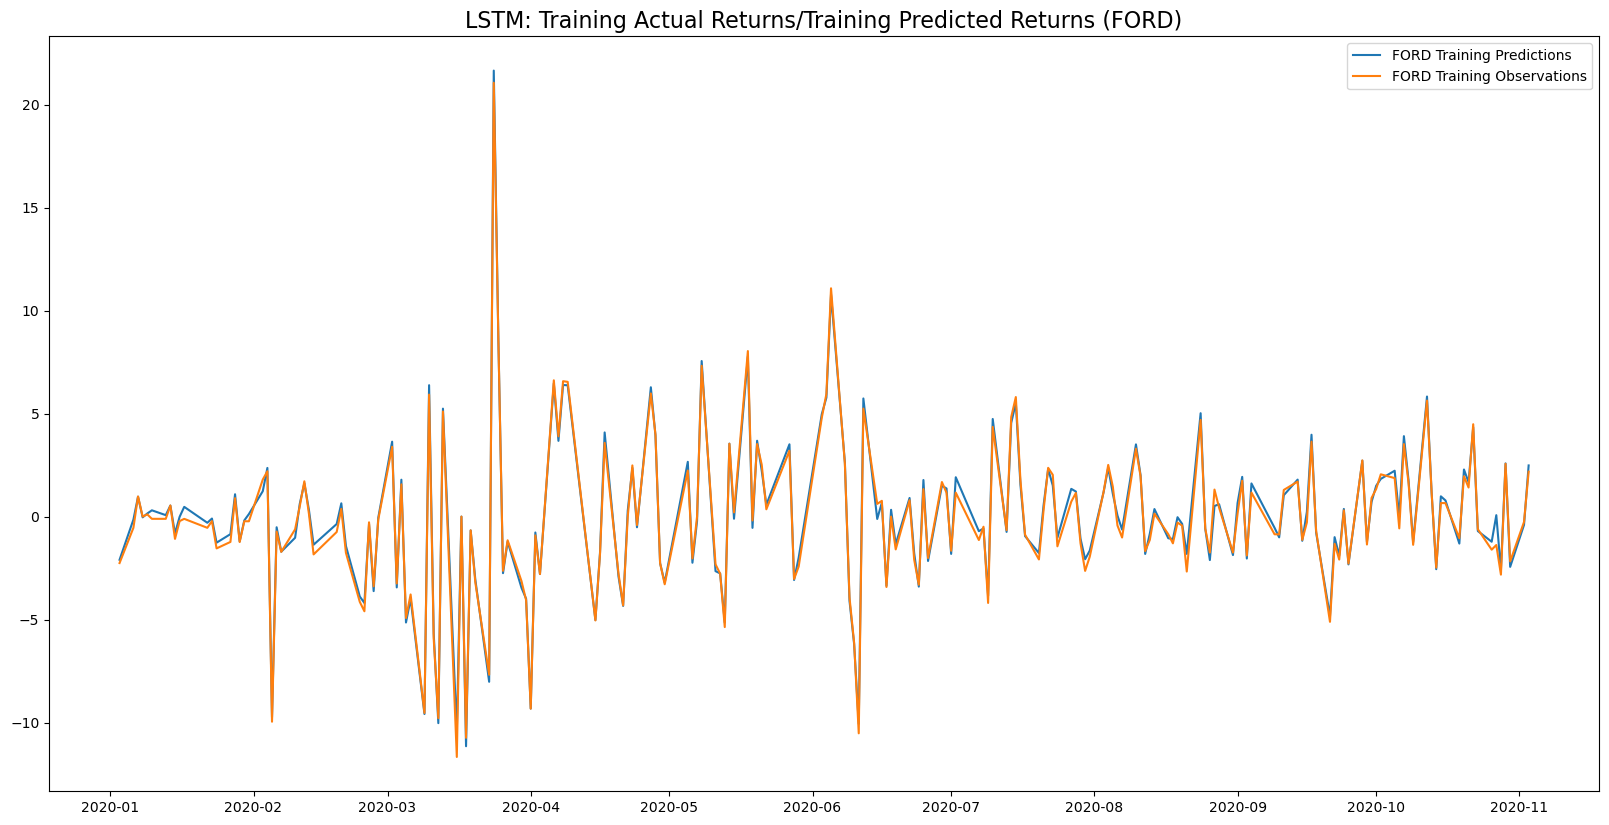

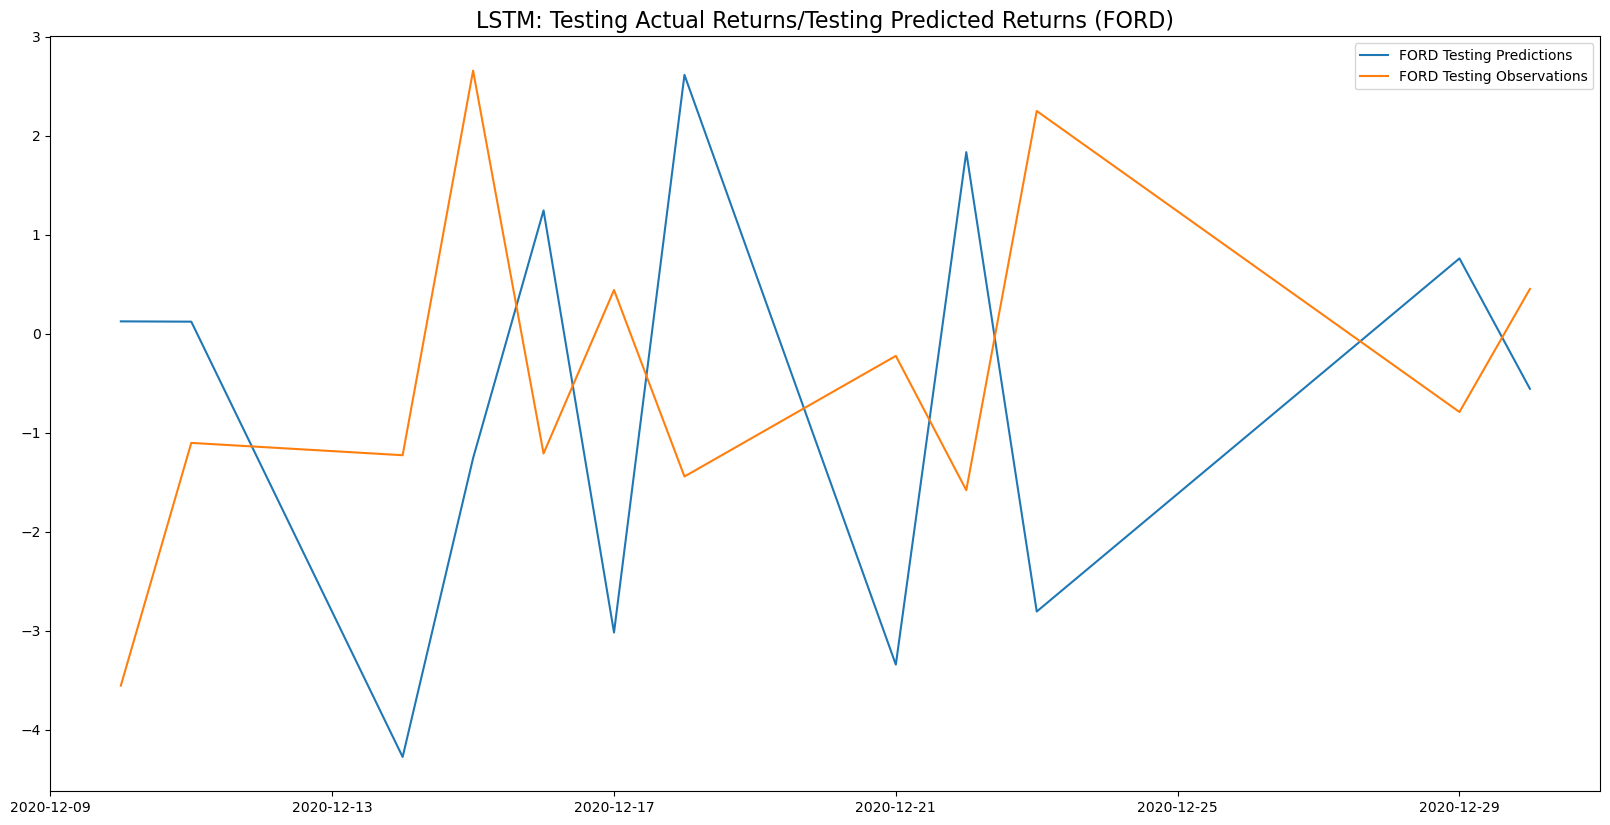

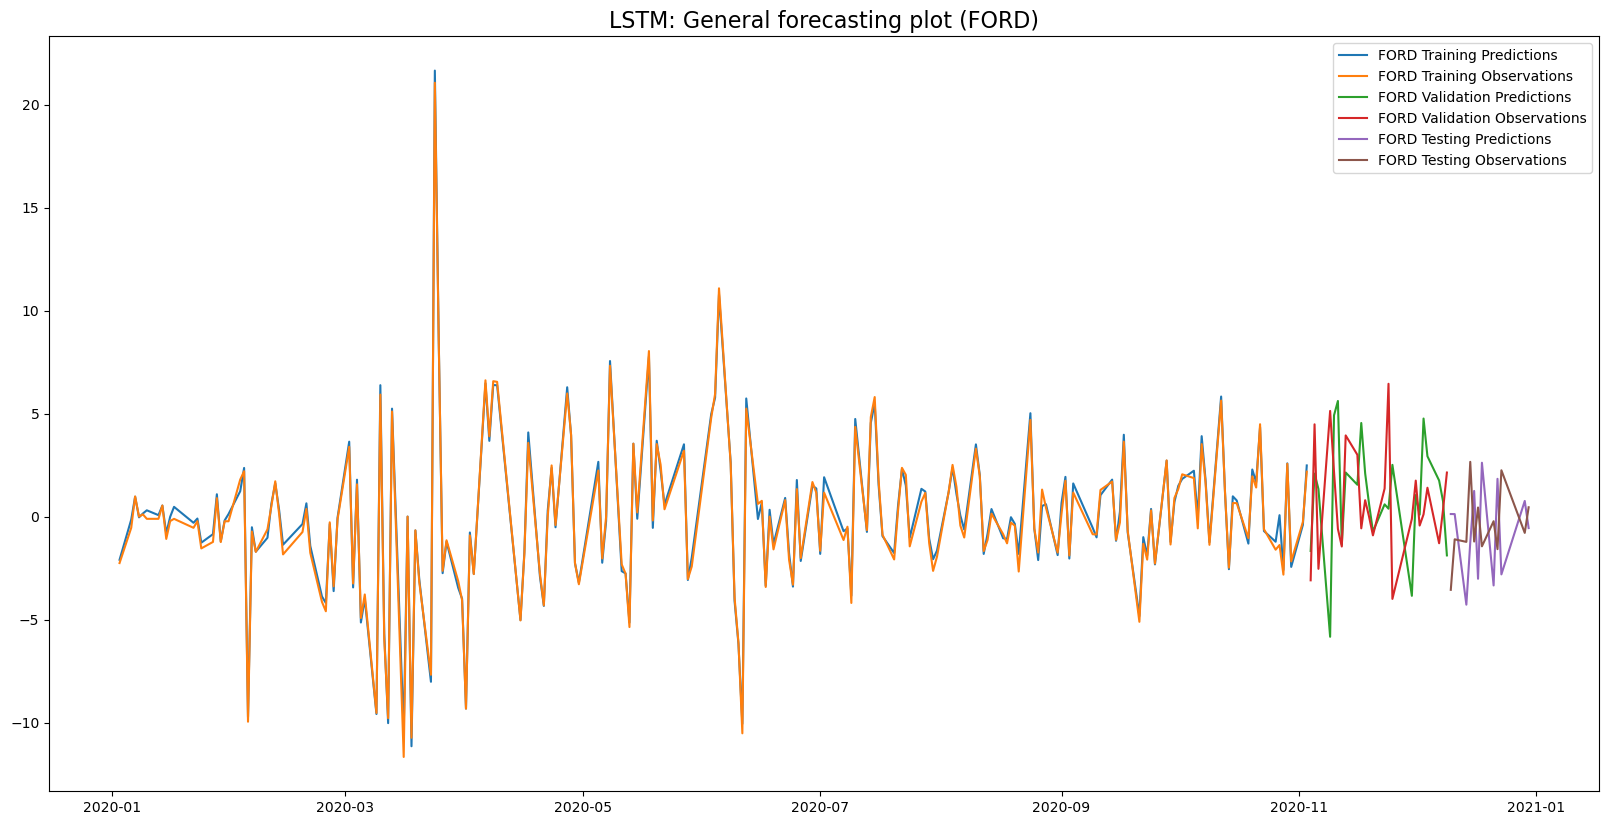

In [87]:
# Plot Training Observations VS Training Predictions 
figure(figsize=(20, 10), dpi=100)
plt.plot(dates_train_F, train_predictions_F)
plt.plot(dates_train_F, y_train_F)
plt.title('LSTM: Training Actual Returns/Training Predicted Returns (FORD)', fontsize=16)
plt.legend(['FORD Training Predictions', 'FORD Training Observations'])

# Plot Testing Observations VS Testing Predictions 
figure(figsize=(20, 10), dpi=100)
plt.plot(dates_test_F, test_predictions_F)
plt.plot(dates_test_F, y_test_F)
plt.title('LSTM: Testing Actual Returns/Testing Predicted Returns (FORD)', fontsize=16)
plt.legend(['FORD Testing Predictions', 'FORD Testing Observations'])

# General Plot (Training, Validation & testing)
figure(figsize=(20, 10), dpi=100)
plt.plot(dates_train_F, train_predictions_F)
plt.plot(dates_train_F, y_train_F)
plt.plot(dates_val_F, val_predictions_F)
plt.plot(dates_val_F, y_val_F)
plt.plot(dates_test_F, test_predictions_F)
plt.plot(dates_test_F, y_test_F)
plt.title('LSTM: General forecasting plot (FORD)', fontsize=16)
plt.legend(['FORD Training Predictions', 
            'FORD Training Observations',
            'FORD Validation Predictions', 
            'FORD Validation Observations',
            'FORD Testing Predictions', 
            'FORD Testing Observations'])

#### Random Forest

##### Deutsche Bank AG

In [88]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(DBK_RET, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(DBK_RET) is list else DBK_RET.shape[1]
    df = DataFrame(DBK_RET)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(DBK_RET, n_test):
    return DBK_RET[:-n_test, :], DBK_RET[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor()
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(DBK_RET, n_test):
    predictions = list()
    
    # split dataset
    train, test = train_test_split(DBK_RET, n_test)
    
    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    for i in range(len(test)):
        
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # add actual observation to history for the next loop
        history.append(test[i])
        
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# transform the time series data into supervised learning
DBK_RET_sl = series_to_supervised(DBK_RET, n_in=6)

# Forecasting & evaluation
mae, y, yhat = walk_forward_validation(DBK_RET_sl, 12)
print('MAE: %.4f' % mae)

>expected=-2.1, predicted=-0.2
>expected=-3.2, predicted=0.1
>expected=-0.2, predicted=0.1
>expected=1.4, predicted=-0.5
>expected=0.6, predicted=0.2
>expected=1.4, predicted=-0.5
>expected=-0.7, predicted=-0.2
>expected=-4.5, predicted=-0.8
>expected=1.8, predicted=0.3
>expected=2.2, predicted=-0.2
>expected=-3.0, predicted=-0.8
>expected=0.1, predicted=-0.2
MAE: 1.7133


In [89]:
# Calculate the RMSE
rmse_rf = sqrt(mean_squared_error(y, yhat))
print('The RMSE value of Random Forest model (DBK): {:.4f}'.format(rmse_rf))

The RMSE value of Random Forest model (DBK): 2.0383


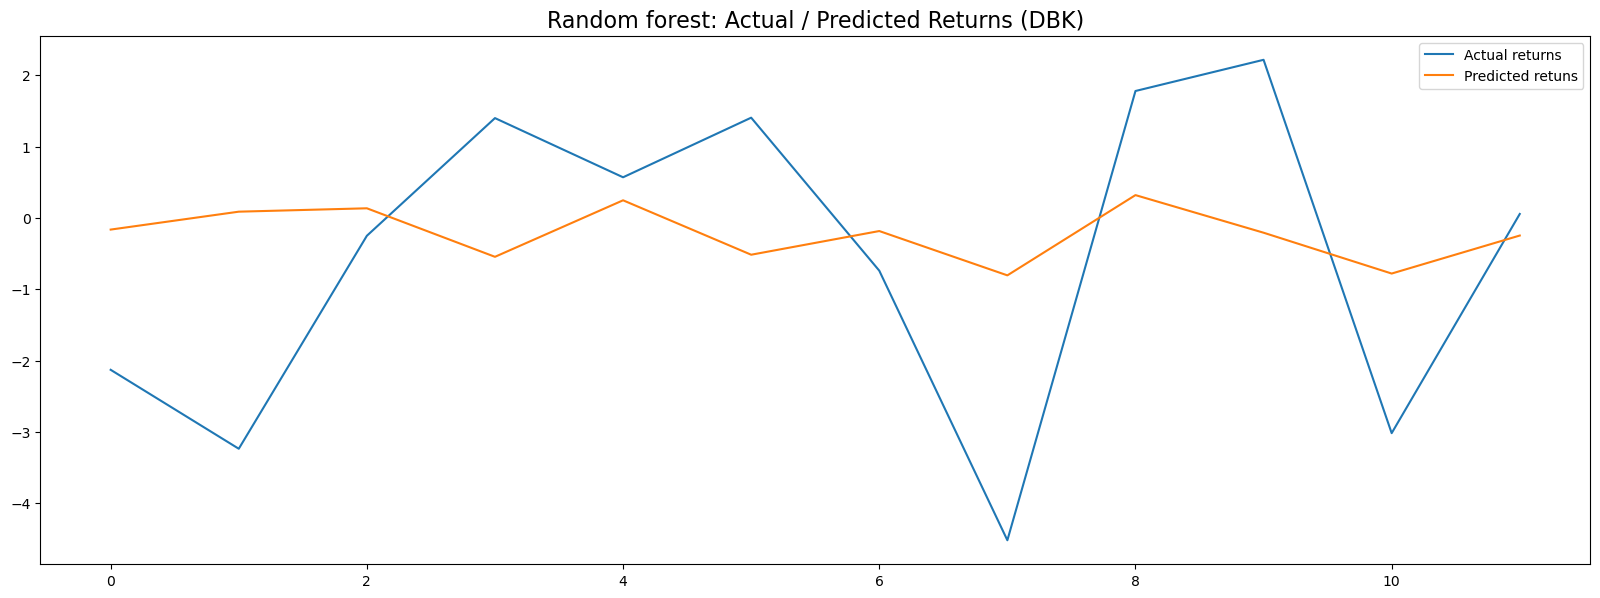

In [90]:
#plot expected vs predicted
figure(figsize=(20, 7), dpi=100)
pyplot.plot(y, label='Actual returns')
pyplot.plot(yhat, label='Predicted retuns')
pyplot.legend()
plt.title('Random forest: Actual / Predicted Returns (DBK)', fontsize=16)
pyplot.show()

##### Bank of America Corp

In [91]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(BAC_RET, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(BAC_RET) is list else BAC_RET.shape[1]
    df = DataFrame(BAC_RET)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(BAC_RET, n_test):
    return BAC_RET[:-n_test, :], BAC_RET[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor()
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(BAC_RET, n_test):
    predictions = list()
    
    # split dataset
    train, test = train_test_split(BAC_RET, n_test)
    
    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    for i in range(len(test)):
        
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # add actual observation to history for the next loop
        history.append(test[i])
        
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# transform the time series data into supervised learning
BAC_RET_sl = series_to_supervised(BAC_RET, n_in=6)

# Forecasting & evaluation
mae, y, yhat = walk_forward_validation(BAC_RET_sl, 12)
print('MAE: %.4f' % mae)

>expected=1.1, predicted=-0.0
>expected=-1.9, predicted=-0.1
>expected=-1.2, predicted=0.3
>expected=1.5, predicted=-0.1
>expected=0.3, predicted=0.2
>expected=0.4, predicted=-0.2
>expected=-0.6, predicted=0.1
>expected=3.7, predicted=0.3
>expected=-1.8, predicted=-0.6
>expected=2.8, predicted=0.2
>expected=-0.4, predicted=-0.3
>expected=-0.1, predicted=-0.2
MAE: 1.2279


In [92]:
# Calculate the RMSE
rmse_rf = sqrt(mean_squared_error(y, yhat))
print('The RMSE value of Random Forest model (BAC): {:.4f}'.format(rmse_rf))

The RMSE value of Random Forest model (BAC): 1.5683


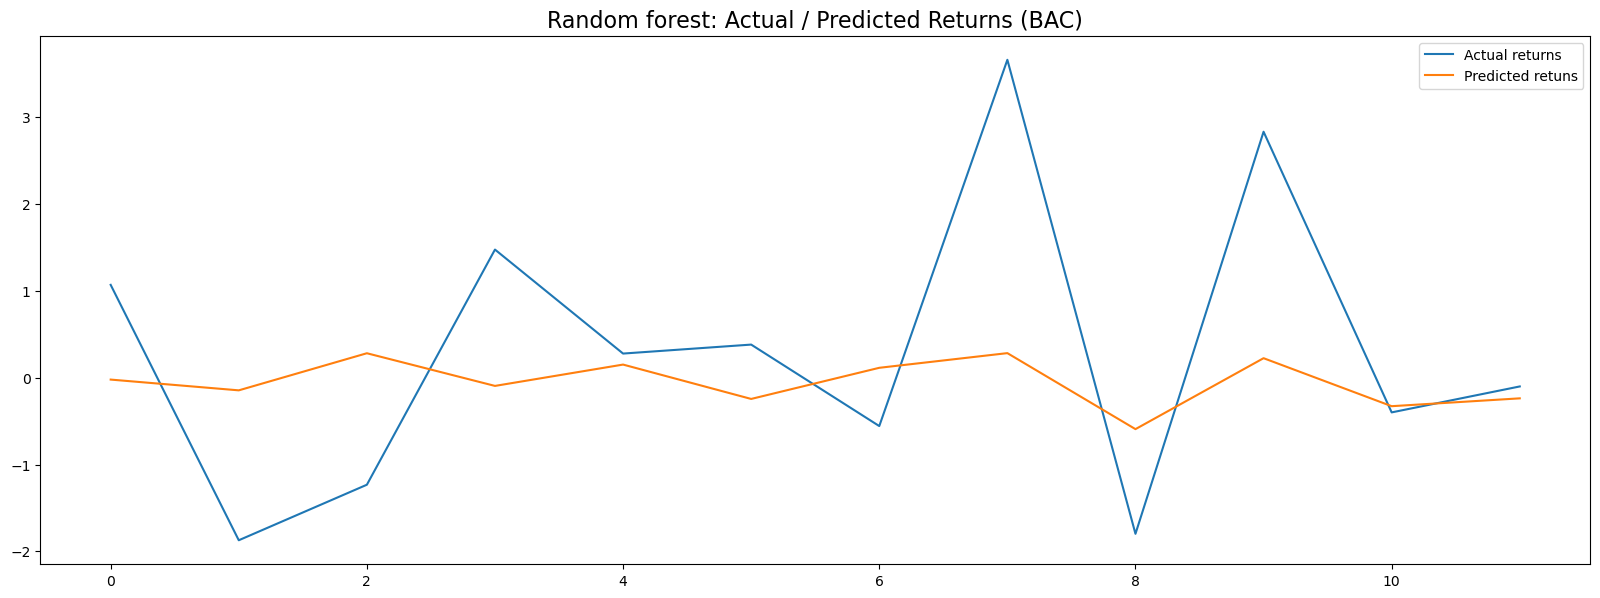

In [93]:
#plot expected vs predicted
figure(figsize=(20, 7), dpi=100)
pyplot.plot(y, label='Actual returns')
pyplot.plot(yhat, label='Predicted retuns')
pyplot.legend()
plt.title('Random forest: Actual / Predicted Returns (BAC)', fontsize=16)
pyplot.show()

##### BMW

In [94]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(BMW_RET, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(BMW_RET) is list else BMW_RET.shape[1]
    df = DataFrame(BMW_RET)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(BMW_RET, n_test):
    return BMW_RET[:-n_test, :], BMW_RET[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor()
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(BMW_RET, n_test):
    predictions = list()
    
    # split dataset
    train, test = train_test_split(BMW_RET, n_test)
    
    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    for i in range(len(test)):
        
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # add actual observation to history for the next loop
        history.append(test[i])
        
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# transform the time series data into supervised learning
BMW_RET_sl = series_to_supervised(BMW_RET, n_in=6)

# Forecasting & evaluation
mae, y, yhat = walk_forward_validation(BMW_RET_sl, 12)
print('MAE: %.4f' % mae)

>expected=-2.5, predicted=-0.0
>expected=-1.2, predicted=-0.6
>expected=2.0, predicted=0.5
>expected=2.7, predicted=0.0
>expected=0.8, predicted=-0.7
>expected=-0.9, predicted=-0.1
>expected=0.6, predicted=-0.9
>expected=-3.0, predicted=0.6
>expected=0.2, predicted=-0.5
>expected=1.8, predicted=-0.4
>expected=-0.5, predicted=-0.1
>expected=-1.3, predicted=0.1
MAE: 1.5796


In [95]:
# Calculate the RMSE
rmse_rf = sqrt(mean_squared_error(y, yhat))
print('The RMSE value of Random Forest model (BMW): {:.4f}'.format(rmse_rf))

The RMSE value of Random Forest model (BMW): 1.8348


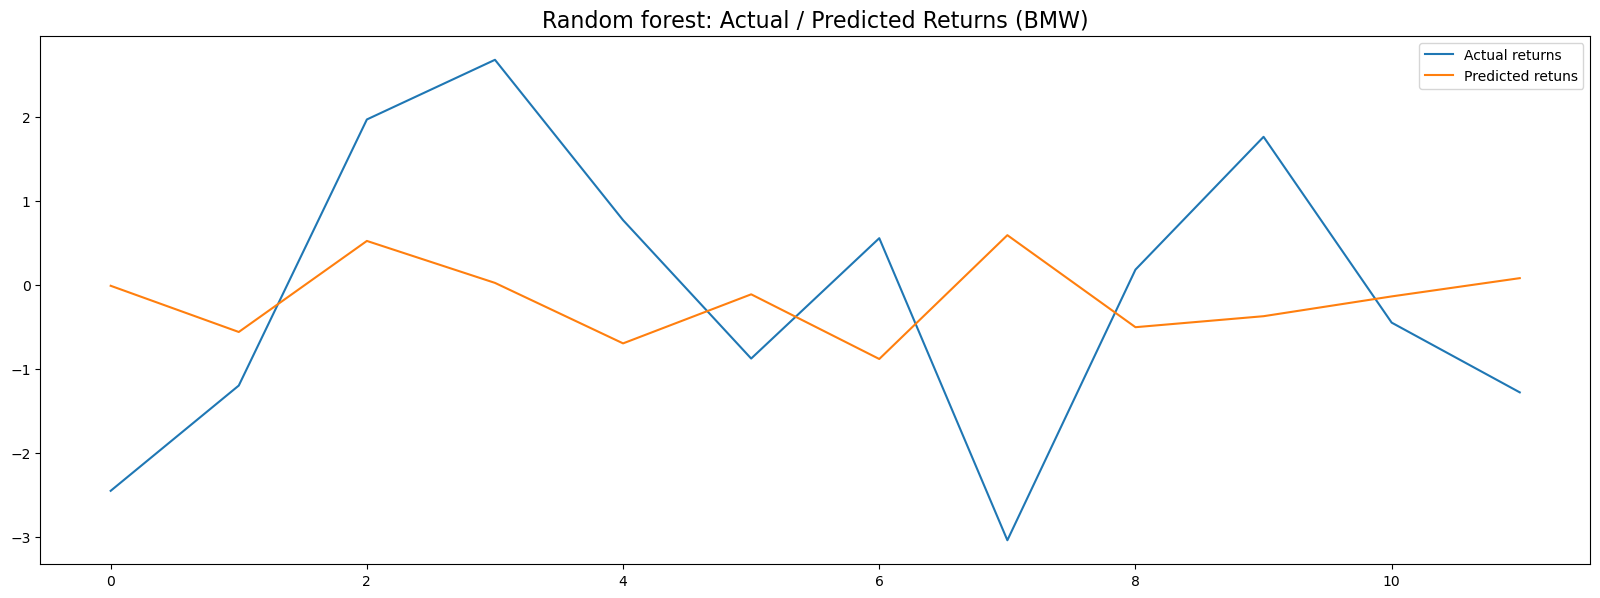

In [96]:
#plot expected vs predicted
figure(figsize=(20, 7), dpi=100)
pyplot.plot(y, label='Actual returns')
pyplot.plot(yhat, label='Predicted retuns')
pyplot.legend()
plt.title('Random forest: Actual / Predicted Returns (BMW)', fontsize=16)
pyplot.show()

##### Ford 

In [97]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(F_RET, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(F_RET) is list else F_RET.shape[1]
    df = DataFrame(F_RET)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(F_RET, n_test):
    return F_RET[:-n_test, :], F_RET[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor()
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(F_RET, n_test):
    predictions = list()
    
    # split dataset
    train, test = train_test_split(F_RET, n_test)
    
    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    for i in range(len(test)):
        
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # add actual observation to history for the next loop
        history.append(test[i])
        
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# transform the time series data into supervised learning
F_RET_sl = series_to_supervised(F_RET, n_in=6)

# Forecasting & evaluation
mae, y, yhat = walk_forward_validation(F_RET_sl, 12)
print('MAE: %.4f' % mae)

>expected=-3.6, predicted=-0.9
>expected=-1.1, predicted=-0.6
>expected=-1.2, predicted=-0.7
>expected=2.7, predicted=-0.6
>expected=-1.2, predicted=-0.2
>expected=0.4, predicted=-0.2
>expected=-1.4, predicted=-0.2
>expected=-0.2, predicted=-0.2
>expected=-1.6, predicted=0.2
>expected=2.2, predicted=-0.4
>expected=-0.8, predicted=-0.3
>expected=0.5, predicted=0.2
MAE: 1.2592


In [98]:
# Calculate the RMSE
rmse_rf = sqrt(mean_squared_error(y, yhat))
print('The RMSE value of Random Forest model (FORD): {:.4f}'.format(rmse_rf))

The RMSE value of Random Forest model (FORD): 1.6323


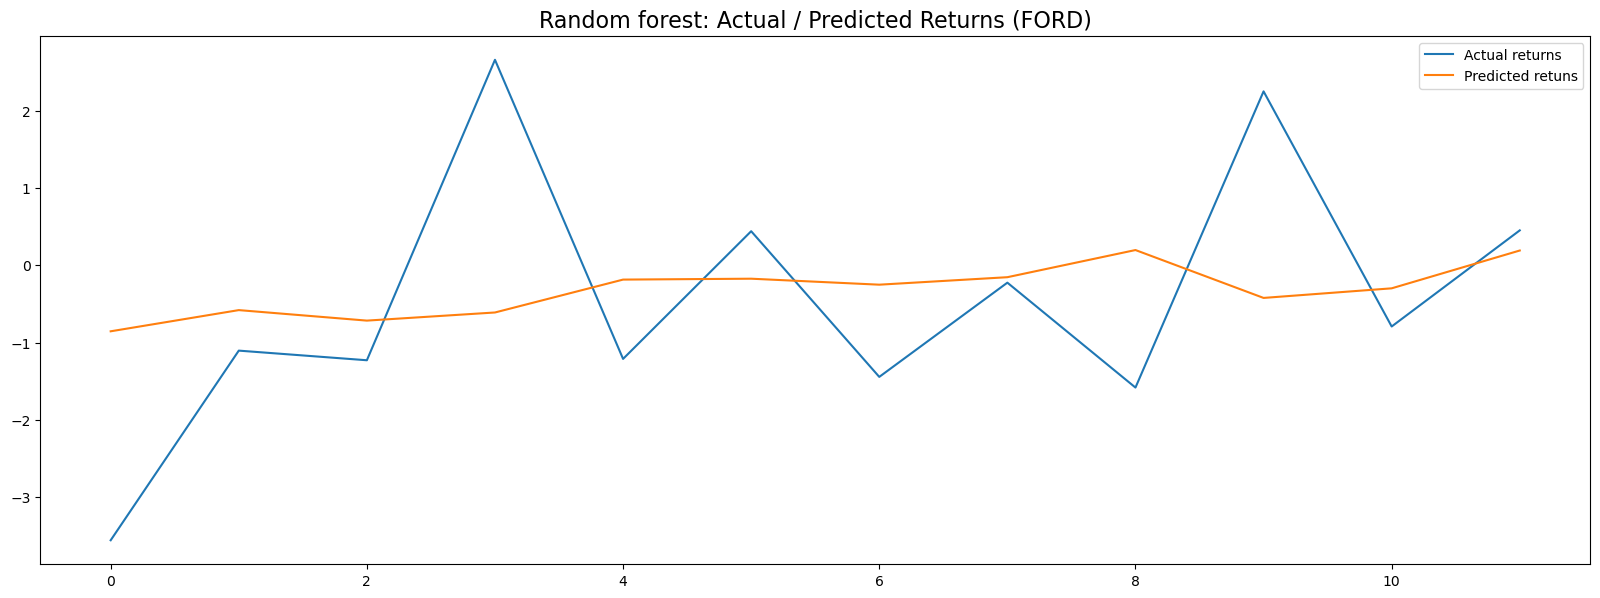

In [99]:
#plot expected vs predicted
figure(figsize=(20, 7), dpi=100)
pyplot.plot(y, label='Actual returns')
pyplot.plot(yhat, label='Predicted retuns')
pyplot.legend()
plt.title('Random forest: Actual / Predicted Returns (FORD)', fontsize=16)
pyplot.show()

## Models comparison

In [101]:
# Compare the RMSE of the models

## create data
data_RMSE = [["ARCH", 0.2504,0.2273, 0.2005 ,0.2219 ], 
             ["GARCH", 0.2076,0.1982, 0.1828 , 0.2174], 
             ["GARCH-t", 0.2074,0.2018, 0.1860 , 0.2236], 
             ["EGARCH", 0.2161,0.1997, 0.1836 , 0.2243], 
             ["GJR-GARCH", 0.2072,0.1787, 0.1722 , 0.2156],
             ["LSTM", 2.6075 ,1.8953, 2.5942 , 3.2206], 
             ["Random Forest", 2.0383,1.5683, 1.8348 , 1.6323]
            ]
  
## define header names
col_names = ["Models", "RMSE_DBK","RMSE_BAC", "RMSE_BMW", "RMSE_FORD"]
  
## display table
print(tabulate(data_RMSE, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════╤════════════╤════════════╤════════════╤═════════════╕
│ Models        │   RMSE_DBK │   RMSE_BAC │   RMSE_BMW │   RMSE_FORD │
╞═══════════════╪════════════╪════════════╪════════════╪═════════════╡
│ ARCH          │     0.2504 │     0.2273 │     0.2005 │      0.2219 │
├───────────────┼────────────┼────────────┼────────────┼─────────────┤
│ GARCH         │     0.2076 │     0.1982 │     0.1828 │      0.2174 │
├───────────────┼────────────┼────────────┼────────────┼─────────────┤
│ GARCH-t       │     0.2074 │     0.2018 │     0.186  │      0.2236 │
├───────────────┼────────────┼────────────┼────────────┼─────────────┤
│ EGARCH        │     0.2161 │     0.1997 │     0.1836 │      0.2243 │
├───────────────┼────────────┼────────────┼────────────┼─────────────┤
│ GJR-GARCH     │     0.2072 │     0.1787 │     0.1722 │      0.2156 │
├───────────────┼────────────┼────────────┼────────────┼─────────────┤
│ LSTM          │     2.6075 │     1.8953 │     2.5942 │      3.2206 │
├─────

For each company, we designed and applied GARCH, LTSM, and Random Forest models to demonstrate their importance in forecasting the volatility of these markets. Based on the forecasting results obtained, we can conclude that **GARCH models** performed much better than **Data Science models**. Indeed, the best model performance was from **GJR GARCH** by giving the lowest *RMSE* and **LSTM** had the worst performance in both industries.